In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading Data
country = pd.read_csv("Data/EdStatsCountry.csv")
countryseries = pd.read_csv("Data/EdStatsCountry-Series.csv")
data = pd.read_csv("Data/EdStatsData.csv")
footnote = pd.read_csv("Data/EdStatsFootNote.csv")
series = pd.read_csv("Data/EdStatsSeries.csv")

# Data Informations

In [3]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                                       214 non-null    object 
 9   WB-2 code 

In [4]:
countryseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    886930 non-null  object 
 1   Country Code    886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   Indicator Code  886930 non-null  object 
 4   1970            72288 non-null   float64
 5   1971            35537 non-null   float64
 6   1972            35619 non-null   float64
 7   1973            35545 non-null   float64
 8   1974            35730 non-null   float64
 9   1975            87306 non-null   float64
 10  1976            37483 non-null   float64
 11  1977            37574 non-null   float64
 12  1978            37576 non-null   float64
 13  1979            36809 non-null   float64
 14  1980            89122 non-null   float64
 15  1981            38777 non-null   float64
 16  1982            37511 non-null   float64
 17  1983      

In [6]:
footnote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


In [7]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Series Code                          3665 non-null   object 
 1   Topic                                3665 non-null   object 
 2   Indicator Name                       3665 non-null   object 
 3   Short definition                     2156 non-null   object 
 4   Long definition                      3665 non-null   object 
 5   Unit of measure                      0 non-null      float64
 6   Periodicity                          99 non-null     object 
 7   Base Period                          314 non-null    object 
 8   Other notes                          552 non-null    object 
 9   Aggregation method                   47 non-null     object 
 10  Limitations and exceptions           14 non-null     object 
 11  Notes from original source    

# Quick Cleaning

As we can see, we have a lot of columns with missing values. In order to deal with only valuable informations we we'll remove columns with at least 50% of non NA values. We won't use this on the data DataFrame as we'll be reasonning by country (rows) and we want all the information by year we can get for now.

In [8]:
# Removing some columns without enough information (based on threshold) and lowercase

def lowering(df):
    
    df = df.applymap(lambda x: x.lower() if type(x) == str else x)
    df.columns = df.columns.str.lower()
    
    return df

def cleaning(df, perc=0.5):
    
    threshold = int(perc*df.shape[0])
    df.dropna(axis=1, thresh=threshold, inplace=True)
    df = lowering(df)
    
    return df

In [9]:
country = cleaning(country)
countryseries = cleaning(countryseries)
footnote = cleaning(footnote)
series = cleaning(series)
data = lowering(data)
data.drop('unnamed: 69', axis=1, inplace=True) # As we're not cleaning based on % of NAN we have to remove this column too.

# Looking for internet acces informations.

As we are talking about e-learning, the first thing to look out is for a country to have a good acces to internet or a good amount of people to have internet access. That being said, we're looking for indicators about internet acces in the Series DataFrame explaining what the indicators are for.

In [10]:
seriesinternet = series[(series['topic'].str.contains('internet')) |
                        (series['indicator name'].str.contains('internet')) |
                        (series['short definition'].str.contains('internet')) |
                        (series['long definition'].str.contains('internet'))]

seriesinternet.head()

series code                           topic  \
611  it.net.user.p2  infrastructure: communications   

                      indicator name short definition  \
611  internet users (per 100 people)              NaN   

                                       long definition  \
611  internet users are individuals who have used t...   

                                                source  
611  international telecommunication union, world t...

# Data Selection

## Based on years

As we saw earlier with the dataset infos, we have a large amount of years from 1970 to 2100. As we are looking into selecting a few target countries to expand the e-learning activity of the start-up, we don't really need all the old/future data so we'll create a filter to select the years we are interested in. We can selective about the years as we don't really need the oldest data. We'll select years from 1990 to 2017 to get rid of the oldest data but to still be able to view  the evolution though the last 25 years.

In [11]:
# Function to filter data based on years selected (included)
def masque_année(dataframe, début, fin):
    
    filtre = ['country name', 'country code', 'indicator name', 'indicator code']
    années = np.arange(début, fin+1).astype(str).tolist()
    filtre += années
    
    df = dataframe[filtre].copy()
    return df

In [12]:
data = masque_année(data,1990,2017)
data.head()

country name country code  \
0   arab world          arb   
1   arab world          arb   
2   arab world          arb   
3   arab world          arb   
4   arab world          arb   

                                      indicator name  indicator code  \
0  adjusted net enrolment rate, lower secondary, ...      uis.nera.2   
1  adjusted net enrolment rate, lower secondary, ...    uis.nera.2.f   
2  adjusted net enrolment rate, lower secondary, ...  uis.nera.2.gpi   
3  adjusted net enrolment rate, lower secondary, ...    uis.nera.2.m   
4  adjusted net enrolment rate, primary, both sex...     se.prm.tenr   

        1990       1991       1992       1993       1994      1995  ...  \
0        NaN        NaN        NaN        NaN        NaN       NaN  ...   
1        NaN        NaN        NaN        NaN        NaN       NaN  ...   
2        NaN        NaN        NaN        NaN        NaN       NaN  ...   
3        NaN        NaN        NaN        NaN        NaN       NaN  ...   
4  71.995819  72.602837  70.032722  70.464821  72.645683  71.81176  ...   

        2008       2009       2010      2011       2012      2013       2014  \
0        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
1        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
2        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
3        NaN        NaN        NaN       NaN        NaN       NaN        NaN   
4  84.011871  84.195961  85.211998  85.24514  86.101669  85.51194  85.320152   

   2015  2016  2017  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 32 columns]

Now that we made a first selection of useful years we can check the rows where we have the internet acces indicator

## Based on internect acces indicator

In [13]:
internetusers = data[data['indicator code']==seriesinternet['series code'].values[0]].copy()
internetusers.head()

country name country code  \
1375                                    arab world          arb   
5040                           east asia & pacific          eas   
8705   east asia & pacific (excluding high income)          eap   
12370                                    euro area          emu   
16035                        europe & central asia          ecs   

                        indicator name  indicator code      1990     1991  \
1375   internet users (per 100 people)  it.net.user.p2  0.000000      NaN   
5040   internet users (per 100 people)  it.net.user.p2  0.007288      NaN   
8705   internet users (per 100 people)  it.net.user.p2  0.000000      NaN   
12370  internet users (per 100 people)  it.net.user.p2  0.072801  0.16974   
16035  internet users (per 100 people)  it.net.user.p2  0.048116      NaN   

           1992      1993      1994      1995  ...       2008       2009  \
1375        NaN       NaN       NaN  0.017025  ...  18.593531  22.973689   
5040        NaN  0.079278  0.117382  0.209578  ...  25.253566  29.513198   
8705        NaN  0.001162  0.004033  0.013045  ...  19.260138  23.769242   
12370  0.326615  0.469641  0.848077  1.702975  ...  64.843610  67.129830   
16035  0.262590  0.317773  0.564867  1.024013  ...  47.359045  50.566038   

            2010       2011       2012       2013       2014       2015  \
1375   26.747251  29.707761  34.014224  36.868602        NaN        NaN   
5040   34.230838  37.365156  40.709345  44.577349  46.812103  49.787924   
8705   28.957572  32.385761  36.068349  39.708933  42.062234  45.210103   
12370  71.036722  72.001164  74.092136  75.821560  77.002322  78.666346   
16035  56.119117  58.834630  63.486253  66.306669  68.944351  71.162003   

            2016  2017  
1375         NaN   NaN  
5040   52.796321   NaN  
8705   48.386621   NaN  
12370  80.446726   NaN  
16035  73.914751   NaN  

[5 rows x 32 columns]

One thing that could be interesting to see is the number of years with data so we can filter on countries with at least sone year with data.

In [14]:
internetusers["nombre_années_data"] = internetusers.drop(["country name", "country code", "indicator name", "indicator code"], axis = 1).notna().sum(axis=1)
internetusers.head()

country name country code  \
1375                                    arab world          arb   
5040                           east asia & pacific          eas   
8705   east asia & pacific (excluding high income)          eap   
12370                                    euro area          emu   
16035                        europe & central asia          ecs   

                        indicator name  indicator code      1990     1991  \
1375   internet users (per 100 people)  it.net.user.p2  0.000000      NaN   
5040   internet users (per 100 people)  it.net.user.p2  0.007288      NaN   
8705   internet users (per 100 people)  it.net.user.p2  0.000000      NaN   
12370  internet users (per 100 people)  it.net.user.p2  0.072801  0.16974   
16035  internet users (per 100 people)  it.net.user.p2  0.048116      NaN   

           1992      1993      1994      1995  ...       2009       2010  \
1375        NaN       NaN       NaN  0.017025  ...  22.973689  26.747251   
5040        NaN  0.079278  0.117382  0.209578  ...  29.513198  34.230838   
8705        NaN  0.001162  0.004033  0.013045  ...  23.769242  28.957572   
12370  0.326615  0.469641  0.848077  1.702975  ...  67.129830  71.036722   
16035  0.262590  0.317773  0.564867  1.024013  ...  50.566038  56.119117   

            2011       2012       2013       2014       2015       2016  2017  \
1375   29.707761  34.014224  36.868602        NaN        NaN        NaN   NaN   
5040   37.365156  40.709345  44.577349  46.812103  49.787924  52.796321   NaN   
8705   32.385761  36.068349  39.708933  42.062234  45.210103  48.386621   NaN   
12370  72.001164  74.092136  75.821560  77.002322  78.666346  80.446726   NaN   
16035  58.834630  63.486253  66.306669  68.944351  71.162003  73.914751   NaN   

       nombre_années_data  
1375                   20  
5040                   25  
8705                   25  
12370                  27  
16035                  26  

[5 rows x 33 columns]

We can now select rows where we have at least one year with data

In [15]:
internetusersdata = internetusers[internetusers["nombre_années_data"]>0]
internetusersdata.head()

country name country code  \
1375                                    arab world          arb   
5040                           east asia & pacific          eas   
8705   east asia & pacific (excluding high income)          eap   
12370                                    euro area          emu   
16035                        europe & central asia          ecs   

                        indicator name  indicator code      1990     1991  \
1375   internet users (per 100 people)  it.net.user.p2  0.000000      NaN   
5040   internet users (per 100 people)  it.net.user.p2  0.007288      NaN   
8705   internet users (per 100 people)  it.net.user.p2  0.000000      NaN   
12370  internet users (per 100 people)  it.net.user.p2  0.072801  0.16974   
16035  internet users (per 100 people)  it.net.user.p2  0.048116      NaN   

           1992      1993      1994      1995  ...       2009       2010  \
1375        NaN       NaN       NaN  0.017025  ...  22.973689  26.747251   
5040        NaN  0.079278  0.117382  0.209578  ...  29.513198  34.230838   
8705        NaN  0.001162  0.004033  0.013045  ...  23.769242  28.957572   
12370  0.326615  0.469641  0.848077  1.702975  ...  67.129830  71.036722   
16035  0.262590  0.317773  0.564867  1.024013  ...  50.566038  56.119117   

            2011       2012       2013       2014       2015       2016  2017  \
1375   29.707761  34.014224  36.868602        NaN        NaN        NaN   NaN   
5040   37.365156  40.709345  44.577349  46.812103  49.787924  52.796321   NaN   
8705   32.385761  36.068349  39.708933  42.062234  45.210103  48.386621   NaN   
12370  72.001164  74.092136  75.821560  77.002322  78.666346  80.446726   NaN   
16035  58.834630  63.486253  66.306669  68.944351  71.162003  73.914751   NaN   

       nombre_années_data  
1375                   20  
5040                   25  
8705                   25  
12370                  27  
16035                  26  

[5 rows x 33 columns]

We can see that some 'countries' are in fact regions of the world. Let's take a look at the countries and regions lists.

## Data : pays/region

In [16]:
internetusersdata["country name"].unique()

array(['arab world', 'east asia & pacific',
       'east asia & pacific (excluding high income)', 'euro area',
       'europe & central asia',
       'europe & central asia (excluding high income)', 'european union',
       'heavily indebted poor countries (hipc)', 'high income',
       'latin america & caribbean',
       'latin america & caribbean (excluding high income)',
       'least developed countries: un classification',
       'low & middle income', 'low income', 'lower middle income',
       'middle east & north africa',
       'middle east & north africa (excluding high income)',
       'middle income', 'north america', 'oecd members', 'south asia',
       'sub-saharan africa', 'sub-saharan africa (excluding high income)',
       'upper middle income', 'world', 'afghanistan', 'albania',
       'algeria', 'american samoa', 'andorra', 'angola',
       'antigua and barbuda', 'argentina', 'armenia', 'aruba',
       'australia', 'austria', 'azerbaijan', 'bahamas, the', 'bahrain',


In [17]:
# Regions of the world list
country['region'].unique()

array(['latin america & caribbean', 'south asia', 'sub-saharan africa',
       'europe & central asia', nan, 'middle east & north africa',
       'east asia & pacific', 'north america'], dtype=object)

In [18]:
internetusersdata["country name"].duplicated().value_counts()

False    233
Name: country name, dtype: int64

There are some region which are part of the countries list but not in the region one so we need to make our own list manually. We will keep only data from countries.

In [19]:
region_categorie =['arab world', 'east asia & pacific',
       'east asia & pacific (excluding high income)', 'euro area',
       'europe & central asia',
       'europe & central asia (excluding high income)', 'european union',
       'heavily indebted poor countries (hipc)', 'high income',
       'latin america & caribbean',
       'latin america & caribbean (excluding high income)',
       'least developed countries: un classification',
       'low & middle income', 'low income', 'lower middle income',
       'middle east & north africa',
       'middle east & north africa (excluding high income)',
       'middle income', 'north america', 'oecd members', 'south asia',
       'sub-saharan africa', 'sub-saharan africa (excluding high income)',
       'upper middle income', 'world']


datacountries = data[~data["country name"].isin(region_categorie)]
datacountries.head()

country name country code  \
91625  afghanistan          afg   
91626  afghanistan          afg   
91627  afghanistan          afg   
91628  afghanistan          afg   
91629  afghanistan          afg   

                                          indicator name  indicator code  \
91625  adjusted net enrolment rate, lower secondary, ...      uis.nera.2   
91626  adjusted net enrolment rate, lower secondary, ...    uis.nera.2.f   
91627  adjusted net enrolment rate, lower secondary, ...  uis.nera.2.gpi   
91628  adjusted net enrolment rate, lower secondary, ...    uis.nera.2.m   
91629  adjusted net enrolment rate, primary, both sex...     se.prm.tenr   

       1990  1991  1992       1993  1994  1995  ...  2008  2009  2010  2011  \
91625   NaN   NaN   NaN  17.260189   NaN   NaN  ...   NaN   NaN   NaN   NaN   
91626   NaN   NaN   NaN   9.431810   NaN   NaN  ...   NaN   NaN   NaN   NaN   
91627   NaN   NaN   NaN   0.386230   NaN   NaN  ...   NaN   NaN   NaN   NaN   
91628   NaN   NaN   NaN  24.420429   NaN   NaN  ...   NaN   NaN   NaN   NaN   
91629   NaN   NaN   NaN        NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   

       2012       2013       2014  2015  2016  2017  
91625   NaN  47.436790  50.627232   NaN   NaN   NaN  
91626   NaN  34.073261  37.641541   NaN   NaN   NaN  
91627   NaN   0.567060   0.598370   NaN   NaN   NaN  
91628   NaN  60.087059  62.906952   NaN   NaN   NaN  
91629   NaN        NaN        NaN   NaN   NaN   NaN  

[5 rows x 32 columns]

We can do the same for the internetusers data we got earlier too.

In [20]:
internetusersdata = internetusersdata[~internetusersdata["country name"].isin(region_categorie)]
internetusersdata.head()

country name country code                   indicator name  \
93000      afghanistan          afg  internet users (per 100 people)   
96665          albania          alb  internet users (per 100 people)   
100330         algeria          dza  internet users (per 100 people)   
103995  american samoa          asm  internet users (per 100 people)   
107660         andorra          and  internet users (per 100 people)   

        indicator code  1990  1991  1992  1993      1994      1995  ...  \
93000   it.net.user.p2   0.0   NaN   NaN   NaN       NaN       NaN  ...   
96665   it.net.user.p2   0.0   NaN   NaN   NaN       NaN  0.011169  ...   
100330  it.net.user.p2   0.0   NaN   NaN   NaN  0.000361  0.001769  ...   
103995  it.net.user.p2   0.0   NaN   NaN   NaN       NaN       NaN  ...   
107660  it.net.user.p2   0.0   NaN   NaN   NaN       NaN       NaN  ...   

         2009  2010  2011       2012  2013  2014       2015       2016  2017  \
93000    3.55   4.0   5.0   5.454545   5.9   7.0   8.260000  10.595726   NaN   
96665   41.20  45.0  49.0  54.655959  57.2  60.1  63.252933  66.363445   NaN   
100330  11.23  12.5  14.9  18.200000  22.5  29.5  38.200000  42.945527   NaN   
103995    NaN   NaN   NaN        NaN   NaN   NaN        NaN        NaN   NaN   
107660  78.53  81.0  81.0  86.434425  94.0  95.9  96.910000  97.930637   NaN   

        nombre_années_data  
93000                   17  
96665                   23  
100330                  24  
103995                   1  
107660                  21  

[5 rows x 33 columns]

Now that we isolated the internet acces data we can start looking at it.We already made a selection of countries with at least one year with data and we created a feature counting the number of years with data for each country. We can look at this feature to get an idea of how many countries have a lot of data.

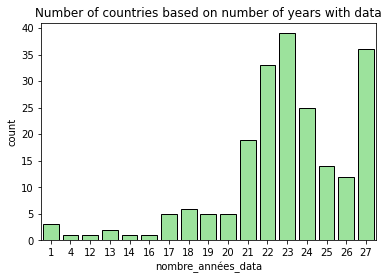

In [21]:
sns.countplot(x=internetusersdata.nombre_années_data, color='lightgreen', edgecolor='black')
plt.title('Number of countries based on number of years with data');

Most of countries have around 20/30 years of data. We can also look at what years have the most data

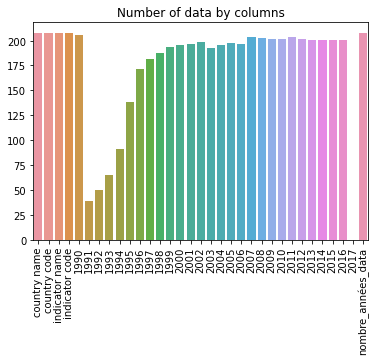

In [22]:
sns.barplot(x=internetusersdata.count().index, y=internetusersdata.count().values)
plt.xticks(rotation=90)
plt.title('Number of data by columns');

We can see that the year 2017 has no data and the oldest years have the less data. We'll remove them from the data set. The most important years are the most recent anyways and update the number of years with data.

In [23]:
internetusersdata.drop(['1990', '1991', '1992', '1993', '1994', '1995', '2017'], axis=1, inplace=True)
years_internet = internetusersdata.drop(["country name", "country code", "indicator name", "indicator code", 'nombre_années_data'], axis = 1).columns
internetusersdata["nombre_années_data"] = internetusersdata[years_internet].notna().sum(axis=1)
internetusersdata = internetusersdata[internetusersdata["nombre_années_data"]>0]
internetusersdata.head()

country name country code                   indicator name  \
93000   afghanistan          afg  internet users (per 100 people)   
96665       albania          alb  internet users (per 100 people)   
100330      algeria          dza  internet users (per 100 people)   
107660      andorra          and  internet users (per 100 people)   
111325       angola          ago  internet users (per 100 people)   

        indicator code      1996      1997      1998      1999       2000  \
93000   it.net.user.p2       NaN       NaN       NaN       NaN        NaN   
96665   it.net.user.p2  0.032197  0.048594  0.065027  0.081437   0.114097   
100330  it.net.user.p2  0.001739  0.010268  0.020239  0.199524   0.491706   
107660  it.net.user.p2  1.526601  3.050175  6.886209  7.635686  10.538836   
111325  it.net.user.p2  0.000776  0.005674  0.018454  0.071964   0.105046   

            2001  ...   2008   2009  2010  2011       2012  2013  2014  \
93000   0.004723  ...   1.84   3.55   4.0   5.0   5.454545   5.9   7.0   
96665   0.325798  ...  23.86  41.20  45.0  49.0  54.655959  57.2  60.1   
100330  0.646114  ...  10.18  11.23  12.5  14.9  18.200000  22.5  29.5   
107660       NaN  ...  70.04  78.53  81.0  81.0  86.434425  94.0  95.9   
111325  0.136014  ...   1.90   2.30   2.8   3.1   6.500000   8.9  10.2   

             2015       2016  nombre_années_data  
93000    8.260000  10.595726                  16  
96665   63.252933  66.363445                  21  
100330  38.200000  42.945527                  21  
107660  96.910000  97.930637                  20  
111325  12.400000  13.000000                  21  

[5 rows x 26 columns]

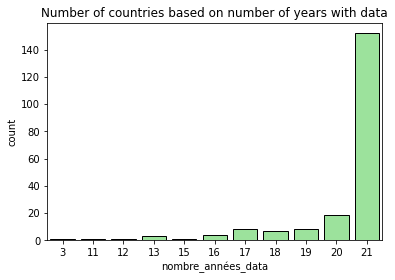

In [24]:
sns.countplot(x=internetusersdata.nombre_années_data, color='lightgreen', edgecolor='black')
plt.title('Number of countries based on number of years with data');

We can check the evolution of the indicator through the years to see if there is a tendancy (we expect a growth). We can first the mean percentage of internet users of countries through the years.

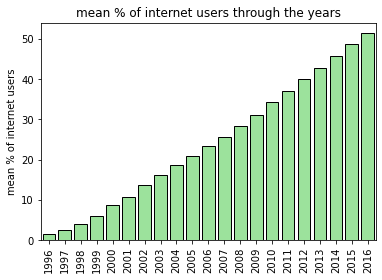

In [25]:
mean_internet = []
for year in years_internet:
    mean_internet.append(internetusersdata[year].mean())

sns.barplot(x=years_internet, y=mean_internet, color='lightgreen',  edgecolor='black')
plt.xticks(rotation=90)
plt.ylabel('mean % of internet users')
plt.title('mean % of internet users through the years');

As exepected More and more people get acces to internet as the time passes. We can also look the evolution for a sample of countries. We'll plot only a sample to help with the visualization since we have a lot of countries.

In [26]:
def evolutionpaysannées(df, years, axe_x='years',axe_y='', titre = ''):
    plt.figure(figsize = (15,7))
    plt.rcParams.update({'font.size': 14})
    plt.xticks(rotation=90)
    plt.xlabel(axe_x, labelpad = 20)
    plt.ylabel(axe_y, labelpad = 20)
    plt.title(titre, pad = 20)

    for country in df['country name'].values:
        données = []
        for year in years:
            données.append(df.loc[df['country name'] == country][year].values[0])
        plt.plot(years, données)         

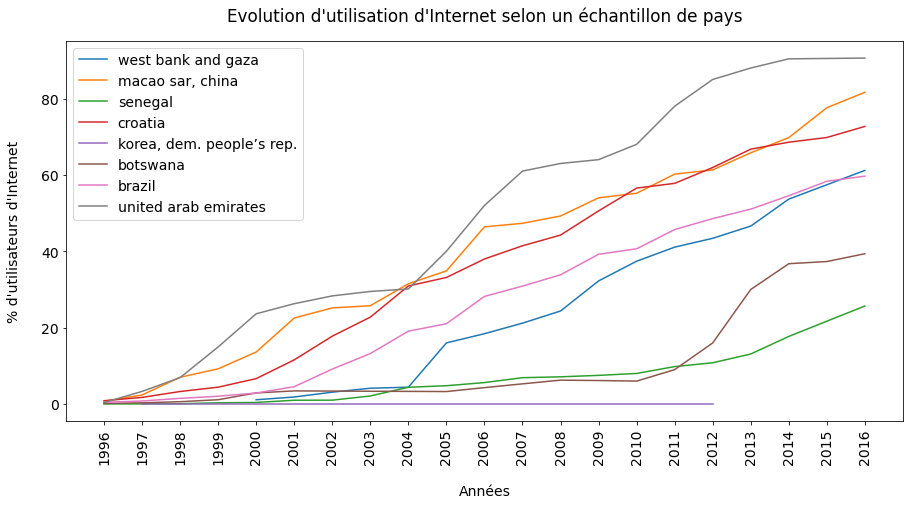

In [27]:
sample = internetusersdata.sample(8)
evolutionpaysannées(sample, years_internet, 'Années', "% d'utilisateurs d'Internet", "Evolution d'utilisation d'Internet selon un échantillon de pays")
plt.legend(sample['country name']);

Something that could be interresting is the last year of the data. If the data is really old, we can assume it's not really accurate of the situation of the country.

In [28]:
internetusersdata.loc[93000][internetusersdata.loc[93000].notna()].index[-1]

'nombre_années_data'

In [29]:
def last_year(df, années):
    
    df_années = df[années]
    lastdatayears = [df_années.loc[i][df_années.loc[i].notna()].index[-1] for i in df.index] # Take columns with no NaN values and get the last one
    
    df['last_year'] = lastdatayears

In [30]:
last_year(internetusersdata, years_internet)
internetusersdata.head()

country name country code                   indicator name  \
93000   afghanistan          afg  internet users (per 100 people)   
96665       albania          alb  internet users (per 100 people)   
100330      algeria          dza  internet users (per 100 people)   
107660      andorra          and  internet users (per 100 people)   
111325       angola          ago  internet users (per 100 people)   

        indicator code      1996      1997      1998      1999       2000  \
93000   it.net.user.p2       NaN       NaN       NaN       NaN        NaN   
96665   it.net.user.p2  0.032197  0.048594  0.065027  0.081437   0.114097   
100330  it.net.user.p2  0.001739  0.010268  0.020239  0.199524   0.491706   
107660  it.net.user.p2  1.526601  3.050175  6.886209  7.635686  10.538836   
111325  it.net.user.p2  0.000776  0.005674  0.018454  0.071964   0.105046   

            2001  ...   2009  2010  2011       2012  2013  2014       2015  \
93000   0.004723  ...   3.55   4.0   5.0   5.454545   5.9   7.0   8.260000   
96665   0.325798  ...  41.20  45.0  49.0  54.655959  57.2  60.1  63.252933   
100330  0.646114  ...  11.23  12.5  14.9  18.200000  22.5  29.5  38.200000   
107660       NaN  ...  78.53  81.0  81.0  86.434425  94.0  95.9  96.910000   
111325  0.136014  ...   2.30   2.8   3.1   6.500000   8.9  10.2  12.400000   

             2016  nombre_années_data  last_year  
93000   10.595726                  16       2016  
96665   66.363445                  21       2016  
100330  42.945527                  21       2016  
107660  97.930637                  20       2016  
111325  13.000000                  21       2016  

[5 rows x 27 columns]

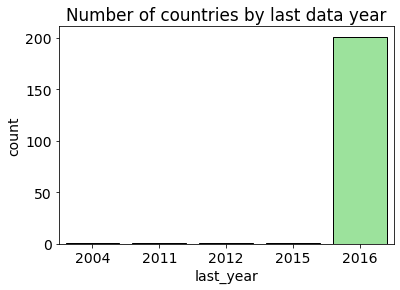

In [31]:
sns.countplot(x=internetusersdata.last_year.sort_values(), color='lightgreen', edgecolor='black')
plt.title('Number of countries by last data year');

First thing we see is that almost all countries have recent data so that's a good point. We also saw that the internet acces rate is globally growing through years, so for the few countries with older data we will pick the last data we have as a bottom line. Worst case scenario they should have the same rate.

In [32]:
internetusersdata = internetusersdata.fillna(axis = 1, method = 'ffill')

Now that we made a preselection and a bit of cleaning in our data, we can check the mean of the indicator for the last year. We saw earlier it was about 50% but least calculate it. We'll also select only country which are above that value in order to keep the countries with the best internet acces.

In [33]:
meanintdata = internetusersdata['2016'].mean()
internetusersdatafiltered = internetusersdata[internetusersdata['2016'] > meanintdata]
internetusersdatafiltered

country name country code                   indicator name  \
96665                 albania          alb  internet users (per 100 people)   
107660                andorra          and  internet users (per 100 people)   
114990    antigua and barbuda          atg  internet users (per 100 people)   
118655              argentina          arg  internet users (per 100 people)   
122320                armenia          arm  internet users (per 100 people)   
...                       ...          ...                              ...   
847990          united states          usa  internet users (per 100 people)   
851655                uruguay          ury  internet users (per 100 people)   
862650          venezuela, rb          ven  internet users (per 100 people)   
869980  virgin islands (u.s.)          vir  internet users (per 100 people)   
873645     west bank and gaza          pse  internet users (per 100 people)   

        indicator code            1996            1997            1998  \
96665   it.net.user.p2        0.032197        0.048594        0.065027   
107660  it.net.user.p2        1.526601        3.050175        6.886209   
114990  it.net.user.p2         2.85845        3.480537        4.071716   
118655  it.net.user.p2        0.141955         0.28034        0.830767   
122320  it.net.user.p2        0.094573        0.111651        0.128659   
...                ...             ...             ...             ...   
847990  it.net.user.p2       16.419353       21.616401       30.093197   
851655  it.net.user.p2        1.847472         3.36324        6.987069   
862650  it.net.user.p2        0.248261        0.390959         1.38399   
869980  it.net.user.p2        4.647186        6.948369         9.24522   
873645  it.net.user.p2  it.net.user.p2  it.net.user.p2  it.net.user.p2   

                  1999       2000       2001  ...      2009   2010       2011  \
96665         0.081437   0.114097   0.325798  ...      41.2   45.0       49.0   
107660        7.635686  10.538836  10.538836  ...     78.53   81.0       81.0   
114990        5.300681   6.482226   8.899286  ...      42.0   47.0       52.0   
118655        3.284482   7.038683   9.780807  ...      34.0   45.0       51.0   
122320        0.970738    1.30047   1.631095  ...      15.3   25.0       32.0   
...                ...        ...        ...  ...       ...    ...        ...   
847990       35.848724  43.079163  49.080832  ...      71.0  71.69  69.729461   
851655        9.972765  10.539058  11.121438  ...      41.8   46.4  51.404661   
862650        2.839826   3.359597   4.636001  ...      32.7  37.37      40.22   
869980       11.074606  13.815081  18.375766  ...  27.39651  31.22       35.6   
873645  it.net.user.p2   1.111306   1.836855  ...     32.23   37.4      41.08   

             2012   2013       2014       2015       2016 nombre_années_data  \
96665   54.655959   57.2       60.1  63.252933  66.363445                 21   
107660  86.434425   94.0       95.9      96.91  97.930637                 20   
114990       58.0   63.4      67.78       70.0       73.0                 21   
118655       55.8   59.9       64.7  68.043064  70.150764                 21   
122320       37.5   41.9  54.622806  59.102378       62.0                 21   
...           ...    ...        ...        ...        ...                ...   
847990       74.7   71.4       73.0  74.554202  76.176737                 21   
851655  54.453769  57.69      61.46       64.6       66.4                 21   
862650  49.050083   54.9       57.0  61.869248       60.0                 21   
869980    40.5479   45.3      50.07  54.839137  59.608316                 21   
873645       43.4   46.6      53.67  57.424192  61.178385                 17   

       last_year  
96665       2016  
107660      2016  
114990      2016  
118655      2016  
122320      2016  
...          ...  
847990      2016  
851655      2016  
862650      2016  
869980      2016  
873645      2016  

[107 rows x 27 c

We can now keep only what's interresting us, the last data, the year of last data, and the name/code of country and the indicator

In [34]:
internetusersdatafiltered = internetusersdatafiltered.loc[:,("country name","country code", "indicator name", "indicator code", "2016", "last_year")]

In [35]:
internetusersdatafiltered.rename(columns={'2016':'last data'}, inplace=True)

In [36]:
internetusersdatafiltered.head()

country name country code                   indicator name  \
96665               albania          alb  internet users (per 100 people)   
107660              andorra          and  internet users (per 100 people)   
114990  antigua and barbuda          atg  internet users (per 100 people)   
118655            argentina          arg  internet users (per 100 people)   
122320              armenia          arm  internet users (per 100 people)   

        indicator code  last data last_year  
96665   it.net.user.p2  66.363445      2016  
107660  it.net.user.p2  97.930637      2016  
114990  it.net.user.p2       73.0      2016  
118655  it.net.user.p2  70.150764      2016  
122320  it.net.user.p2       62.0      2016

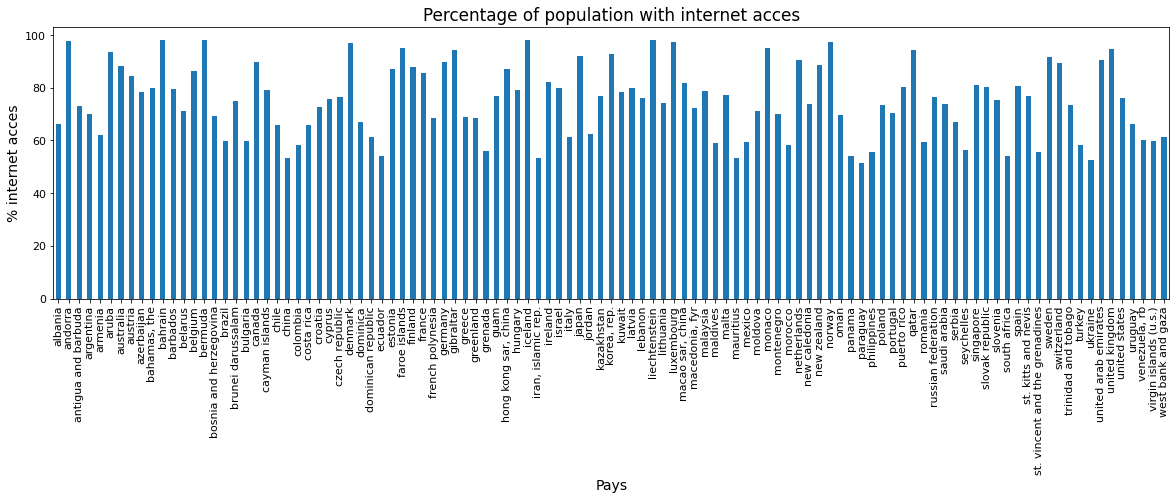

In [37]:
ax = internetusersdatafiltered.plot(kind = 'bar',
                               x='country name', y='last data',
                               xlabel = 'Pays', ylabel = "% internet acces",
                               figsize = [20,5], fontsize=11)
ax.get_legend().remove()
plt.title('Percentage of population with internet acces');

# Looking for educational indicators

Now that we have a selection of countries based on the internet acces indicator, we can start looking at other relevant indicators such as indicators related to study levels. We can look for secondary and tertiary level of eduction. We'll kinda use the same process that we did for the internet acces indicator so let's make a function base on this. But before that let's take a look at educational indicators. for the secondary level for example.

In [38]:
def find_indicator(indicator_theme):
    
    # Looking for indicator
    df_series = series[(series['topic'].str.contains(indicator_theme)) |
                       (series['indicator name'].str.contains(indicator_theme)) |
                       (series['short definition'].str.contains(indicator_theme)) |
                       (series['long definition'].str.contains(indicator_theme))]
    
    return df_series

## Secondary education

In [39]:
seriessecondary = find_indicator("upper secondary")
seriessecondary

series code              topic  \
1184      lo.pasec.mat.2.pri.gap  learning outcomes   
1185       lo.pasec.mat.2.ru.gap  learning outcomes   
1209      lo.pasec.mat.6.pri.gap  learning outcomes   
1210       lo.pasec.mat.6.ru.gap  learning outcomes   
1252      lo.pasec.rea.2.pri.gap  learning outcomes   
...                          ...                ...   
3637    uis.xunit.gdpcap.3.fsgov       expenditures   
3642       uis.xunit.ppp.3.fsgov       expenditures   
3648  uis.xunit.pppconst.3.fsgov       expenditures   
3654        uis.xunit.us.3.fsgov       expenditures   
3660   uis.xunit.usconst.3.fsgov       expenditures   

                                         indicator name  \
1184  pasec: average performance gap between 2nd gra...   
1185  pasec: average performance gap between 2nd gra...   
1209  pasec: average performance gap between 6th gra...   
1210  pasec: average performance gap between 6th gra...   
1252  pasec: average performance gap between 2nd gra...   
...                                                 ...   
3637  government expenditure per upper secondary stu...   
3642  government expenditure per upper secondary stu...   
3648  government expenditure per upper secondary stu...   
3654  government expenditure per upper secondary stu...   
3660  government expenditure per upper secondary stu...   

                                       short definition  \
1184  average difference between pupil scores in pri...   
1185  average difference between pupil scores in rur...   
1209  average difference between pupil scores in pri...   
1210  average difference between pupil scores in rur...   
1252  average difference between pupil scores in pri...   
...                                                 ...   
3637                                                NaN   
3642                                                NaN   
3648                                                NaN   
3654                                                NaN   
3660                                                NaN   

                                        long definition  \
1184  average difference between pupil scores in pri...   
1185  average difference between pupil scores in rur...   
1209  average difference between pupil scores in pri...   
1210  average difference between pupil scores in rur...   
1252  average difference between pupil scores in pri...   
...                                                 ...   
3637  average total (current, capital and transfers)...   
3642  average total (current, capital and transfers)...   
3648  average total (current, capital and transfers)...   
3654  average total (current, capital and transfers)...   
3660  average total (current, capital and transfers)...   

                                                 source  
1184  programme d'analyse des systèmes educatifs de ...  
1185  programme d'analyse des systèmes educatifs de ...  
1209  programme d'analyse des systèmes educatifs de ...  
1210  programme d'analyse des systèmes educatifs de ...  
1252  programme d'analyse des systèmes educatifs de ...  
...                                                 ...  
3637                    unesco institute for statistics  
3642                    unesco institute for statistics  
3648                    unesco institute for statistics  
3654                    unesco institute for statistics  
3660                    unesco institute for statistics  

[190 rows x 6 columns]

Let's have a lot at the different indicator names in the topics that seem usefull.

In [40]:
seriessecondary['topic'].unique()

array(['learning outcomes', 'teachers', 'attainment', 'secondary',
       'social protection & labor: labor force structure', 'population',
       'expenditures'], dtype=object)

In [41]:
seriessecondary[seriessecondary['topic']=='secondary']['indicator name'].unique()

array(['theoretical duration of upper secondary education (years)',
       'gross enrolment ratio, upper secondary, both sexes (%)',
       'gross enrolment ratio, upper secondary, female (%)',
       'gross enrolment ratio, upper secondary, male (%)',
       'enrolment in upper secondary education, both sexes (number)',
       'enrolment in upper secondary education, female (number)',
       'enrolment in upper secondary general, both sexes (number)',
       'enrolment in upper secondary general, female (number)',
       'enrolment in upper secondary education, private institutions, both sexes (number)',
       'enrolment in upper secondary education, private institutions, female (number)',
       'enrolment in upper secondary education, public institutions, both sexes (number)',
       'enrolment in upper secondary education, public institutions, female (number)',
       'enrolment in upper secondary vocational, both sexes (number)',
       'enrolment in upper secondary vocational, f

In [42]:
seriessecondary[seriessecondary['topic']=='attainment']['indicator name'].unique()
# Lot of projection so not actual data.

array(['projection: percentage of the population age 15-19 by highest level of educational attainment. lower secondary. female',
       'projection: percentage of the population age 15-19 by highest level of educational attainment. lower secondary. male',
       'projection: percentage of the population age 15-19 by highest level of educational attainment. lower secondary. total',
       'projection: percentage of the population age 15-19 by highest level of educational attainment. upper secondary. female',
       'projection: percentage of the population age 15-19 by highest level of educational attainment. upper secondary. male',
       'projection: percentage of the population age 15-19 by highest level of educational attainment. upper secondary. total',
       'projection: percentage of the population age 15+ by highest level of educational attainment. lower secondary. female',
       'projection: percentage of the population age 15+ by highest level of educational attainment. lowe

In [43]:
seriessecondary[seriessecondary['topic']=='population']['indicator name'].unique()

array(['population of the official age for upper secondary education, female (number)',
       'population of the official age for upper secondary education, both sexes (number)',
       'population of the official age for upper secondary education, male (number)'],
      dtype=object)

In [52]:
# The enrollment number seems interresting, let's see what's is about.
seriessecondary[seriessecondary['indicator name']=='enrolment in upper secondary education, both sexes (number)']['long definition'].values[0]

'total number of students enrolled in public and private upper secondary education institutions regardless of age.'

The total number of students enrolled in upper secondary education institutions is interesting because we want to target countries with the biggest population available first but we also need to check that there is enough educated people. We'll check via the infos the non-null count in order to see if we have enough data to work with. We'll also check for the enrolment ratio and population number to see if we have more data just in case.

In [53]:
seriessecondary[seriessecondary['indicator name']=='enrolment in upper secondary education, both sexes (number)']

series code      topic  \
2825     uis.e.3  secondary   

                                         indicator name short definition  \
2825  enrolment in upper secondary education, both s...              NaN   

                                        long definition  \
2825  total number of students enrolled in public an...   

                               source  
2825  unesco institute for statistics

In [45]:
def value_count(indicator_code):
    
    df = datacountries[datacountries['indicator code']==indicator_code].count()

    sns.barplot(x=df.index, y=df.values)
    plt.xticks(rotation=90)
    plt.title('Number of data by column');
    
    pass

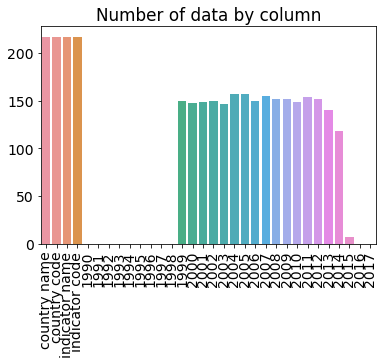

In [46]:
value_count('uis.e.3')

In [55]:
datacountries[datacountries['indicator code']=='uis.e.3'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 92839 to 884479
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country name    217 non-null    object 
 1   country code    217 non-null    object 
 2   indicator name  217 non-null    object 
 3   indicator code  217 non-null    object 
 4   1990            0 non-null      float64
 5   1991            0 non-null      float64
 6   1992            0 non-null      float64
 7   1993            0 non-null      float64
 8   1994            0 non-null      float64
 9   1995            0 non-null      float64
 10  1996            0 non-null      float64
 11  1997            0 non-null      float64
 12  1998            0 non-null      float64
 13  1999            150 non-null    float64
 14  2000            148 non-null    float64
 15  2001            149 non-null    float64
 16  2002            150 non-null    float64
 17  2003            146 non-null

In [56]:
seriessecondary[seriessecondary['indicator name']=='gross enrolment ratio, upper secondary, both sexes (%)']

series code      topic  \
2313  se.sec.enrr.up  secondary   

                                         indicator name short definition  \
2313  gross enrolment ratio, upper secondary, both s...              NaN   

                                        long definition  \
2313  total enrollment in upper secondary education,...   

                               source  
2313  unesco institute for statistics

In [51]:
#apercu des data pour cet indicateur pour voir si on a quand meme assez de données
datacountries[datacountries['indicator code']=='se.sec.enrr.up'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 92968 to 884608
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country name    217 non-null    object 
 1   country code    217 non-null    object 
 2   indicator name  217 non-null    object 
 3   indicator code  217 non-null    object 
 4   1990            2 non-null      float64
 5   1991            7 non-null      float64
 6   1992            5 non-null      float64
 7   1993            19 non-null     float64
 8   1994            37 non-null     float64
 9   1995            56 non-null     float64
 10  1996            72 non-null     float64
 11  1997            54 non-null     float64
 12  1998            92 non-null     float64
 13  1999            144 non-null    float64
 14  2000            140 non-null    float64
 15  2001            144 non-null    float64
 16  2002            146 non-null    float64
 17  2003            142 non-null

In [57]:
seriessecondary[seriessecondary['indicator name']=='population of the official age for upper secondary education, both sexes (number)']

series code       topic  \
2611  sp.sec.utot.in  population   

                                         indicator name short definition  \
2611  population of the official age for upper secon...              NaN   

                                        long definition  \
2611  population of the age-group theoretically corr...   

                               source  
2611  unesco institute for statistics

In [48]:
datacountries[datacountries['indicator code']=='sp.sec.utot.in'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 93957 to 885597
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country name    217 non-null    object 
 1   country code    217 non-null    object 
 2   indicator name  217 non-null    object 
 3   indicator code  217 non-null    object 
 4   1990            188 non-null    float64
 5   1991            188 non-null    float64
 6   1992            188 non-null    float64
 7   1993            188 non-null    float64
 8   1994            188 non-null    float64
 9   1995            188 non-null    float64
 10  1996            188 non-null    float64
 11  1997            189 non-null    float64
 12  1998            190 non-null    float64
 13  1999            190 non-null    float64
 14  2000            190 non-null    float64
 15  2001            192 non-null    float64
 16  2002            194 non-null    float64
 17  2003            194 non-null

In [ ]:
# Function based on the p^rocess we used for the internet acces indicator : selecting data based on indicator code, selecting relevant years, addin number of years with data

def select_data_indicator(indicator_code, first_year, _last_year):
    
    # Creating dataframe of data for that indicator 
    df_data =  datacountries[datacountries['indicator code']==indicator_code].copy()
    
    # Let's already preselectect the last 20 years (we'll drop 2017 as there is only few data this year)
    df_data = masque_année(data,first_year,last_year)
    
    df_data["nombre_années_data"] = df_data.drop(["country name", "country code", "indicator name", "indicator code"], axis = 1).notna().sum(axis=1)
    df_data = df_data[df_data["nombre_années_data"]>0]
    
    

return df_data

In [87]:
datasecondary = datapayspresent[datapayspresent['Indicator Code']=='SE.SEC.ENRR.UP']

In [88]:
datasecondary.head()

Country Name Country Code  \
92968      Afghanistan          AFG   
96633          Albania          ALB   
100298         Algeria          DZA   
103963  American Samoa          ASM   
107628         Andorra          AND   

                                           Indicator Name  Indicator Code  \
92968   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
96633   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
100298  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
103963  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
107628  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   

        1970  1971  1972  1973  1974  1975  ...       2009       2010  \
92968    NaN   NaN   NaN   NaN   NaN   NaN  ...  26.050900  32.134010   
96633    NaN   NaN   NaN   NaN   NaN   NaN  ...  72.855003  78.937408   
100298   NaN   NaN   NaN   NaN   NaN   NaN  ...  49.466370  59.457081   
103963   NaN   NaN   NaN   NaN   NaN   NaN  ...        NaN        NaN   
107628   NaN   NaN   NaN   NaN   NaN   NaN  ...        NaN        NaN   

             2011       2012       2013       2014       2015  2016  2017  \
92968   39.862740  44.565182  46.262440  43.905590  42.613129   NaN   NaN   
96633   86.112183  89.405228  93.003021  93.927422  89.460274   NaN   NaN   
100298  62.721142        NaN        NaN        NaN        NaN   NaN   NaN   
103963        NaN        NaN        NaN        NaN        NaN   NaN   NaN   
107628        NaN        NaN        NaN        NaN        NaN   NaN   NaN   

        2020  
92968    NaN  
96633    NaN  
100298   NaN  
103963   NaN  
107628   NaN  

[5 rows x 53 columns]

In [89]:
secondaryannées = datasecondary.drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis = 1)

In [90]:
secondaryannées

1970  1971  1972  1973  1974  1975  1976  1977  1978  1979  ...  \
92968    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
96633    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
100298   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
103963   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
107628   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
869948   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
873613   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
877278   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
880943   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
884608   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

             2009       2010       2011       2012       2013       2014  \
92968   26.050900  32.134010  39.862740  44.565182  46.262440  43.905590   
96633   72.855003  78.937408  86.112183  89.405228  93.003021  93.927422   
100298  49.466370  59.457081  62.721142        NaN        NaN        NaN   
103963        NaN        NaN        NaN        NaN        NaN        NaN   
107628        NaN        NaN        NaN        NaN        NaN        NaN   
...           ...        ...        ...        ...        ...        ...   
869948        NaN        NaN        NaN        NaN        NaN        NaN   
873613  77.343872  77.870872  74.475357  73.109650  70.819107  67.763283   
877278        NaN  32.760502  34.722691  36.202332  38.942299        NaN   
880943        NaN        NaN        NaN        NaN        NaN        NaN   
884608        NaN        NaN        NaN  36.237690  36.963619        NaN   

             2015  2016  2017  2020  
92968   42.613129   NaN   NaN   NaN  
96633   89.460274   NaN   NaN   NaN  
100298        NaN   NaN   NaN   NaN  
103963        NaN   NaN   NaN   NaN  
107628        NaN   NaN   NaN   NaN  
...           ...   ...   ...   ...  
869948        NaN   NaN   NaN   NaN  
873613  66.222519   NaN   NaN   NaN  
877278        NaN   NaN   NaN   NaN  
880943        NaN   NaN   NaN   NaN  
884608        NaN   NaN   NaN   NaN  

[217 rows x 49 columns]

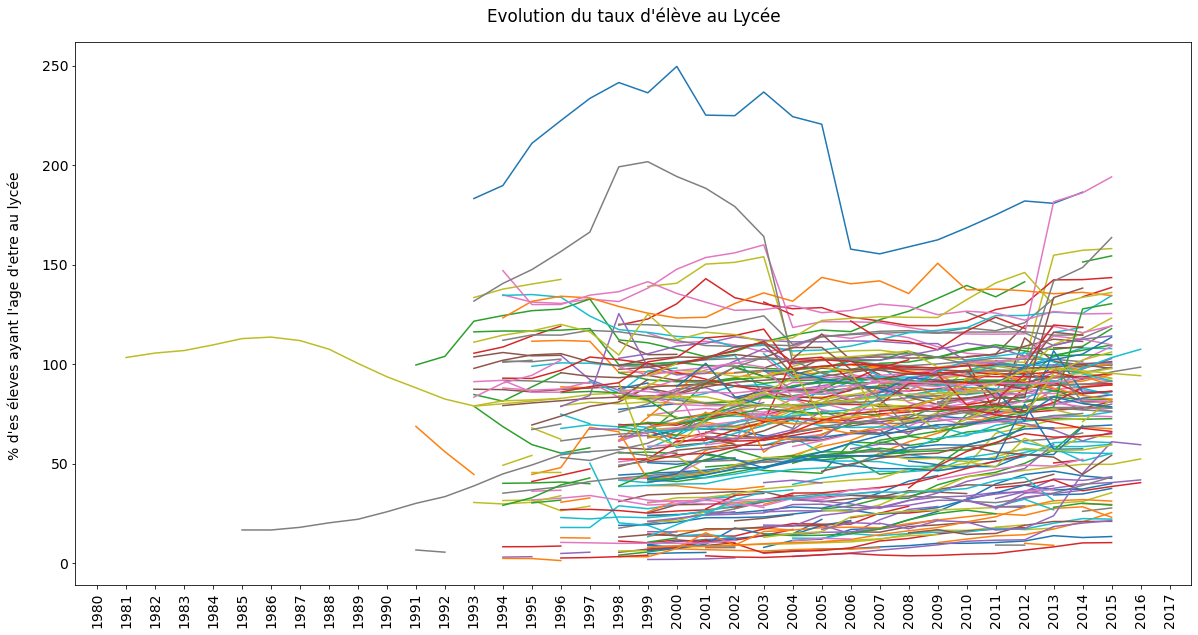

In [91]:
#visualisation rapide des données
evolutionpaysannées(datasecondary,secondaryannées, titre = "Evolution du taux d'élève au Lycée", axe_y = "% d'es éleves ayant l'age d'etre au lycée ")

In [92]:
#il commence à y avoir des données vers 1993, donc masquer années d'avant
datasecondary = masque_année(datasecondary, 1970, 1992)
secondaryannées = masque_année(secondaryannées, 1970, 1992)

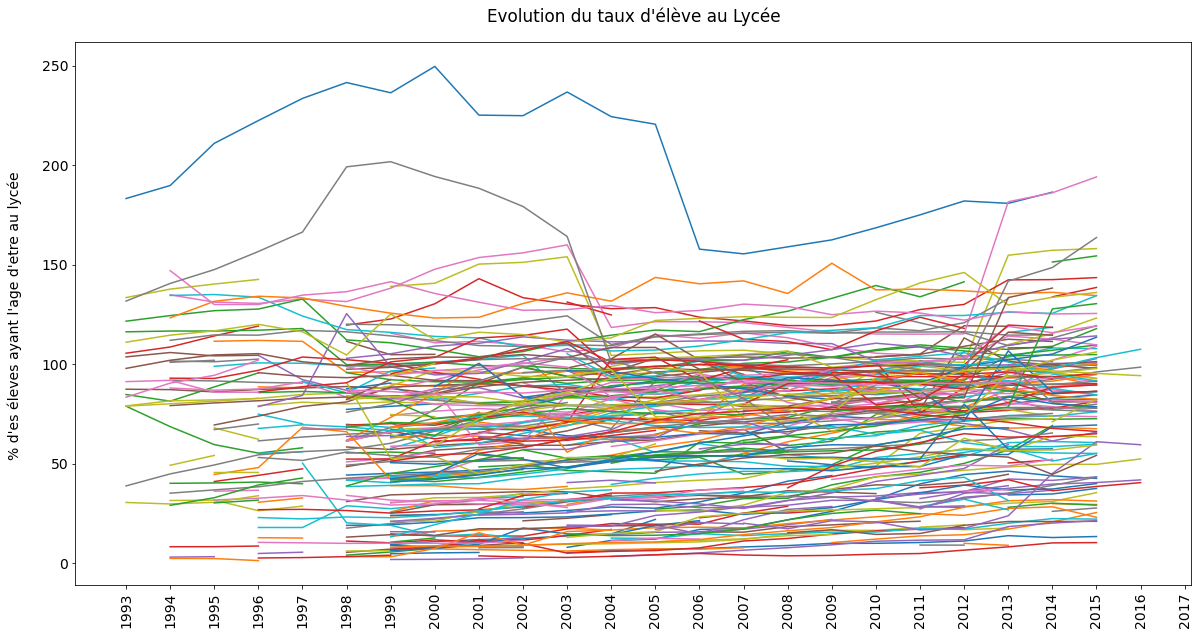

In [93]:
evolutionpaysannées(datasecondary,secondaryannées, titre = "Evolution du taux d'élève au Lycée", axe_y = "% d'es éleves ayant l'age d'etre au lycée ")

In [94]:
datasecondary["nombre données"] = secondaryannées.notna().sum(axis =1)

In [95]:
datasecondary.head()

Country Name Country Code  \
92968      Afghanistan          AFG   
96633          Albania          ALB   
100298         Algeria          DZA   
103963  American Samoa          ASM   
107628         Andorra          AND   

                                           Indicator Name  Indicator Code  \
92968   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
96633   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
100298  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
103963  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
107628  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   

        1993       1994       1995       1996       1997       1998  ...  \
92968    NaN        NaN        NaN        NaN        NaN        NaN  ...   
96633    NaN        NaN        NaN        NaN        NaN  41.849659  ...   
100298   NaN  40.153851  40.338669  40.784031  39.941818        NaN  ...   
103963   NaN        NaN        NaN        NaN        NaN        NaN  ...   
107628   NaN        NaN        NaN        NaN        NaN        NaN  ...   

             2010       2011       2012       2013       2014       2015  \
92968   32.134010  39.862740  44.565182  46.262440  43.905590  42.613129   
96633   78.937408  86.112183  89.405228  93.003021  93.927422  89.460274   
100298  59.457081  62.721142        NaN        NaN        NaN        NaN   
103963        NaN        NaN        NaN        NaN        NaN        NaN   
107628        NaN        NaN        NaN        NaN        NaN        NaN   

        2016  2017  2020  nombre données  
92968    NaN   NaN   NaN              14  
96633    NaN   NaN   NaN              18  
100298   NaN   NaN   NaN              17  
103963   NaN   NaN   NaN               0  
107628   NaN   NaN   NaN               0  

[5 rows x 31 columns]

In [96]:
datasecondary = datasecondary[datasecondary['nombre données']>0]

In [97]:
datasecondary

Country Name Country Code  \
92968           Afghanistan          AFG   
96633               Albania          ALB   
100298              Algeria          DZA   
111293               Angola          AGO   
114958  Antigua and Barbuda          ATG   
...                     ...          ...   
862618        Venezuela, RB          VEN   
866283              Vietnam          VNM   
873613   West Bank and Gaza          PSE   
877278          Yemen, Rep.          YEM   
884608             Zimbabwe          ZWE   

                                           Indicator Name  Indicator Code  \
92968   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
96633   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
100298  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
111293  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
114958  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
...                                                   ...             ...   
862618  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
866283  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
873613  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
877278  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
884608  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   

        1993       1994       1995       1996       1997       1998  ...  \
92968    NaN        NaN        NaN        NaN        NaN        NaN  ...   
96633    NaN        NaN        NaN        NaN        NaN  41.849659  ...   
100298   NaN  40.153851  40.338669  40.784031  39.941818        NaN  ...   
111293   NaN        NaN        NaN        NaN        NaN   5.486110  ...   
114958   NaN        NaN        NaN        NaN        NaN        NaN  ...   
...      ...        ...        ...        ...        ...        ...  ...   
862618   NaN        NaN        NaN        NaN        NaN        NaN  ...   
866283   NaN        NaN        NaN        NaN        NaN  32.187649  ...   
873613   NaN        NaN  41.051949  44.165878  47.415798        NaN  ...   
877278   NaN        NaN        NaN        NaN        NaN        NaN  ...   
884608   NaN        NaN        NaN        NaN        NaN        NaN  ...   

             2010       2011       2012       2013       2014       2015  \
92968   32.134010  39.862740  44.565182  46.262440  43.905590  42.613129   
96633   78.937408  86.112183  89.405228  93.003021  93.927422  89.460274   
100298  59.457081  62.721142        NaN        NaN        NaN        NaN   
111293  20.399860  21.098619        NaN        NaN        NaN        NaN   
114958  80.234032  84.061623  92.682159        NaN  82.103607  82.024597   
...           ...        ...        ...        ...        ...        ...   
862618  69.890633  71.930923  74.508591  83.598793  80.224281  78.629623   
866283        NaN        NaN        NaN        NaN        NaN        NaN   
873613  77.870872  74.475357  73.109650  70.819107  67.763283  66.222519   
877278  32.760502  34.722691  36.202332  38.942299        NaN        NaN   
884608        NaN        NaN  36.237690  36.963619        NaN        NaN   

        2016  2017  2020  nombre données  
92968    NaN   NaN   NaN              14  
96633    NaN   NaN   NaN              18  
100298   NaN   NaN   NaN              17  
111293   NaN   NaN   NaN              11  
114958   NaN   NaN   NaN               8  
...      ...   ...   ...             ...  
862618   NaN   NaN   NaN              17  
866283   NaN   NaN   NaN               1  
873613   NaN   NaN   NaN              20  
877278   NaN   NaN   NaN              10  
884608   NaN   NaN   NaN               7  

[195 rows x 31 columns]

In [98]:
datasecondary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 92968 to 884608
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    195 non-null    object 
 1   Country Code    195 non-null    object 
 2   Indicator Name  195 non-null    object 
 3   Indicator Code  195 non-null    object 
 4   1993            19 non-null     float64
 5   1994            37 non-null     float64
 6   1995            56 non-null     float64
 7   1996            72 non-null     float64
 8   1997            54 non-null     float64
 9   1998            92 non-null     float64
 10  1999            144 non-null    float64
 11  2000            140 non-null    float64
 12  2001            144 non-null    float64
 13  2002            146 non-null    float64
 14  2003            142 non-null    float64
 15  2004            152 non-null    float64
 16  2005            153 non-null    float64
 17  2006            145 non-null

In [99]:
#moyenne de l'année la plus remplie comme filtre ?
datasecondary['2011'].mean()

72.69574336369833

In [100]:
#filtrer sur années plus récentes
datasecondary = masque_année(datasecondary, 1993, 2004)

In [101]:
secondaryannées = masque_année(secondaryannées, 1993, 2004)

In [102]:
#enlever les pays sans donnée
datasecondary["nombre données"] = secondaryannées.notna().sum(axis =1)
datasecondary = datasecondary[datasecondary['nombre données']>0]

In [103]:
derniereannée(datasecondary, secondaryannées)

In [104]:
#remplir en prenant derniere valeure non NaN
datasecondarycomplété = datasecondary.fillna(axis = 1, method = 'ffill')

In [105]:
datasecondarycomplété = datasecondarycomplété[["Country Name", "Country Code", "Indicator Name", "Indicator Code", "2020","Année Last Data"]]

In [106]:
datasecondarycomplété

Country Name Country Code  \
92968           Afghanistan          AFG   
96633               Albania          ALB   
100298              Algeria          DZA   
111293               Angola          AGO   
114958  Antigua and Barbuda          ATG   
...                     ...          ...   
858953              Vanuatu          VUT   
862618        Venezuela, RB          VEN   
873613   West Bank and Gaza          PSE   
877278          Yemen, Rep.          YEM   
884608             Zimbabwe          ZWE   

                                           Indicator Name  Indicator Code  \
92968   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
96633   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
100298  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
111293  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
114958  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
...                                                   ...             ...   
858953  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
862618  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
873613  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
877278  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
884608  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   

           2020 Année Last Data  
92968   42.6131            2015  
96633   89.4603            2015  
100298  62.7211            2011  
111293  21.0986            2011  
114958  82.0246            2015  
...         ...             ...  
858953  34.1657            2015  
862618  78.6296            2015  
873613  66.2225            2015  
877278  38.9423            2013  
884608  36.9636            2013  

[189 rows x 6 columns]

In [107]:
#convertir en float car avec fillna tout est en object
datasecondarycomplété["2020"].astype(float).describe()

count    189.000000
mean      75.472834
std       36.503816
min        5.020860
25%       44.063599
50%       79.926109
75%       98.463112
max      194.101990
Name: 2020, dtype: float64

In [108]:
#choix des pays au dessus de la mediane (on pourrait colonne.median() pour etre plus precis que 80)
datasecondarycomplétéfiltré = datasecondarycomplété[datasecondarycomplété["2020"]>80]

In [109]:
datasecondarycomplétéfiltré

Country Name Country Code  \
96633               Albania          ALB   
114958  Antigua and Barbuda          ATG   
118623            Argentina          ARG   
122288              Armenia          ARM   
125953                Aruba          ABW   
...                     ...          ...   
836963              Ukraine          UKR   
844293       United Kingdom          GBR   
847958        United States          USA   
851623              Uruguay          URY   
855288           Uzbekistan          UZB   

                                           Indicator Name  Indicator Code  \
96633   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
114958  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
118623  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
122288  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
125953  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
...                                                   ...             ...   
836963  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
844293  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
847958  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
851623  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
855288  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   

           2020 Année Last Data  
96633   89.4603            2015  
114958  82.0246            2015  
118623  85.2326            2014  
122288   89.927            2015  
125953  106.326            2012  
...         ...             ...  
836963  92.6492            2014  
844293  138.236            2014  
847958  93.2866            2014  
851623  80.9065            2014  
855288  94.2327            2016  

[94 rows x 6 columns]

In [110]:
datasecondarycomplétéfiltré = datasecondarycomplétéfiltré.rename(columns={'2020':'Last Data'})

In [111]:
datasecondarycomplétéfiltré

Country Name Country Code  \
96633               Albania          ALB   
114958  Antigua and Barbuda          ATG   
118623            Argentina          ARG   
122288              Armenia          ARM   
125953                Aruba          ABW   
...                     ...          ...   
836963              Ukraine          UKR   
844293       United Kingdom          GBR   
847958        United States          USA   
851623              Uruguay          URY   
855288           Uzbekistan          UZB   

                                           Indicator Name  Indicator Code  \
96633   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
114958  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
118623  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
122288  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
125953  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
...                                                   ...             ...   
836963  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
844293  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
847958  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
851623  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
855288  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   

       Last Data Année Last Data  
96633    89.4603            2015  
114958   82.0246            2015  
118623   85.2326            2014  
122288    89.927            2015  
125953   106.326            2012  
...          ...             ...  
836963   92.6492            2014  
844293   138.236            2014  
847958   93.2866            2014  
851623   80.9065            2014  
855288   94.2327            2016  

[94 rows x 6 columns]

In [112]:
#merge pour pouvoir faire filtre des 80 sur last data sur le tableau avec toutes les données sur les années étudiées
result = pd.merge(datasecondary, datasecondarycomplétéfiltré, on= ["Country Name", "Country Code", "Indicator Name", "Indicator Code"])

In [113]:
result.head()

Country Name Country Code  \
0              Albania          ALB   
1  Antigua and Barbuda          ATG   
2            Argentina          ARG   
3              Armenia          ARM   
4                Aruba          ABW   

                                      Indicator Name  Indicator Code  \
0  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
1  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
2  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
3  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
4  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   

        2005       2006       2007       2008       2009       2010  ...  \
0  58.653580  61.681122  67.139008  71.086517  72.855003  78.937408  ...   
1        NaN        NaN        NaN  84.973579  83.665588  80.234032  ...   
2  70.882759  70.444328  70.151070  70.334778  71.492264  72.968208  ...   
3  80.493149  88.926552  94.841217  86.682053  94.905457  97.065437  ...   
4  84.785622  86.693459  98.751671  89.368263  86.303452  84.642014  ...   

        2013       2014       2015  2016  2017  2020  nombre données  \
0  93.003021  93.927422  89.460274   NaN   NaN   NaN              11   
1        NaN  82.103607  82.024597   NaN   NaN   NaN               7   
2  83.847839  85.232620        NaN   NaN   NaN   NaN              10   
3  83.753754  88.147781  89.926964   NaN   NaN   NaN              10   
4        NaN        NaN        NaN   NaN   NaN   NaN               8   

   Année Last Data_x  Last Data Année Last Data_y  
0               2015    89.4603              2015  
1               2015    82.0246              2015  
2               2014    85.2326              2014  
3               2015     89.927              2015  
4               2012    106.326              2012  

[5 rows x 22 columns]

In [114]:
datasecondaryfiltré = result[result["Last Data"]>80]

In [115]:
datasecondaryfiltré

Country Name Country Code  \
0               Albania          ALB   
1   Antigua and Barbuda          ATG   
2             Argentina          ARG   
3               Armenia          ARM   
4                 Aruba          ABW   
..                  ...          ...   
89              Ukraine          UKR   
90       United Kingdom          GBR   
91        United States          USA   
92              Uruguay          URY   
93           Uzbekistan          UZB   

                                       Indicator Name  Indicator Code  \
0   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
1   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
2   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
3   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
4   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
..                                                ...             ...   
89  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
90  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
91  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
92  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
93  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   

          2005        2006       2007       2008       2009       2010  ...  \
0    58.653580   61.681122  67.139008  71.086517  72.855003  78.937408  ...   
1          NaN         NaN        NaN  84.973579  83.665588  80.234032  ...   
2    70.882759   70.444328  70.151070  70.334778  71.492264  72.968208  ...   
3    80.493149   88.926552  94.841217  86.682053  94.905457  97.065437  ...   
4    84.785622   86.693459  98.751671  89.368263  86.303452  84.642014  ...   
..         ...         ...        ...        ...        ...        ...  ...   
89  102.269920  101.441917  99.076500  96.152580  94.820892  79.610558  ...   
90  108.413727   97.463882  96.942749  94.990494  94.254417  96.510201  ...   
91   88.262627   89.273300  90.800430  91.170181  90.337898  89.450058  ...   
92   95.474792   92.857193  82.867310  67.710869  67.820541  70.550713  ...   
93   73.589119   73.350166  78.093330  77.767052  83.247337  86.202499  ...   

          2013        2014       2015       2016  2017  2020  nombre données  \
0    93.003021   93.927422  89.460274        NaN   NaN   NaN              11   
1          NaN   82.103607  82.024597        NaN   NaN   NaN               7   
2    83.847839   85.232620        NaN        NaN   NaN   NaN              10   
3    83.753754   88.147781  89.926964        NaN   NaN   NaN              10   
4          NaN         NaN        NaN        NaN   NaN   NaN               8   
..         ...         ...        ...        ...   ...   ...             ...   
89   96.084732   92.649231        NaN        NaN   NaN   NaN              10   
90  133.473145  138.235916        NaN        NaN   NaN   NaN              10   
91   90.668663   93.286598        NaN        NaN   NaN   NaN              10   
92   99.427811   80.906548        NaN        NaN   NaN   NaN               8   
93   97.605331   96.658546  95.359306  94.232689   NaN   NaN              12   

    Année Last Data_x  Last Data Année Last Data_y  
0                2015    89.4603              2015  
1                2015    82.0246              2015  
2                2014    85.2326              2014  
3                2015     89.927              2015  
4                2012    106.326              2012  
..                ...        ...               ...  
89               2014    92.6492              2014  
90               2014    138.236              2014  
91               2014    93.2866              2014  
92               2014    80.9065              2014  
93               2016    94.2327              2016  

[94 rows x 22 columns]

## Université/tertiary

In [116]:
seriestertiary = series.copy()

In [117]:
seriestertiary = seriestertiary[seriestertiary['Topic'].str.contains("tertiary") | seriestertiary['Indicator Name'].str.contains("tertiary") | seriestertiary['Short definition'].str.contains("tertiary") | seriestertiary['Long definition'].str.contains("tertiary")]

In [118]:
seriestertiary['Topic'].unique()

array(['Attainment', 'Tertiary', 'Teachers', 'Expenditures',
       'Social Protection & Labor: Labor force structure', 'Population',
       'Post-Secondary/Non-Tertiary'], dtype=object)

In [119]:
seriestertiary[seriestertiary['Topic']=='Attainment']['Indicator Name'].unique()

array(['Barro-Lee: Percentage of female population age 15-19 with tertiary schooling. Completed Tertiary',
       'Barro-Lee: Percentage of population age 15-19 with tertiary schooling. Completed Tertiary',
       'Barro-Lee: Percentage of female population age 15+ with tertiary schooling. Completed Tertiary',
       'Barro-Lee: Percentage of population age 15+ with tertiary schooling. Completed Tertiary',
       'Barro-Lee: Percentage of female population age 20-24 with tertiary schooling. Completed Tertiary',
       'Barro-Lee: Percentage of population age 20-24 with tertiary schooling. Completed Tertiary',
       'Barro-Lee: Percentage of female population age 25-29 with tertiary schooling. Completed Tertiary',
       'Barro-Lee: Percentage of population age 25-29 with tertiary schooling. Completed Tertiary',
       'Barro-Lee: Percentage of female population age 25+ with tertiary schooling. Completed Tertiary',
       'Barro-Lee: Percentage of population age 25+ with tertiary schoo

In [120]:
seriestertiary[seriestertiary['Topic']=='Tertiary']['Indicator Name'].unique()

array(['Gross enrolment ratio, tertiary, gender parity index (GPI)',
       'School life expectancy, primary to tertiary, both sexes (years)',
       'School life expectancy, primary to tertiary, female (years)',
       'School life expectancy, primary to tertiary, male (years)',
       'Gross graduation ratio from first degree programmes (ISCED 6 and 7) in tertiary education, female (%)',
       'Gross graduation ratio from first degree programmes (ISCED 6 and 7) in tertiary education, male (%)',
       'Gross graduation ratio from first degree programmes (ISCED 6 and 7) in tertiary education, both sexes (%)',
       'Enrolment in tertiary education, all programmes, both sexes (number)',
       'Enrolment in tertiary education, all programmes, female (number)',
       'Percentage of students in tertiary education who are female (%)',
       'Gross enrolment ratio, tertiary, both sexes (%)',
       'Gross enrolment ratio, tertiary, female (%)',
       'Gross enrolment ratio, tertiary, 

In [121]:
seriestertiary[seriestertiary['Indicator Name']=='Gross enrolment ratio, tertiary, both sexes (%)']

Series Code     Topic                                   Indicator Name  \
2335  SE.TER.ENRR  Tertiary  Gross enrolment ratio, tertiary, both sexes (%)   

     Short definition                                    Long definition  \
2335              NaN  Total enrollment in tertiary education (ISCED ...   

     Periodicity Base Period Other notes Aggregation method  \
2335         NaN         NaN         NaN                NaN   

     Limitations and exceptions General comments  \
2335                        NaN              NaN   

                               Source Statistical concept and methodology  \
2335  UNESCO Institute for Statistics                                 NaN   

     Development relevance Related source links  
2335                   NaN                  NaN

In [122]:
datatertiary = datapayspresent[datapayspresent['Indicator Code']=='SE.TER.ENRR']

In [123]:
datatertiary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 92964 to 884604
Data columns (total 53 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Country Code    217 non-null    object 
 2   Indicator Name  217 non-null    object 
 3   Indicator Code  217 non-null    object 
 4   1970            35 non-null     float64
 5   1971            114 non-null    float64
 6   1972            104 non-null    float64
 7   1973            105 non-null    float64
 8   1974            101 non-null    float64
 9   1975            104 non-null    float64
 10  1976            103 non-null    float64
 11  1977            105 non-null    float64
 12  1978            106 non-null    float64
 13  1979            113 non-null    float64
 14  1980            112 non-null    float64
 15  1981            129 non-null    float64
 16  1982            115 non-null    float64
 17  1983            113 non-null

In [124]:
tertiaryannées = datatertiary.drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis = 1)

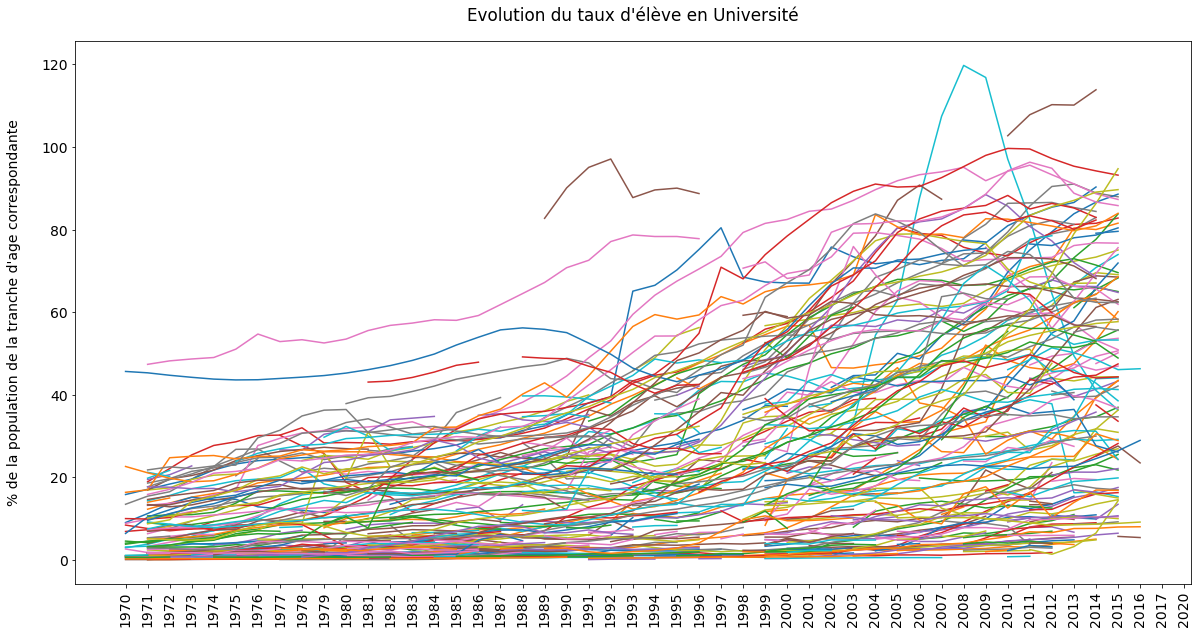

In [125]:
evolutionpaysannées(datatertiary,tertiaryannées, titre = "Evolution du taux d'élève en Université", axe_y = "% de la population de la tranche d'age correspondante")

In [126]:
datatertiary = masque_année(datatertiary, 1970, 1999)
tertiaryannées = masque_année(tertiaryannées, 1970, 1999)

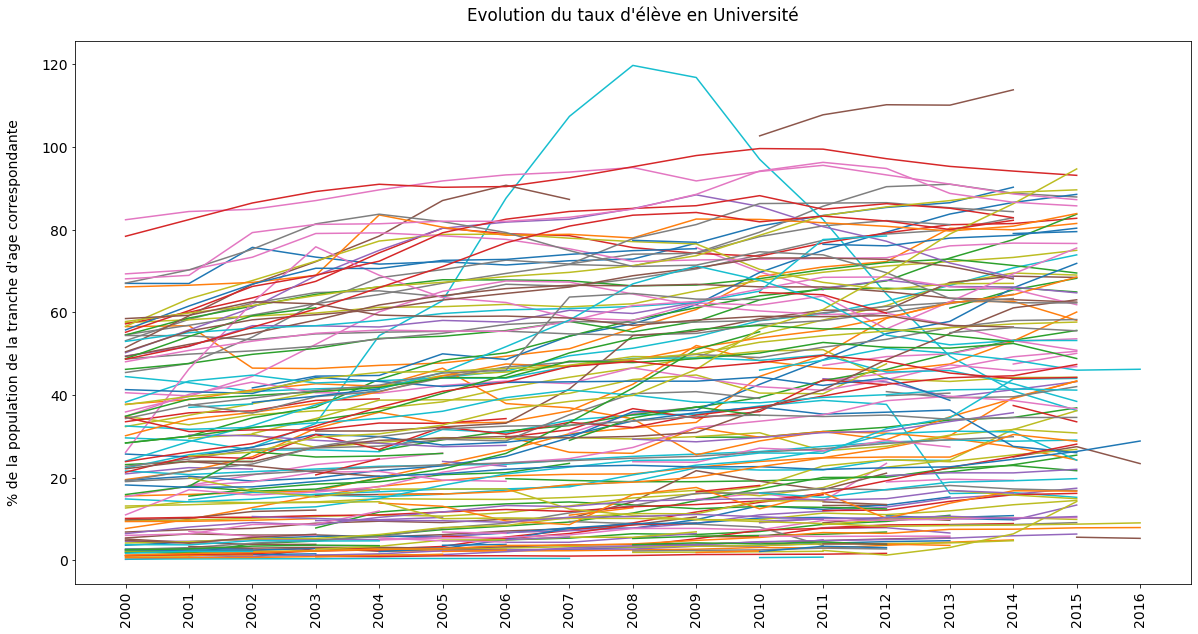

In [127]:
evolutionpaysannées(datatertiary,tertiaryannées,  titre = "Evolution du taux d'élève en Université", axe_y = "% de la population de la tranche d'age correspondante")

In [128]:
#filtre sur au moins une donnée
datatertiary["nombre données"] = tertiaryannées.notna().sum(axis =1)
datatertiary = datatertiary[datatertiary['nombre données']>0]

In [129]:
datatertiary

Country Name Country Code  \
92964           Afghanistan          AFG   
96629               Albania          ALB   
100294              Algeria          DZA   
111289               Angola          AGO   
114954  Antigua and Barbuda          ATG   
...                     ...          ...   
866279              Vietnam          VNM   
873609   West Bank and Gaza          PSE   
877274          Yemen, Rep.          YEM   
880939               Zambia          ZMB   
884604             Zimbabwe          ZWE   

                                         Indicator Name Indicator Code  \
92964   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
96629   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
100294  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
111289  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
114954  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
...                                                 ...            ...   
866279  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
873609  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
877274  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
880939  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
884604  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   

             2000      2001       2002       2003       2004       2005  ...  \
92964         NaN       NaN        NaN   1.256840   1.256030        NaN  ...   
96629   15.603730  15.97496  16.431709  16.805559  20.055540  23.311100  ...   
100294        NaN  15.56346  17.272110  18.473070  19.043360  20.761471  ...   
111289        NaN       NaN   0.796680   2.951680   2.219850   2.748780  ...   
114954        NaN       NaN        NaN        NaN        NaN        NaN  ...   
...           ...       ...        ...        ...        ...        ...  ...   
866279   9.412480   9.47065   9.730820  10.118500        NaN  16.052870  ...   
873609  23.916479  26.24568  28.270611  32.529381  37.073929  40.915771  ...   
877274        NaN       NaN  10.631170  10.165490   9.664880   9.615120  ...   
880939        NaN       NaN        NaN        NaN        NaN        NaN  ...   
884604        NaN       NaN        NaN        NaN        NaN        NaN  ...   

             2010       2011       2012       2013       2014       2015  \
92964         NaN   3.755980        NaN        NaN   8.662800        NaN   
96629   44.540649  49.670399  58.565491  62.547760  62.706848  58.109951   
100294  29.834560  31.202591  32.231331  33.965759  34.593811  36.922279   
111289        NaN   6.946090        NaN   9.923570        NaN   9.308020   
114954  16.231960  14.368360  23.486240        NaN        NaN        NaN   
...           ...        ...        ...        ...        ...        ...   
866279  22.687679  24.802460  25.020920  25.010130  30.477739  28.835649   
873609  47.853561  49.629822  48.179821  45.340240  44.006870  44.283218   
877274  10.573480   9.974600        NaN        NaN        NaN        NaN   
880939        NaN   4.006580   3.981410        NaN        NaN        NaN   
884604   5.905600   5.823760   5.868670   5.871750        NaN   8.433270   

        2016  2017  2020  nombre données  
92964    NaN   NaN   NaN               5  
96629    NaN   NaN   NaN              16  
100294   NaN   NaN   NaN              14  
111289   NaN   NaN   NaN               8  
114954   NaN   NaN   NaN               4  
...      ...   ...   ...             ...  
866279   NaN   NaN   NaN              15  
873609   NaN   NaN   NaN              16  
877274   NaN   NaN   NaN              10  
880939   NaN   NaN   NaN               2  
884604   NaN   NaN   NaN               5  

[185 rows x 24 columns]

In [130]:
#recupération année last data
derniereannée(datatertiary, tertiaryannées)

In [131]:
datatertiary

Country Name Country Code  \
92964           Afghanistan          AFG   
96629               Albania          ALB   
100294              Algeria          DZA   
111289               Angola          AGO   
114954  Antigua and Barbuda          ATG   
...                     ...          ...   
866279              Vietnam          VNM   
873609   West Bank and Gaza          PSE   
877274          Yemen, Rep.          YEM   
880939               Zambia          ZMB   
884604             Zimbabwe          ZWE   

                                         Indicator Name Indicator Code  \
92964   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
96629   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
100294  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
111289  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
114954  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
...                                                 ...            ...   
866279  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
873609  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
877274  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
880939  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
884604  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   

             2000      2001       2002       2003       2004       2005  ...  \
92964         NaN       NaN        NaN   1.256840   1.256030        NaN  ...   
96629   15.603730  15.97496  16.431709  16.805559  20.055540  23.311100  ...   
100294        NaN  15.56346  17.272110  18.473070  19.043360  20.761471  ...   
111289        NaN       NaN   0.796680   2.951680   2.219850   2.748780  ...   
114954        NaN       NaN        NaN        NaN        NaN        NaN  ...   
...           ...       ...        ...        ...        ...        ...  ...   
866279   9.412480   9.47065   9.730820  10.118500        NaN  16.052870  ...   
873609  23.916479  26.24568  28.270611  32.529381  37.073929  40.915771  ...   
877274        NaN       NaN  10.631170  10.165490   9.664880   9.615120  ...   
880939        NaN       NaN        NaN        NaN        NaN        NaN  ...   
884604        NaN       NaN        NaN        NaN        NaN        NaN  ...   

             2011       2012       2013       2014       2015  2016  2017  \
92964    3.755980        NaN        NaN   8.662800        NaN   NaN   NaN   
96629   49.670399  58.565491  62.547760  62.706848  58.109951   NaN   NaN   
100294  31.202591  32.231331  33.965759  34.593811  36.922279   NaN   NaN   
111289   6.946090        NaN   9.923570        NaN   9.308020   NaN   NaN   
114954  14.368360  23.486240        NaN        NaN        NaN   NaN   NaN   
...           ...        ...        ...        ...        ...   ...   ...   
866279  24.802460  25.020920  25.010130  30.477739  28.835649   NaN   NaN   
873609  49.629822  48.179821  45.340240  44.006870  44.283218   NaN   NaN   
877274   9.974600        NaN        NaN        NaN        NaN   NaN   NaN   
880939   4.006580   3.981410        NaN        NaN        NaN   NaN   NaN   
884604   5.823760   5.868670   5.871750        NaN   8.433270   NaN   NaN   

        2020  nombre données  Année Last Data  
92964    NaN               5             2014  
96629    NaN              16             2015  
100294   NaN              14             2015  
111289   NaN               8             2015  
114954   NaN               4             2012  
...      ...             ...              ...  
866279   NaN              15             2015  
873609   NaN              16             2015  
877274   NaN              10             2011  
880939   NaN               2             2012  
884604   NaN               5             2015  

[185 rows x 25 columns]

In [132]:
datatertiarycomplété = datatertiary.fillna(axis = 1, method = 'ffill')

In [133]:
datatertiarycomplété = datatertiarycomplété[["Country Name", "Country Code", "Indicator Name", "Indicator Code", "2020","Année Last Data"]]

In [134]:
datatertiarycomplété = datatertiarycomplété.rename(columns={'2020' : 'Last Data'})

In [135]:
datatertiarycomplété

Country Name Country Code  \
92964           Afghanistan          AFG   
96629               Albania          ALB   
100294              Algeria          DZA   
111289               Angola          AGO   
114954  Antigua and Barbuda          ATG   
...                     ...          ...   
866279              Vietnam          VNM   
873609   West Bank and Gaza          PSE   
877274          Yemen, Rep.          YEM   
880939               Zambia          ZMB   
884604             Zimbabwe          ZWE   

                                         Indicator Name Indicator Code  \
92964   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
96629   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
100294  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
111289  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
114954  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
...                                                 ...            ...   
866279  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
873609  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
877274  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
880939  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
884604  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   

       Last Data Année Last Data  
92964     8.6628            2014  
96629      58.11            2015  
100294   36.9223            2015  
111289   9.30802            2015  
114954   23.4862            2012  
...          ...             ...  
866279   28.8356            2015  
873609   44.2832            2015  
877274    9.9746            2011  
880939   3.98141            2012  
884604   8.43327            2015  

[185 rows x 6 columns]

In [136]:
datatertiarycomplété.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185 entries, 92964 to 884604
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country Name     185 non-null    object
 1   Country Code     185 non-null    object
 2   Indicator Name   185 non-null    object
 3   Indicator Code   185 non-null    object
 4   Last Data        185 non-null    object
 5   Année Last Data  185 non-null    object
dtypes: object(6)
memory usage: 10.1+ KB


In [137]:
#conversion en float pour describe afin d'etudier moyenne et quartiles
datatertiarycomplété['Last Data'].astype(float).describe()

count    185.000000
mean      37.354285
std       27.969559
min        0.797730
25%       11.951170
50%       29.940901
75%       61.137131
max      113.871788
Name: Last Data, dtype: float64

In [138]:
#la moyenne et mediane etant assez basse on préfere choisir dernier quartile (un peu en dessous)
datatertiarycomplétéfiltré = datatertiarycomplété[datatertiarycomplété['Last Data']>55]

In [139]:
datatertiarycomplétéfiltré

Country Name Country Code  \
96629                Albania          ALB   
118619             Argentina          ARG   
129614             Australia          AUS   
133279               Austria          AUT   
151604              Barbados          BRB   
155269               Belarus          BLR   
158934               Belgium          BEL   
199249              Bulgaria          BGR   
221239                Canada          CAN   
239564                 Chile          CHL   
246894              Colombia          COL   
268884               Croatia          HRV   
279879                Cyprus          CYP   
283544        Czech Republic          CZE   
287209               Denmark          DNK   
320194               Estonia          EST   
334854               Finland          FIN   
338519                France          FRA   
356844               Germany          DEU   
367839                Greece          GRC   
375169               Grenada          GRD   
404489  Hong Kong SAR, China          HKG   
411819               Iceland          ISL   
422814    Iran, Islamic Rep.          IRN   
430144               Ireland          IRL   
437474                Israel          ISR   
441139                 Italy          ITA   
448469                 Japan          JPN   
470459           Korea, Rep.          KOR   
488784                Latvia          LVA   
503444                 Libya          LBY   
510774             Lithuania          LTU   
518104      Macao SAR, China          MAC   
573079              Mongolia          MNG   
576744            Montenegro          MNE   
602399           Netherlands          NLD   
609729           New Zealand          NZL   
628054                Norway          NOR   
639049                 Palau          PLW   
661039                Poland          POL   
664704              Portugal          PRT   
668369           Puerto Rico          PRI   
679364    Russian Federation          RUS   
690359            San Marino          SMR   
697689          Saudi Arabia          SAU   
705019                Serbia          SRB   
727009              Slovenia          SVN   
745334                 Spain          ESP   
752664   St. Kitts and Nevis          KNA   
778319                Sweden          SWE   
781984           Switzerland          CHE   
818634                Turkey          TUR   
836959               Ukraine          UKR   
844289        United Kingdom          GBR   
847954         United States          USA   
851619               Uruguay          URY   
862614         Venezuela, RB          VEN   

                                         Indicator Name Indicator Code  \
96629   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
118619  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
129614  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
133279  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
151604  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
155269  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
158934  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
199249  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
221239  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
239564  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
246894  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
268884  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
279879  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
283544  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
287209  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
320194  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
334854  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
338519  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   

In [140]:
fusion = pd.merge(datatertiary, datatertiarycomplétéfiltré, on= ["Country Name", "Country Code", "Indicator Name", "Indicator Code"])

In [141]:
fusion

Country Name Country Code  \
0                Albania          ALB   
1              Argentina          ARG   
2              Australia          AUS   
3                Austria          AUT   
4               Barbados          BRB   
5                Belarus          BLR   
6                Belgium          BEL   
7               Bulgaria          BGR   
8                 Canada          CAN   
9                  Chile          CHL   
10              Colombia          COL   
11               Croatia          HRV   
12                Cyprus          CYP   
13        Czech Republic          CZE   
14               Denmark          DNK   
15               Estonia          EST   
16               Finland          FIN   
17                France          FRA   
18               Germany          DEU   
19                Greece          GRC   
20               Grenada          GRD   
21  Hong Kong SAR, China          HKG   
22               Iceland          ISL   
23    Iran, Islamic Rep.          IRN   
24               Ireland          IRL   
25                Israel          ISR   
26                 Italy          ITA   
27                 Japan          JPN   
28           Korea, Rep.          KOR   
29                Latvia          LVA   
30                 Libya          LBY   
31             Lithuania          LTU   
32      Macao SAR, China          MAC   
33              Mongolia          MNG   
34            Montenegro          MNE   
35           Netherlands          NLD   
36           New Zealand          NZL   
37                Norway          NOR   
38                 Palau          PLW   
39                Poland          POL   
40              Portugal          PRT   
41           Puerto Rico          PRI   
42    Russian Federation          RUS   
43            San Marino          SMR   
44          Saudi Arabia          SAU   
45                Serbia          SRB   
46              Slovenia          SVN   
47                 Spain          ESP   
48   St. Kitts and Nevis          KNA   
49                Sweden          SWE   
50           Switzerland          CHE   
51                Turkey          TUR   
52               Ukraine          UKR   
53        United Kingdom          GBR   
54         United States          USA   
55               Uruguay          URY   
56         Venezuela, RB          VEN   

                                     Indicator Name Indicator Code       2000  \
0   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  15.603730   
1   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  53.175739   
2   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  67.038910   
3   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  56.572578   
4   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  40.581020   
5   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  54.610081   
6   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  57.549782   
7   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  44.491299   
8   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  58.883591   
9   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  37.147419   
10  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  23.194500   
11  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  32.381599   
12  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  19.562321   
13  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  28.421770   
14  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  57.249298   
15  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  54.543510   
16  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  82.439072   
17  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR  54.428761   
18  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR        NaN   
19  Gross enr

In [142]:
datatertiaryfiltré = fusion[fusion['Last Data']> 55]

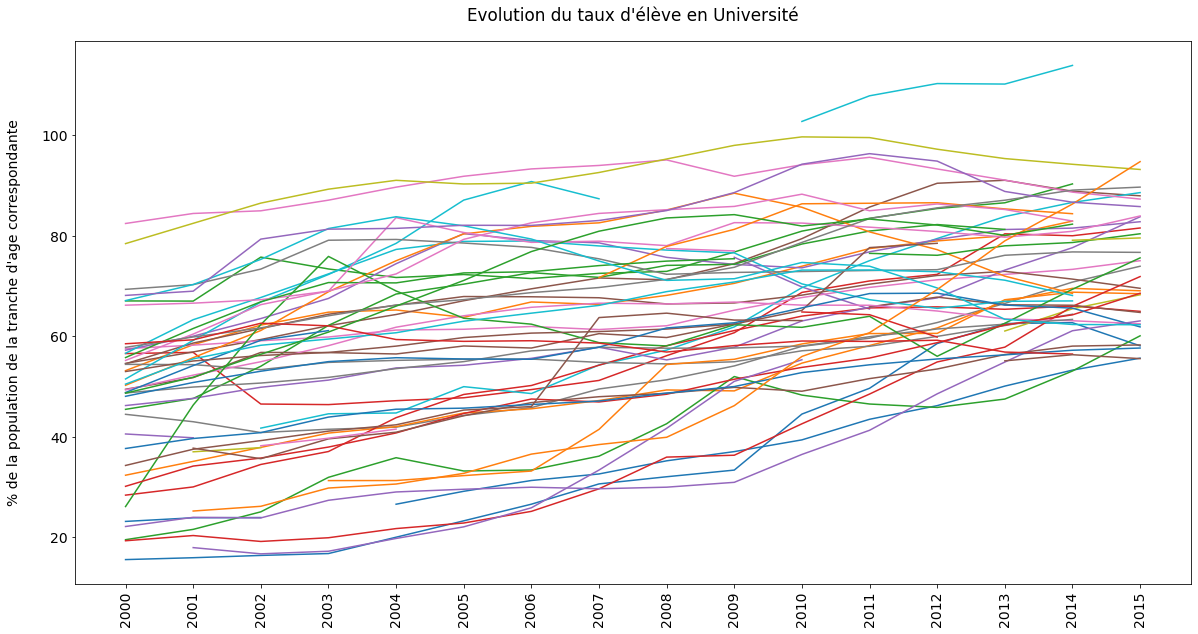

In [143]:
evolutionpaysannées(datatertiaryfiltré, tertiaryannées,  titre = "Evolution du taux d'élève en Université", axe_y = "% de la population de la tranche d'age correspondante")

## parler anglais

In [144]:
seriesanglais= series.copy()

In [145]:
seriesanglais = seriesanglais[seriesanglais['Topic'].str.contains("English") | seriesanglais['Indicator Name'].str.contains("English") | seriesanglais['Short definition'].str.contains("English") | seriesanglais['Long definition'].str.contains("English")]

In [146]:
seriesanglais

Series Code              Topic  \
620       LO.EGRA.CLPM.ENG.2GRD  Learning Outcomes   
621       LO.EGRA.CLPM.ENG.3GRD  Learning Outcomes   
622       LO.EGRA.CLPM.ENG.4GRD  Learning Outcomes   
646      LO.EGRA.CLSPM.ENG.2GRD  Learning Outcomes   
647      LO.EGRA.CLSPM.ENG.3GRD  Learning Outcomes   
648      LO.EGRA.CLSPM.ENG.4GRD  Learning Outcomes   
649      LO.EGRA.CLSPM.ENG.6GRD  Learning Outcomes   
674       LO.EGRA.CWPM.ENG.2GRD  Learning Outcomes   
675       LO.EGRA.CWPM.ENG.3GRD  Learning Outcomes   
676       LO.EGRA.CWPM.ENG.4GRD  Learning Outcomes   
677       LO.EGRA.CWPM.ENG.6GRD  Learning Outcomes   
712  LO.EGRA.CWPM.ZERO.ENG.2GRD  Learning Outcomes   
713  LO.EGRA.CWPM.ZERO.ENG.3GRD  Learning Outcomes   
714  LO.EGRA.CWPM.ZERO.ENG.4GRD  Learning Outcomes   
715  LO.EGRA.CWPM.ZERO.ENG.6GRD  Learning Outcomes   
750     LO.EGRA.INIT.0.ENG.2GRD  Learning Outcomes   
751     LO.EGRA.INIT.0.ENG.3GRD  Learning Outcomes   
752     LO.EGRA.INIT.0.ENG.4GRD  Learning Outcomes   
753     LO.EGRA.INIT.0.ENG.6GRD  Learning Outcomes   
778     LO.EGRA.LSTN.0.ENG.2GRD  Learning Outcomes   
779     LO.EGRA.LSTN.0.ENG.3GRD  Learning Outcomes   
780     LO.EGRA.LSTN.0.ENG.4GRD  Learning Outcomes   
781     LO.EGRA.LSTN.0.ENG.6GRD  Learning Outcomes   
828      LO.EGRA.NCWPM.ENG.2GRD  Learning Outcomes   
829      LO.EGRA.NCWPM.ENG.3GRD  Learning Outcomes   
830      LO.EGRA.NCWPM.ENG.4GRD  Learning Outcomes   
831      LO.EGRA.NCWPM.ENG.6GRD  Learning Outcomes   
879        LO.EGRA.ORF.ENG.2GRD  Learning Outcomes   
880        LO.EGRA.ORF.ENG.3GRD  Learning Outcomes   
881        LO.EGRA.ORF.ENG.4GRD  Learning Outcomes   
882        LO.EGRA.ORF.ENG.6GRD  Learning Outcomes   
930     LO.EGRA.READ.0.ENG.2GRD  Learning Outcomes   
931     LO.EGRA.READ.0.ENG.3GRD  Learning Outcomes   
932     LO.EGRA.READ.0.ENG.4GRD  Learning Outcomes   
933     LO.EGRA.READ.0.ENG.6GRD  Learning Outcomes   
981   LO.EGRA.READ.ENG.ADV.2GRD  Learning Outcomes   
982   LO.EGRA.READ.ENG.ADV.3GRD  Learning Outcomes   
983   LO.EGRA.READ.ENG.ADV.4GRD  Learning Outcomes   
984   LO.EGRA.READ.ENG.ADV.6GRD  Learning Outcomes   

                                        Indicator Name  \
620  EGRA: Correct Letter Names Read Per Minute (Me...   
621  EGRA: Correct Letter Names Read Per Minute (Me...   
622  EGRA: Correct Letter Names Read Per Minute (Me...   
646  EGRA: Correct Letter Sounds Read Per Minute (M...   
647  EGRA: Correct Letter Sounds Read Per Minute (M...   
648  EGRA: Correct Letter Sounds Read Per Minute (M...   
649  EGRA: Correct Letter Sounds Read Per Minute (M...   
674  EGRA: Correct Isolated Words Read Per Minute (...   
675  EGRA: Correct Isolated Words Read Per Minute (...   
676  EGRA: Correct Isolated Words Read Per Minute (...   
677  EGRA: Correct Isolated Words Read Per Minute (...   
712  EGRA: Oral Reading Fluency - Share of students...   
713  EGRA: Oral Reading Fluency - Share of students...   
714  EGRA: Oral Reading Fluency - Share of students...   
715  EGRA: Oral Reading Fluency - Share of students...   
750  EGRA: Identification of the Initial Sound of a...   
751  EGRA: Identification of the Initial Sound of a...   
752  EGRA: Identification of the Initial Sound of a...   
753  EGRA: Identification of the Initial Sound of a...   
778  EGRA: Listening Comprehension - Share of stude...   
779  EGRA: Listening Comprehension - Share of stude...   
780  EGRA: Listening Comprehension - Share of stude...   
781  EGRA: Listening Comprehension - Share of stude...   
828  EGRA: Correct Non-Words Read Per Minute (Mean)...   
829  EGRA: Correct Non-Words Read Per Minute (Mean)...   
830  EGRA: Correct Non-Words Read Per Minute (Mean)...   
831  EGRA: Correct Non-Words Read Per Minute (Mean)...   
879  EGRA: Oral Reading Fluency - Correct Words Rea...   
880  EGRA: Oral Reading Fluency - Correct Words Rea...   
881  EGRA: Oral Reading Fluency - Correct Words Rea...   
882  EGRA: Oral Reading Fluency - Correct Words Rea...   
930

In [147]:
seriesanglais['Indicator Name'].unique()

array(['EGRA: Correct Letter Names Read Per Minute (Mean). English. 2nd Grade',
       'EGRA: Correct Letter Names Read Per Minute (Mean). English. 3rd Grade',
       'EGRA: Correct Letter Names Read Per Minute (Mean). English. 4th Grade',
       'EGRA: Correct Letter Sounds Read Per Minute (Mean). English. 2nd Grade',
       'EGRA: Correct Letter Sounds Read Per Minute (Mean). English. 3rd Grade',
       'EGRA: Correct Letter Sounds Read Per Minute (Mean). English. 4th Grade',
       'EGRA: Correct Letter Sounds Read Per Minute (Mean). English. 6th Grade',
       'EGRA: Correct Isolated Words Read Per Minute (Mean). English. 2nd Grade',
       'EGRA: Correct Isolated Words Read Per Minute (Mean). English. 3rd Grade',
       'EGRA: Correct Isolated Words Read Per Minute (Mean). English. 4th Grade',
       'EGRA: Correct Isolated Words Read Per Minute (Mean). English. 6th Grade',
       'EGRA: Oral Reading Fluency - Share of students with a zero score (%). English. 2nd Grade',
       'E

In [148]:
#uniquement des indicateurs niveaux college, pas d'indicateur interessant, rip

# avoir le nombre de pays avec donnée par indicateur

In [149]:
datapays.head()

Country Name Country Code  \
91625  Afghanistan          AFG   
91626  Afghanistan          AFG   
91627  Afghanistan          AFG   
91628  Afghanistan          AFG   
91629  Afghanistan          AFG   

                                          Indicator Name  Indicator Code  \
91625  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   
91626  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   
91627  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   
91628  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.M   
91629  Adjusted net enrolment rate, primary, both sex...     SE.PRM.TENR   

       1970  1971  1972  1973      1974  1975  ...  2055  2060  2065  2070  \
91625   NaN   NaN   NaN   NaN   7.05911   NaN  ...   NaN   NaN   NaN   NaN   
91626   NaN   NaN   NaN   NaN   2.53138   NaN  ...   NaN   NaN   NaN   NaN   
91627   NaN   NaN   NaN   NaN   0.22154   NaN  ...   NaN   NaN   NaN   NaN   
91628   NaN   NaN   NaN   NaN  11.42652   NaN  ...   NaN   NaN   NaN   NaN   
91629   NaN   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   NaN   NaN   

       2075  2080  2085  2090  2095  2100  
91625   NaN   NaN   NaN   NaN   NaN   NaN  
91626   NaN   NaN   NaN   NaN   NaN   NaN  
91627   NaN   NaN   NaN   NaN   NaN   NaN  
91628   NaN   NaN   NaN   NaN   NaN   NaN  
91629   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 69 columns]

In [150]:
#seriesnombre = pd.DataFrame(columns={'Indicator Code'})
#seriesnombre['Indicator Code']=series['Series Code']
#années = data.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],axis = 1).columns

#for année in années.values:
    #nombrevaleurs = []
    #for ind in seriesnombre['Indicator Code'].values:
        #df = datapays[datapays['Indicator Code']==ind]
        #nombrevaleurs = nombrevaleurs + [df[année].count()]
    #seriesnombre[année]=nombrevaleurs
    
#seriesnombre

#bien trop long> rechercher une methode dataframe qui le fasse

In [151]:
datacount = datapays.groupby('Indicator Code').count()

In [152]:
datacount = datacount.drop(['Country Name', 'Country Code', 'Indicator Name'], axis =1)

In [153]:
datacount

1970  1971  1972  1973  1974  1975  1976  1977  \
Indicator Code                                                                
BAR.NOED.1519.FE.ZS           144     0     0     0     0   144     0     0   
BAR.NOED.1519.ZS              144     0     0     0     0   144     0     0   
BAR.NOED.15UP.FE.ZS           144     0     0     0     0   144     0     0   
BAR.NOED.15UP.ZS              144     0     0     0     0   144     0     0   
BAR.NOED.2024.FE.ZS           144     0     0     0     0   144     0     0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
UIS.XUNIT.USCONST.3.FSGOV       0     0     0     0     0     0     0     0   
UIS.XUNIT.USCONST.4.FSGOV       0     0     0     0     0     0     0     0   
UIS.XUNIT.USCONST.56.FSGOV      0     0     0     0     0     0     0     0   
XGDP.23.FSGOV.FDINSTADM.FFD     0     0     0     0     0     0     0     0   
XGDP.56.FSGOV.FDINSTADM.FFD     0     0     0     0     0     0     0     0   

                             1978  1979  ...  2055  2060  2065  2070  2075  \
Indicator Code                           ...                                 
BAR.NOED.1519.FE.ZS             0     0  ...     0     0     0     0     0   
BAR.NOED.1519.ZS                0     0  ...     0     0     0     0     0   
BAR.NOED.15UP.FE.ZS             0     0  ...     0     0     0     0     0   
BAR.NOED.15UP.ZS                0     0  ...     0     0     0     0     0   
BAR.NOED.2024.FE.ZS             0     0  ...     0     0     0     0     0   
...                           ...   ...  ...   ...   ...   ...   ...   ...   
UIS.XUNIT.USCONST.3.FSGOV       0     0  ...     0     0     0     0     0   
UIS.XUNIT.USCONST.4.FSGOV       0     0  ...     0     0     0     0     0   
UIS.XUNIT.USCONST.56.FSGOV      0     0  ...     0     0     0     0     0   
XGDP.23.FSGOV.FDINSTADM.FFD     0     0  ...     0     0     0     0     0   
XGDP.56.FSGOV.FDINSTADM.FFD     0     0  ...     0     0     0     0     0   

                             2080  2085  2090  2095  2100  
Indicator Code                                             
BAR.NOED.1519.FE.ZS             0     0     0     0     0  
BAR.NOED.1519.ZS                0     0     0     0     0  
BAR.NOED.15UP.FE.ZS             0     0     0     0     0  
BAR.NOED.15UP.ZS                0     0     0     0     0  
BAR.NOED.2024.FE.ZS             0     0     0     0     0  
...                           ...   ...   ...   ...   ...  
UIS.XUNIT.USCONST.3.FSGOV       0     0     0     0     0  
UIS.XUNIT.USCONST.4.FSGOV       0     0     0     0     0  
UIS.XUNIT.USCONST.56.FSGOV      0     0     0     0     0  
XGDP.23.FSGOV.FDINSTADM.FFD     0     0     0     0     0  
XGDP.56.FSGOV.FDINSTADM.FFD     0     0     0     0     0  

[3665 rows x 65 columns]

In [154]:
#taux remplissage du datafrmae pour chaque indicateur > %de pays ayant une valeur en moyenne sur toutes les années
taux = datacount.sum(axis = 1)*100/(len(datapays["Country Name"].unique())*len(datacount.columns))

In [155]:
taux.describe()

count    3665.000000
mean        9.274128
std        12.823700
min         0.007090
25%         0.205601
50%         2.261609
75%        14.058844
max        70.818859
dtype: float64

In [156]:
#on se limite aux données relatives au présent
datacountpresent = masque_année(datacount, 2021, 2100)

In [157]:
datacountpresent

1970  1971  1972  1973  1974  1975  1976  1977  \
Indicator Code                                                                
BAR.NOED.1519.FE.ZS           144     0     0     0     0   144     0     0   
BAR.NOED.1519.ZS              144     0     0     0     0   144     0     0   
BAR.NOED.15UP.FE.ZS           144     0     0     0     0   144     0     0   
BAR.NOED.15UP.ZS              144     0     0     0     0   144     0     0   
BAR.NOED.2024.FE.ZS           144     0     0     0     0   144     0     0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
UIS.XUNIT.USCONST.3.FSGOV       0     0     0     0     0     0     0     0   
UIS.XUNIT.USCONST.4.FSGOV       0     0     0     0     0     0     0     0   
UIS.XUNIT.USCONST.56.FSGOV      0     0     0     0     0     0     0     0   
XGDP.23.FSGOV.FDINSTADM.FFD     0     0     0     0     0     0     0     0   
XGDP.56.FSGOV.FDINSTADM.FFD     0     0     0     0     0     0     0     0   

                             1978  1979  ...  2009  2010  2011  2012  2013  \
Indicator Code                           ...                                 
BAR.NOED.1519.FE.ZS             0     0  ...     0   144     0     0     0   
BAR.NOED.1519.ZS                0     0  ...     0   144     0     0     0   
BAR.NOED.15UP.FE.ZS             0     0  ...     0   144     0     0     0   
BAR.NOED.15UP.ZS                0     0  ...     0   144     0     0     0   
BAR.NOED.2024.FE.ZS             0     0  ...     0   144     0     0     0   
...                           ...   ...  ...   ...   ...   ...   ...   ...   
UIS.XUNIT.USCONST.3.FSGOV       0     0  ...    62    70    74    61    47   
UIS.XUNIT.USCONST.4.FSGOV       0     0  ...    33    37    35    33    19   
UIS.XUNIT.USCONST.56.FSGOV      0     0  ...    86    94    87    74    55   
XGDP.23.FSGOV.FDINSTADM.FFD     0     0  ...    92   102   100    81    74   
XGDP.56.FSGOV.FDINSTADM.FFD     0     0  ...    91   103    99    83    73   

                             2014  2015  2016  2017  2020  
Indicator Code                                             
BAR.NOED.1519.FE.ZS             0     0     0     0     0  
BAR.NOED.1519.ZS                0     0     0     0     0  
BAR.NOED.15UP.FE.ZS             0     0     0     0     0  
BAR.NOED.15UP.ZS                0     0     0     0     0  
BAR.NOED.2024.FE.ZS             0     0     0     0     0  
...                           ...   ...   ...   ...   ...  
UIS.XUNIT.USCONST.3.FSGOV      21     0     0     0     0  
UIS.XUNIT.USCONST.4.FSGOV      10     0     0     0     0  
UIS.XUNIT.USCONST.56.FSGOV     21     0     0     0     0  
XGDP.23.FSGOV.FDINSTADM.FFD    39     1     0     0     0  
XGDP.56.FSGOV.FDINSTADM.FFD    35     1     0     0     0  

[3665 rows x 49 columns]

In [158]:
#ajout colonne indiquant le nombre de pays avec indicatuer dans l'année la mieux remplie
datacountpresent['Max nb pays'] = datacountpresent.max(axis=1)

In [159]:
#150 pays au moins dans une année, environ 70% de la liste des pays ( hors region/categorie)
datacountpresent[datacountpresent['Max nb pays']>150]

1970  1971  1972  1973  1974  1975  1976  1977  1978  1979  \
Indicator Code                                                                  
IT.CMP.PCMP.P2        1     0     0     0     0     1     1     1     1     1   
IT.NET.USER.P2        7     0     0     0     0     7     7     7     7     7   
NY.GDP.MKTP.CD      125   127   127   127   127   129   130   134   133   134   
NY.GDP.MKTP.KD      112   112   112   112   113   117   118   124   124   125   
NY.GDP.MKTP.PP.CD     0     0     0     0     0     0     0     0     0     0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
UIS.SLE.12.M          0     0     0     0     0     0     0     0     0     0   
UIS.SLE.23           41   137   133   128   122   119   131   125   123   123   
UIS.THAGE.0         199   200   200   200   200   200   200   200   200   200   
UIS.THAGE.3.A.GPV     0     0     0     0     0     0     0     0     0     0   
UIS.THDUR.0         200   201   201   201   201   201   201   201   201   201   

                   ...  2010  2011  2012  2013  2014  2015  2016  2017  2020  \
Indicator Code     ...                                                         
IT.CMP.PCMP.P2     ...     0     0     0     0     0     0     0     0     0   
IT.NET.USER.P2     ...   202   204   202   201   201   201   201     0     0   
NY.GDP.MKTP.CD     ...   203   203   199   200   197   196   189     0     0   
NY.GDP.MKTP.KD     ...   202   198   196   196   194   193   186     0     0   
NY.GDP.MKTP.PP.CD  ...   190   192   188   188   185   184   181     0     0   
...                ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
UIS.SLE.12.M       ...   139   147   142   130   115     7     0     0     0   
UIS.SLE.23         ...   145   150   141   131   109     6     0     0     0   
UIS.THAGE.0        ...   204   204   204   204   202   202   203     0     0   
UIS.THAGE.3.A.GPV  ...   204   203   203   204   203   202   203     0     0   
UIS.THDUR.0        ...   205   205   205   205   205   205   175     0     0   

                   Max nb pays  
Indicator Code                  
IT.CMP.PCMP.P2             182  
IT.NET.USER.P2             206  
NY.GDP.MKTP.CD             205  
NY.GDP.MKTP.KD             202  
NY.GDP.MKTP.PP.CD          192  
...                        ...  
UIS.SLE.12.M               156  
UIS.SLE.23                 154  
UIS.THAGE.0                207  
UIS.THAGE.3.A.GPV          207  
UIS.THDUR.0                208  

[635 rows x 50 columns]

In [160]:
#calcul du nombre d'années avec des data
#type bool pour la somme pour 1 quand colonne avec données, 0 si aucun pays a de donné pour cette année
datacountpresent['Nb années avec données'] = datacountpresent.drop('Max nb pays', axis = 1).astype(bool).sum(axis = 1)

In [161]:
datacountpresent['Nb années avec données'].describe()

count    3665.000000
mean       13.759618
std        14.350753
min         1.000000
25%         3.000000
50%         9.000000
75%        18.000000
max        47.000000
Name: Nb années avec données, dtype: float64

In [162]:
#filtre avec 30 années de données, et un max de 180 pays avec data sur une des années
#on aurait pu utiliser le taux défini plus haut ( mais qui a été créé apres chronologiquement)
selectionindicateurs = datacountpresent[(datacountpresent['Max nb pays']>180) & (datacountpresent['Nb années avec données']>30)]

In [163]:
selectionindicateurs

1970  1971  1972  1973  1974  1975  1976  1977  1978  \
Indicator Code                                                              
IT.CMP.PCMP.P2          1     0     0     0     0     1     1     1     1   
IT.NET.USER.P2          7     0     0     0     0     7     7     7     7   
NY.GDP.MKTP.CD        125   127   127   127   127   129   130   134   133   
NY.GDP.MKTP.KD        112   112   112   112   113   117   118   124   124   
NY.GDP.PCAP.CD        125   127   127   127   127   129   130   134   133   
NY.GDP.PCAP.KD        112   112   112   112   113   117   118   124   124   
NY.GNP.MKTP.CD        123   123   124   126   126   125   126   131   131   
NY.GNP.PCAP.CD        101   101   111   112   112   111   111   114   116   
SE.PRM.AGES           201   201   201   201   201   201   201   201   201   
SE.PRM.DURS           201   201   201   201   201   201   201   201   201   
SE.SEC.AGES           200   200   200   200   200   200   200   200   200   
SE.SEC.DURS           200   200   200   200   200   200   200   200   200   
SE.SEC.DURS.LO        200   200   200   200   200   200   200   200   200   
SE.SEC.DURS.UP        200   200   200   200   200   200   200   200   200   
SH.DYN.MORT           140   144   147   147   150   155   157   158   162   
SP.POP.0014.FE.IN     191   191   191   191   191   191   191   191   191   
SP.POP.0014.MA.IN     191   191   191   191   191   191   191   191   191   
SP.POP.0014.TO        191   191   191   191   191   191   191   191   191   
SP.POP.0014.TO.ZS     192   192   192   192   192   192   192   192   192   
SP.POP.1564.FE.IN     191   191   191   191   191   191   191   191   191   
SP.POP.1564.MA.IN     191   191   191   191   191   191   191   191   191   
SP.POP.1564.TO        191   191   191   191   191   191   191   191   191   
SP.POP.1564.TO.ZS     192   192   192   192   192   192   192   192   192   
SP.POP.GROW           211   211   211   211   211   211   211   211   211   
SP.POP.TOTL           211   211   211   211   211   211   211   211   211   
SP.POP.TOTL.FE.IN     191   191   191   191   191   191   191   191   191   
SP.POP.TOTL.FE.ZS     192   192   192   192   192   192   192   192   192   
SP.POP.TOTL.MA.IN     191   191   191   191   191   191   191   191   191   
SP.POP.TOTL.MA.ZS     192   192   192   192   192   192   192   192   192   
SP.PRE.TOTL.FE.IN     189   189   189   189   189   189   189   189   189   
SP.PRE.TOTL.IN        189   189   189   189   189   189   189   189   189   
SP.PRE.TOTL.MA.IN     189   189   189   189   189   189   189   189   189   
SP.PRM.GRAD.FE        190   188   188   188   188   188   188   188   188   
SP.PRM.GRAD.MA        190   188   188   188   188   188   188   188   188   
SP.PRM.GRAD.TO        190   188   188   188   188   188   188   188   188   
SP.PRM.TOTL.FE.IN     190   188   188   188   188   188   188   188   188   
SP.PRM.TOTL.IN        190   188   188   188   188   188   188   188   188   
SP.PRM.TOTL.MA.IN     190   188   188   188   188   188   188   188   188   
SP.SEC.LTOT.FE.IN     189   188   188   188   188   188   188   188   188   
SP.SEC.LTOT.IN        189   188   188   188   188   188   188   188   188   
SP.SEC.LTOT.MA.IN     189   188   188   188   188   188   188   188   188   
SP.SEC.TOTL.FE.IN     189   188   188   188   188   188   188   188   188   
SP.SEC.TOTL.IN        189   188   188   188   188   188   188   188   188   
SP.SEC.TOTL.MA.IN     189   188   188   188   188   188   188   188   188   
SP.SEC.UTOT.FE.IN     189   188   188   188   188   188   188   188   188   
SP.SEC.UTOT.IN        189   188   188   188   188   188   188   188   188   
SP.SEC.UTOT.MA.IN     189   188   188   188   188   188   188   188   188   
SP.TER.TOTL.FE.IN     190   188   188   188   188   188   188   188   188   
SP.TER.TOTL.IN        190   188   188   188   188   188   188   188   188   
SP.TER.TOTL.MA.IN     190   188   188   188   188   188   188   188   188   
UIS.SAP.1.G1     

In [164]:
indicateurs = series[['Series Code', 'Topic', 'Indicator Name', 'Short definition', 'Long definition']].copy()

In [165]:
indicateurs

Series Code         Topic  \
0             BAR.NOED.1519.FE.ZS    Attainment   
1                BAR.NOED.1519.ZS    Attainment   
2             BAR.NOED.15UP.FE.ZS    Attainment   
3                BAR.NOED.15UP.ZS    Attainment   
4             BAR.NOED.2024.FE.ZS    Attainment   
...                           ...           ...   
3660    UIS.XUNIT.USCONST.3.FSGOV  Expenditures   
3661    UIS.XUNIT.USCONST.4.FSGOV  Expenditures   
3662   UIS.XUNIT.USCONST.56.FSGOV  Expenditures   
3663  XGDP.23.FSGOV.FDINSTADM.FFD  Expenditures   
3664  XGDP.56.FSGOV.FDINSTADM.FFD  Expenditures   

                                         Indicator Name  \
0     Barro-Lee: Percentage of female population age...   
1     Barro-Lee: Percentage of population age 15-19 ...   
2     Barro-Lee: Percentage of female population age...   
3     Barro-Lee: Percentage of population age 15+ wi...   
4     Barro-Lee: Percentage of female population age...   
...                                                 ...   
3660  Government expenditure per upper secondary stu...   
3661  Government expenditure per post-secondary non-...   
3662  Government expenditure per tertiary student (c...   
3663  Government expenditure in secondary institutio...   
3664  Government expenditure in tertiary institution...   

                                       Short definition  \
0     Percentage of female population age 15-19 with...   
1     Percentage of population age 15-19 with no edu...   
2     Percentage of female population age 15+ with n...   
3     Percentage of population age 15+ with no educa...   
4     Percentage of female population age 20-24 with...   
...                                                 ...   
3660                                                NaN   
3661                                                NaN   
3662                                                NaN   
3663  Total general (local, regional and central) go...   
3664  Total general (local, regional and central) go...   

                                        Long definition  
0     Percentage of female population age 15-19 with...  
1     Percentage of population age 15-19 with no edu...  
2     Percentage of female population age 15+ with n...  
3     Percentage of population age 15+ with no educa...  
4     Percentage of female population age 20-24 with...  
...                                                 ...  
3660  Average total (current, capital and transfers)...  
3661  Average total (current, capital and transfers)...  
3662  Average total (current, capital and transfers)...  
3663  Total general (local, regional and central) go...  
3664  Total general (local, regional and central) go...  

[3665 rows x 5 columns]

In [166]:
#synthetiser juste indicateurs/nombre pays max/nombre années avec data
datamaxpresent = masque_année(selectionindicateurs, 1970, 2020)

In [167]:
datamaxpresent

Max nb pays  Nb années avec données
Indicator Code                                          
IT.CMP.PCMP.P2               182                      36
IT.NET.USER.P2               206                      43
NY.GDP.MKTP.CD               205                      47
NY.GDP.MKTP.KD               202                      47
NY.GDP.PCAP.CD               205                      47
NY.GDP.PCAP.KD               202                      47
NY.GNP.MKTP.CD               196                      47
NY.GNP.PCAP.CD               195                      47
SE.PRM.AGES                  208                      47
SE.PRM.DURS                  208                      47
SE.SEC.AGES                  208                      47
SE.SEC.DURS                  205                      47
SE.SEC.DURS.LO               208                      47
SE.SEC.DURS.UP               208                      47
SH.DYN.MORT                  192                      47
SP.POP.0014.FE.IN            194                      47
SP.POP.0014.MA.IN            194                      47
SP.POP.0014.TO               194                      47
SP.POP.0014.TO.ZS            194                      47
SP.POP.1564.FE.IN            194                      47
SP.POP.1564.MA.IN            194                      47
SP.POP.1564.TO               194                      47
SP.POP.1564.TO.ZS            194                      47
SP.POP.GROW                  215                      47
SP.POP.TOTL                  215                      47
SP.POP.TOTL.FE.IN            194                      47
SP.POP.TOTL.FE.ZS            194                      47
SP.POP.TOTL.MA.IN            194                      47
SP.POP.TOTL.MA.ZS            194                      47
SP.PRE.TOTL.FE.IN            195                      47
SP.PRE.TOTL.IN               196                      47
SP.PRE.TOTL.MA.IN            195                      47
SP.PRM.GRAD.FE               191                      47
SP.PRM.GRAD.MA               191                      47
SP.PRM.GRAD.TO               192                      47
SP.PRM.TOTL.FE.IN            192                      47
SP.PRM.TOTL.IN               193                      47
SP.PRM.TOTL.MA.IN            192                      47
SP.SEC.LTOT.FE.IN            195                      47
SP.SEC.LTOT.IN               196                      47
SP.SEC.LTOT.MA.IN            195                      47
SP.SEC.TOTL.FE.IN            195                      47
SP.SEC.TOTL.IN               196                      47
SP.SEC.TOTL.MA.IN            195                      47
SP.SEC.UTOT.FE.IN            196                      47
SP.SEC.UTOT.IN               197                      47
SP.SEC.UTOT.MA.IN            196                      47
SP.TER.TOTL.FE.IN            195                      47
SP.TER.TOTL.IN               196                      47
SP.TER.TOTL.MA.IN            195                      47
UIS.SAP.1.G1                 190                      47
UIS.SAP.1.G1.F               189                      47
UIS.SAP.1.G1.M               189                      47
UIS.SAP.23.GPV.G1            194                      47
UIS.SAP.23.GPV.G1.F          193                      47
UIS.SAP.23.GPV.G1.M          193                      47
UIS.THAGE.0                  207                      47
UIS.THDUR.0                  208                      47

In [168]:
#jointure entre table précedente et table décrivant les indicateurs  pour voir à quoi ces indicateurs correspondent
indicateursremplis = indicateurs.join(datamaxpresent, on='Series Code', how = 'inner')

In [169]:
indicateursremplis

Series Code                                              Topic  \
610        IT.CMP.PCMP.P2                     Infrastructure: Communications   
611        IT.NET.USER.P2                     Infrastructure: Communications   
1658       NY.GDP.MKTP.CD  Economic Policy & Debt: National accounts: US$...   
1659       NY.GDP.MKTP.KD  Economic Policy & Debt: National accounts: US$...   
1662       NY.GDP.PCAP.CD  Economic Policy & Debt: National accounts: US$...   
1663       NY.GDP.PCAP.KD  Economic Policy & Debt: National accounts: US$...   
1666       NY.GNP.MKTP.CD  Economic Policy & Debt: National accounts: US$...   
1668       NY.GNP.PCAP.CD  Economic Policy & Debt: National accounts: Atl...   
2235          SE.PRM.AGES                                            Primary   
2245          SE.PRM.DURS                                            Primary   
2287          SE.SEC.AGES                                          Secondary   
2291          SE.SEC.DURS                                          Secondary   
2293       SE.SEC.DURS.UP                                          Secondary   
2383          SH.DYN.MORT                                  Health: Mortality   
2401    SP.POP.0014.FE.IN                      Health: Population: Structure   
2402    SP.POP.0014.MA.IN                      Health: Population: Structure   
2403       SP.POP.0014.TO                      Health: Population: Structure   
2404    SP.POP.0014.TO.ZS                      Health: Population: Structure   
2507    SP.POP.1564.FE.IN                      Health: Population: Structure   
2508    SP.POP.1564.MA.IN                      Health: Population: Structure   
2509       SP.POP.1564.TO                      Health: Population: Structure   
2510    SP.POP.1564.TO.ZS                      Health: Population: Structure   
2589          SP.POP.GROW                       Health: Population: Dynamics   
2590          SP.POP.TOTL                      Health: Population: Structure   
2591    SP.POP.TOTL.FE.IN                      Health: Population: Structure   
2592    SP.POP.TOTL.FE.ZS                      Health: Population: Structure   
2593    SP.POP.TOTL.MA.IN                      Health: Population: Structure   
2594    SP.POP.TOTL.MA.ZS                      Health: Population: Structure   
2595    SP.PRE.TOTL.FE.IN                                         Population   
2596       SP.PRE.TOTL.IN                                         Population   
2597    SP.PRE.TOTL.MA.IN                                         Population   
2598       SP.PRM.GRAD.FE                                         Population   
2599       SP.PRM.GRAD.MA                                         Population   
2600       SP.PRM.GRAD.TO                                         Population   
2601    SP.PRM.TOTL.FE.IN                                         Population   
2602       SP.PRM.TOTL.IN                                         Population   
2603    SP.PRM.TOTL.MA.IN                                         Population   
2604    SP.SEC.LTOT.FE.IN                                         Population   
2605       SP.SEC.LTOT.IN                                         Population   
2606    SP.SEC.LTOT.MA.IN                                         Population   
2607    SP.SEC.TOTL.FE.IN                                         Population   
2608       SP.SEC.TOTL.IN                                         Population   
2609    SP.SEC.TOTL.MA.IN                                         Population   
2610    SP.SEC.UTOT.FE.IN                                         Population   
2611       SP.SEC.UTOT.IN                                         Population   
2612    SP.SEC.UTOT.MA.IN                                         Population   
2613    SP.TER.TOTL.FE.IN                                         Population   
2614       SP.TER.TOTL.IN                                         Population   
2615    SP.TER.TOTL.MA.IN                                         Population   
3467         U

# Ajout indicateur GDP + nombre eleves et pas juste % pout faire tri avec pays avec beaucoup d'eleves ou non

In [170]:
#selection de l'indicateur GPD/capita qui est dans la liste précédente

In [171]:
datagdp = datapayspresent[datapayspresent['Indicator Code']=='NY.GDP.PCAP.CD'].copy()

In [172]:
datagdp.head()

Country Name Country Code                Indicator Name  \
92870      Afghanistan          AFG  GDP per capita (current US$)   
96535          Albania          ALB  GDP per capita (current US$)   
100200         Algeria          DZA  GDP per capita (current US$)   
103865  American Samoa          ASM  GDP per capita (current US$)   
107530         Andorra          AND  GDP per capita (current US$)   

        Indicator Code         1970         1971         1972         1973  \
92870   NY.GDP.PCAP.CD   157.187422   160.372836   136.117014   144.110319   
96535   NY.GDP.PCAP.CD          NaN          NaN          NaN          NaN   
100200  NY.GDP.PCAP.CD   334.259528   339.384049   439.731124   551.434442   
103865  NY.GDP.PCAP.CD          NaN          NaN          NaN          NaN   
107530  NY.GDP.PCAP.CD  3238.556850  3498.173652  4217.173581  5342.168560   

               1974         1975  ...          2009          2010  \
92870    174.942038   187.975604  ...    445.893298    553.300289   
96535           NaN          NaN  ...   4114.136545   4094.358832   
100200   813.049903   931.105517  ...   3868.831230   4463.394675   
103865          NaN          NaN  ...  12058.263823  10352.822762   
107530  6319.739034  7169.101006  ...  43339.379875  39736.354063   

                2011          2012          2013          2014          2015  \
92870     603.537023    669.009051    631.744971    612.069651    569.577923   
96535    4437.178068   4247.614308   4413.081697   4578.666728   3934.895394   
100200   5432.413320   5565.134521   5471.123389   5466.425778   4160.220067   
103865  10375.994215  11660.329531  11589.853002  11598.751736  11865.963232   
107530  41098.766942  38391.080867  40619.711298  42294.994727  36038.267604   

                2016  2017  2020  
92870     561.778746   NaN   NaN  
96535    4124.982390   NaN   NaN  
100200   3916.881571   NaN   NaN  
103865  11834.745229   NaN   NaN  
107530  36988.622030   NaN   NaN  

[5 rows x 53 columns]

In [173]:
datagdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 92870 to 884510
Data columns (total 53 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Country Code    217 non-null    object 
 2   Indicator Name  217 non-null    object 
 3   Indicator Code  217 non-null    object 
 4   1970            125 non-null    float64
 5   1971            127 non-null    float64
 6   1972            127 non-null    float64
 7   1973            127 non-null    float64
 8   1974            127 non-null    float64
 9   1975            129 non-null    float64
 10  1976            130 non-null    float64
 11  1977            134 non-null    float64
 12  1978            133 non-null    float64
 13  1979            134 non-null    float64
 14  1980            144 non-null    float64
 15  1981            147 non-null    float64
 16  1982            148 non-null    float64
 17  1983            149 non-null

In [174]:
annéesgdp = datagdp.drop(["Country Name", "Country Code","Indicator Name", "Indicator Code"], axis = 1)

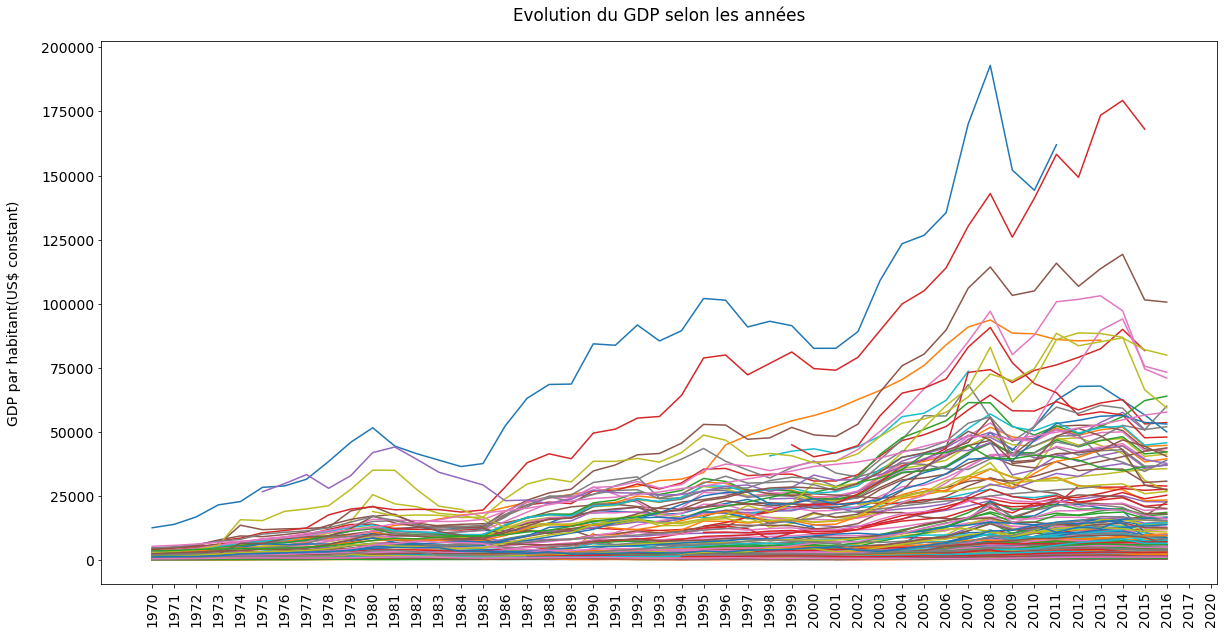

In [175]:
evolutionpaysannées(datagdp, annéesgdp, titre = "Evolution du GDP selon les années", axe_y = 'GDP par habitant(US$ constant)')

In [176]:
datagdp['2011'].describe()

count       203.000000
mean      16941.499320
std       25641.218818
min         260.479907
25%        1674.907841
50%        5771.565878
75%       21487.929947
max      162009.877819
Name: 2011, dtype: float64

In [177]:
#se limiter aux 20 dernieres années
datagdp = masque_année(datagdp,1970, 1999)
annéesgdp = masque_année(annéesgdp,1970, 1999)

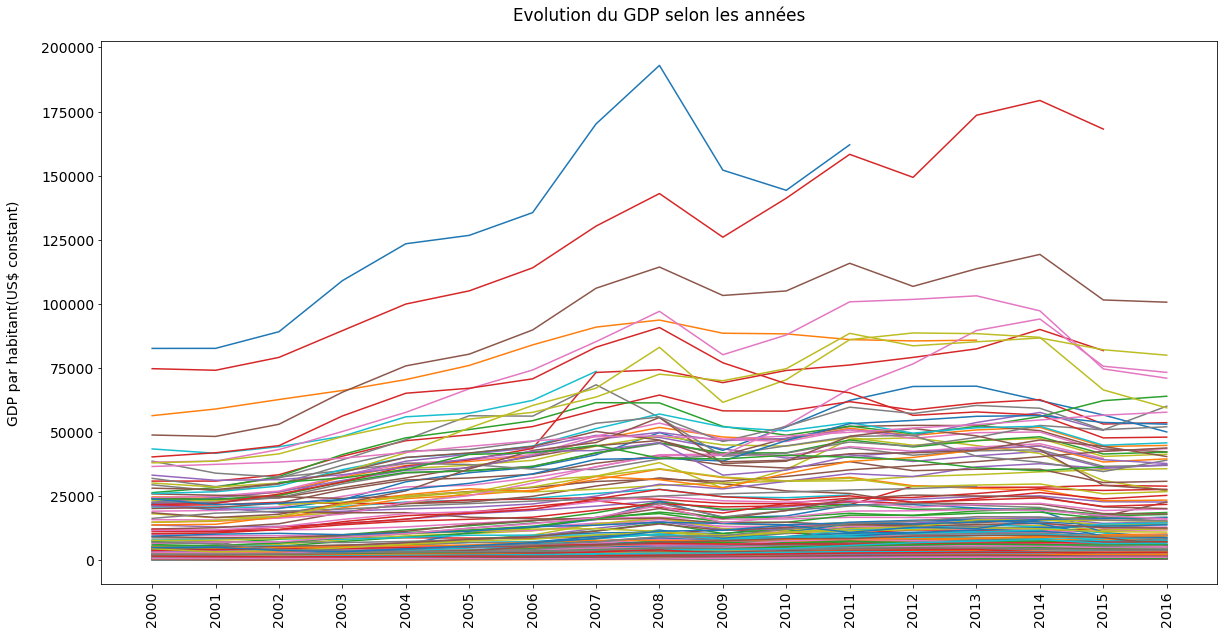

In [178]:
evolutionpaysannées(datagdp, annéesgdp, titre = "Evolution du GDP selon les années", axe_y = 'GDP par habitant(US$ constant)')

In [179]:
datagdp['Nombre données'] = annéesgdp.notna().sum(axis=1)

In [180]:
datagdp.head()

Country Name Country Code                Indicator Name  \
92870      Afghanistan          AFG  GDP per capita (current US$)   
96535          Albania          ALB  GDP per capita (current US$)   
100200         Algeria          DZA  GDP per capita (current US$)   
103865  American Samoa          ASM  GDP per capita (current US$)   
107530         Andorra          AND  GDP per capita (current US$)   

        Indicator Code          2000          2001          2002  \
92870   NY.GDP.PCAP.CD           NaN    117.409691    187.845095   
96535   NY.GDP.PCAP.CD   1175.788981   1326.970339   1453.642777   
100200  NY.GDP.PCAP.CD   1757.017797   1732.857979   1774.033673   
103865  NY.GDP.PCAP.CD           NaN           NaN   8751.766529   
107530  NY.GDP.PCAP.CD  21936.530101  22228.846493  24741.493570   

                2003          2004          2005  ...          2010  \
92870     198.728544    219.141353    250.294130  ...    553.300289   
96535    1890.681557   2416.588235   2709.142931  ...   4094.358832   
100200   2094.335506   2598.908023   3100.122378  ...   4463.394675   
103865   8914.525433   8639.308855   8508.406915  ...  10352.822762   
107530  32776.442270  38503.479614  41282.020122  ...  39736.354063   

                2011          2012          2013          2014          2015  \
92870     603.537023    669.009051    631.744971    612.069651    569.577923   
96535    4437.178068   4247.614308   4413.081697   4578.666728   3934.895394   
100200   5432.413320   5565.134521   5471.123389   5466.425778   4160.220067   
103865  10375.994215  11660.329531  11589.853002  11598.751736  11865.963232   
107530  41098.766942  38391.080867  40619.711298  42294.994727  36038.267604   

                2016  2017  2020  Nombre données  
92870     561.778746   NaN   NaN              16  
96535    4124.982390   NaN   NaN              17  
100200   3916.881571   NaN   NaN              17  
103865  11834.745229   NaN   NaN              15  
107530  36988.622030   NaN   NaN              17  

[5 rows x 24 columns]

In [181]:
#Pays avec au moins une donnée
datagdp = datagdp[datagdp['Nombre données']>0]

In [182]:
derniereannée(datagdp, annéesgdp)

In [183]:
datagdp.head()

Country Name Country Code                Indicator Name  \
92870      Afghanistan          AFG  GDP per capita (current US$)   
96535          Albania          ALB  GDP per capita (current US$)   
100200         Algeria          DZA  GDP per capita (current US$)   
103865  American Samoa          ASM  GDP per capita (current US$)   
107530         Andorra          AND  GDP per capita (current US$)   

        Indicator Code          2000          2001          2002  \
92870   NY.GDP.PCAP.CD           NaN    117.409691    187.845095   
96535   NY.GDP.PCAP.CD   1175.788981   1326.970339   1453.642777   
100200  NY.GDP.PCAP.CD   1757.017797   1732.857979   1774.033673   
103865  NY.GDP.PCAP.CD           NaN           NaN   8751.766529   
107530  NY.GDP.PCAP.CD  21936.530101  22228.846493  24741.493570   

                2003          2004          2005  ...          2011  \
92870     198.728544    219.141353    250.294130  ...    603.537023   
96535    1890.681557   2416.588235   2709.142931  ...   4437.178068   
100200   2094.335506   2598.908023   3100.122378  ...   5432.413320   
103865   8914.525433   8639.308855   8508.406915  ...  10375.994215   
107530  32776.442270  38503.479614  41282.020122  ...  41098.766942   

                2012          2013          2014          2015          2016  \
92870     669.009051    631.744971    612.069651    569.577923    561.778746   
96535    4247.614308   4413.081697   4578.666728   3934.895394   4124.982390   
100200   5565.134521   5471.123389   5466.425778   4160.220067   3916.881571   
103865  11660.329531  11589.853002  11598.751736  11865.963232  11834.745229   
107530  38391.080867  40619.711298  42294.994727  36038.267604  36988.622030   

        2017  2020  Nombre données  Année Last Data  
92870    NaN   NaN              16             2016  
96535    NaN   NaN              17             2016  
100200   NaN   NaN              17             2016  
103865   NaN   NaN              15             2016  
107530   NaN   NaN              17             2016  

[5 rows x 25 columns]

In [184]:
datagdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 92870 to 884510
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     209 non-null    object 
 1   Country Code     209 non-null    object 
 2   Indicator Name   209 non-null    object 
 3   Indicator Code   209 non-null    object 
 4   2000             199 non-null    float64
 5   2001             199 non-null    float64
 6   2002             203 non-null    float64
 7   2003             203 non-null    float64
 8   2004             204 non-null    float64
 9   2005             204 non-null    float64
 10  2006             205 non-null    float64
 11  2007             204 non-null    float64
 12  2008             203 non-null    float64
 13  2009             202 non-null    float64
 14  2010             203 non-null    float64
 15  2011             203 non-null    float64
 16  2012             199 non-null    float64
 17  2013     

In [185]:
datagdpcomplété = datagdp.fillna(axis = 1, method = 'ffill')

In [186]:
datagdpcomplété.head()

Country Name Country Code                Indicator Name  \
92870      Afghanistan          AFG  GDP per capita (current US$)   
96535          Albania          ALB  GDP per capita (current US$)   
100200         Algeria          DZA  GDP per capita (current US$)   
103865  American Samoa          ASM  GDP per capita (current US$)   
107530         Andorra          AND  GDP per capita (current US$)   

        Indicator Code            2000            2001     2002     2003  \
92870   NY.GDP.PCAP.CD  NY.GDP.PCAP.CD          117.41  187.845  198.729   
96535   NY.GDP.PCAP.CD         1175.79         1326.97  1453.64  1890.68   
100200  NY.GDP.PCAP.CD         1757.02         1732.86  1774.03  2094.34   
103865  NY.GDP.PCAP.CD  NY.GDP.PCAP.CD  NY.GDP.PCAP.CD  8751.77  8914.53   
107530  NY.GDP.PCAP.CD         21936.5         22228.8  24741.5  32776.4   

           2004     2005  ...     2011     2012     2013     2014     2015  \
92870   219.141  250.294  ...  603.537  669.009  631.745   612.07  569.578   
96535   2416.59  2709.14  ...  4437.18  4247.61  4413.08  4578.67   3934.9   
100200  2598.91  3100.12  ...  5432.41  5565.13  5471.12  5466.43  4160.22   
103865  8639.31  8508.41  ...    10376  11660.3  11589.9  11598.8    11866   
107530  38503.5    41282  ...  41098.8  38391.1  40619.7    42295  36038.3   

           2016     2017     2020 Nombre données Année Last Data  
92870   561.779  561.779  561.779             16            2016  
96535   4124.98  4124.98  4124.98             17            2016  
100200  3916.88  3916.88  3916.88             17            2016  
103865  11834.7  11834.7  11834.7             15            2016  
107530  36988.6  36988.6  36988.6             17            2016  

[5 rows x 25 columns]

In [187]:
datagdpcomplété['2020'].astype(float).describe()

count       209.000000
mean      16233.024214
std       24543.201303
min         285.727442
25%        2058.035209
50%        5805.605385
75%       18491.940112
max      168146.015281
Name: 2020, dtype: float64

In [188]:
#filtre au dessus de la moyenne pour les dernieres données (quelques pays se demarquent plus que d'autres, assez pour mediane ?)
datagdpcomplétéfiltré = datagdpcomplété[datagdpcomplété['2020']>datagdpcomplété['2020'].mean()]

In [189]:
datagdpcomplétéfiltré = datagdpcomplétéfiltré[["Country Name", "Country Code", "Indicator Name", "Indicator Code","2020", "Année Last Data"]]

In [190]:
datagdpcomplétéfiltré.head()

Country Name Country Code                Indicator Name  \
107530       Andorra          AND  GDP per capita (current US$)   
125855         Aruba          ABW  GDP per capita (current US$)   
129520     Australia          AUS  GDP per capita (current US$)   
133185       Austria          AUT  GDP per capita (current US$)   
140515  Bahamas, The          BHS  GDP per capita (current US$)   

        Indicator Code     2020 Année Last Data  
107530  NY.GDP.PCAP.CD  36988.6            2016  
125855  NY.GDP.PCAP.CD  25324.7            2011  
129520  NY.GDP.PCAP.CD  49927.8            2016  
133185  NY.GDP.PCAP.CD  44676.3            2016  
140515  NY.GDP.PCAP.CD  28785.5            2016

In [191]:
datagdpcomplétéfiltré = datagdpcomplétéfiltré.rename(columns={'2020':'Last Data'})

In [192]:
datagdpcomplétéfiltré.head()

Country Name Country Code                Indicator Name  \
107530       Andorra          AND  GDP per capita (current US$)   
125855         Aruba          ABW  GDP per capita (current US$)   
129520     Australia          AUS  GDP per capita (current US$)   
133185       Austria          AUT  GDP per capita (current US$)   
140515  Bahamas, The          BHS  GDP per capita (current US$)   

        Indicator Code Last Data Année Last Data  
107530  NY.GDP.PCAP.CD   36988.6            2016  
125855  NY.GDP.PCAP.CD   25324.7            2011  
129520  NY.GDP.PCAP.CD   49927.8            2016  
133185  NY.GDP.PCAP.CD   44676.3            2016  
140515  NY.GDP.PCAP.CD   28785.5            2016

## nombre eleves car en realité c'est ca qui nous interesse pas le % inscrits utilisé précédemment

In [193]:
seriessecondary[seriessecondary["Indicator Name"]=='Enrolment in upper secondary education, both sexes (number)']

Series Code      Topic  \
2825     UIS.E.3  Secondary   

                                         Indicator Name Short definition  \
2825  Enrolment in upper secondary education, both s...              NaN   

                                        Long definition Periodicity  \
2825  Total number of students enrolled in public an...         NaN   

     Base Period Other notes Aggregation method Limitations and exceptions  \
2825         NaN         NaN                NaN                        NaN   

     General comments                           Source  \
2825              NaN  UNESCO Institute for Statistics   

     Statistical concept and methodology Development relevance  \
2825                                 NaN                   NaN   

     Related source links  
2825                  NaN

In [194]:
nombresecondary = datapayspresent[datapayspresent['Indicator Code']=='UIS.E.3']

In [195]:
nombresecondary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 92839 to 884479
Data columns (total 53 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Country Code    217 non-null    object 
 2   Indicator Name  217 non-null    object 
 3   Indicator Code  217 non-null    object 
 4   1970            0 non-null      float64
 5   1971            0 non-null      float64
 6   1972            0 non-null      float64
 7   1973            0 non-null      float64
 8   1974            0 non-null      float64
 9   1975            0 non-null      float64
 10  1976            0 non-null      float64
 11  1977            0 non-null      float64
 12  1978            0 non-null      float64
 13  1979            0 non-null      float64
 14  1980            0 non-null      float64
 15  1981            0 non-null      float64
 16  1982            0 non-null      float64
 17  1983            0 non-null  

In [196]:
nombresecondary = masque_année(nombresecondary,1970,1998)

In [197]:
nombresecondary.head()

Country Name Country Code  \
92839      Afghanistan          AFG   
96504          Albania          ALB   
100169         Algeria          DZA   
103834  American Samoa          ASM   
107499         Andorra          AND   

                                           Indicator Name Indicator Code  \
92839   Enrolment in upper secondary education, both s...        UIS.E.3   
96504   Enrolment in upper secondary education, both s...        UIS.E.3   
100169  Enrolment in upper secondary education, both s...        UIS.E.3   
103834  Enrolment in upper secondary education, both s...        UIS.E.3   
107499  Enrolment in upper secondary education, both s...        UIS.E.3   

            1999      2000      2001       2002       2003       2004  ...  \
92839        NaN       NaN  159952.0        NaN   115583.0   173356.0  ...   
96504   102161.0  104946.0  110996.0   122555.0   132932.0   142449.0  ...   
100169  938291.0  934128.0  994347.0  1066937.0  1134161.0  1209247.0  ...   
103834       NaN       NaN       NaN        NaN        NaN        NaN  ...   
107499       NaN       NaN       NaN      805.0      752.0      771.0  ...   

             2009       2010       2011      2012      2013      2014  2015  \
92839    443002.0   567344.0   743405.0  881415.0  969267.0  968769.0   NaN   
96504    132803.0   140657.0   150134.0  152182.0  154425.0  151937.0   NaN   
100169  1112148.0  1306432.0  1332584.0       NaN       NaN       NaN   NaN   
103834        NaN        NaN        NaN       NaN       NaN       NaN   NaN   
107499     1138.0     1221.0     1259.0    1182.0    1160.0    1288.0   NaN   

        2016  2017  2020  
92839    NaN   NaN   NaN  
96504    NaN   NaN   NaN  
100169   NaN   NaN   NaN  
103834   NaN   NaN   NaN  
107499   NaN   NaN   NaN  

[5 rows x 24 columns]

In [198]:
nombresecondaryannées = nombresecondary.drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis = 1)

In [199]:
nombresecondaryannées.head()

1999      2000      2001       2002       2003       2004  \
92839        NaN       NaN  159952.0        NaN   115583.0   173356.0   
96504   102161.0  104946.0  110996.0   122555.0   132932.0   142449.0   
100169  938291.0  934128.0  994347.0  1066937.0  1134161.0  1209247.0   
103834       NaN       NaN       NaN        NaN        NaN        NaN   
107499       NaN       NaN       NaN      805.0      752.0      771.0   

             2005       2006       2007       2008       2009       2010  \
92839    190104.0   271144.0   285290.0   361193.0   443002.0   567344.0   
96504    156015.0   164572.0   173269.0   177572.0   132803.0   140657.0   
100169  1216378.0  1240225.0  1040181.0  1062959.0  1112148.0  1306432.0   
103834        NaN        NaN        NaN        NaN        NaN        NaN   
107499      951.0     1051.0     1045.0     1069.0     1138.0     1221.0   

             2011      2012      2013      2014  2015  2016  2017  2020  
92839    743405.0  881415.0  969267.0  968769.0   NaN   NaN   NaN   NaN  
96504    150134.0  152182.0  154425.0  151937.0   NaN   NaN   NaN   NaN  
100169  1332584.0       NaN       NaN       NaN   NaN   NaN   NaN   NaN  
103834        NaN       NaN       NaN       NaN   NaN   NaN   NaN   NaN  
107499     1259.0    1182.0    1160.0    1288.0   NaN   NaN   NaN   NaN

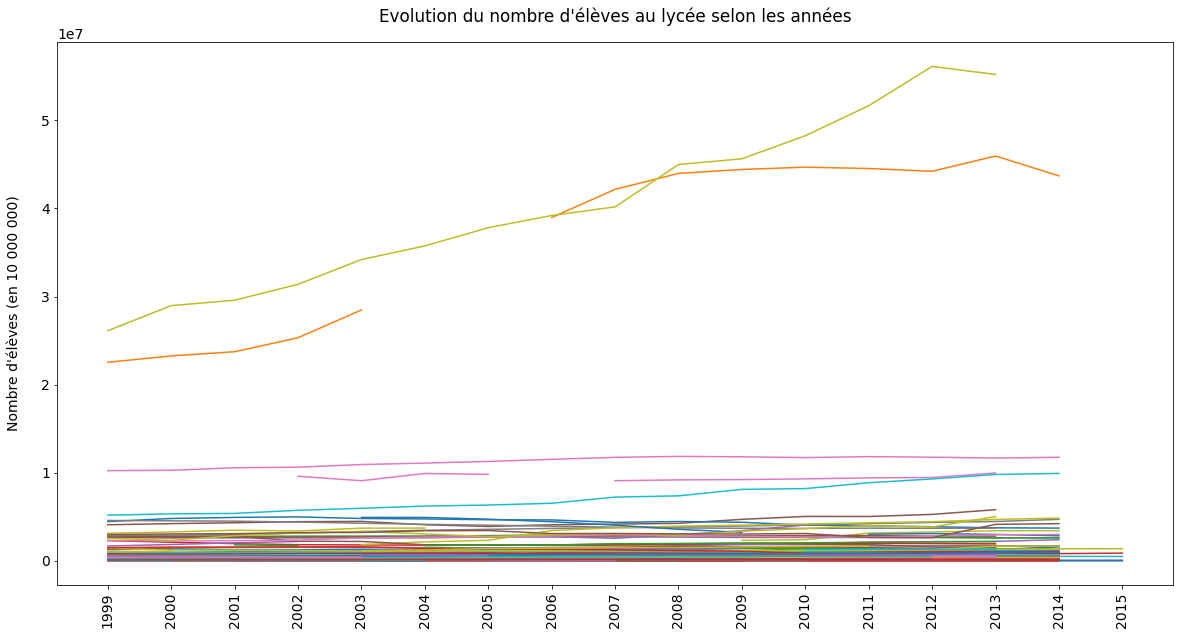

In [200]:
evolutionpaysannées(nombresecondary, nombresecondaryannées, titre = "Evolution du nombre d'élèves au lycée selon les années", axe_y = "Nombre d'élèves (en 10 000 000)")

In [201]:
#outliers
nombresecondary[nombresecondary['2000']>20000000]

Country Name Country Code  \
243104        China          CHN   
415359        India          IND   

                                           Indicator Name Indicator Code  \
243104  Enrolment in upper secondary education, both s...        UIS.E.3   
415359  Enrolment in upper secondary education, both s...        UIS.E.3   

              1999        2000        2001        2002        2003  \
243104  22528700.0  23255680.0  23726048.0  25317452.0  28471352.0   
415359  26115888.0  28965316.0  29582722.0  31387450.0  34204920.0   

              2004  ...        2009        2010        2011        2012  \
243104         NaN  ...  44435136.0  44693168.0  44543976.0  44224132.0   
415359  35748396.0  ...  45646428.0  48265864.0  51671416.0  56141888.0   

              2013        2014  2015  2016  2017  2020  
243104  45963232.0  43709224.0   NaN   NaN   NaN   NaN  
415359  55228676.0         NaN   NaN   NaN   NaN   NaN  

[2 rows x 24 columns]

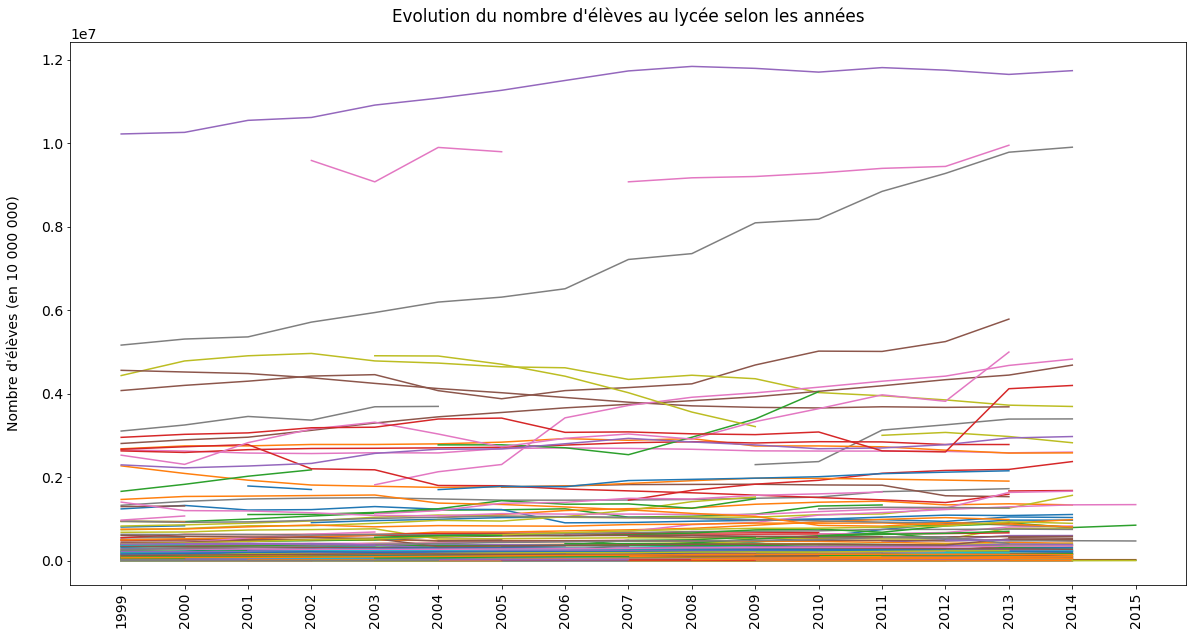

In [202]:
#la meme sans les deux outliers
evolutionpaysannées(nombresecondary[(nombresecondary['Country Name'] !='China') & (nombresecondary['Country Name'] !='India')], nombresecondaryannées, titre = "Evolution du nombre d'élèves au lycée selon les années", axe_y = "Nombre d'élèves (en 10 000 000)")

In [203]:
nombresecondary.shape

(217, 24)

In [204]:
nombresecondary["Nombre données"] = nombresecondaryannées.notna().sum(axis=1)

In [205]:
nombresecondary = nombresecondary[nombresecondary['Nombre données']>0]

In [206]:
nombresecondary.shape

(200, 25)

In [207]:
derniereannée(nombresecondary, nombresecondaryannées)

In [208]:
nombresecondary.head()

Country Name Country Code  \
92839   Afghanistan          AFG   
96504       Albania          ALB   
100169      Algeria          DZA   
107499      Andorra          AND   
111164       Angola          AGO   

                                           Indicator Name Indicator Code  \
92839   Enrolment in upper secondary education, both s...        UIS.E.3   
96504   Enrolment in upper secondary education, both s...        UIS.E.3   
100169  Enrolment in upper secondary education, both s...        UIS.E.3   
107499  Enrolment in upper secondary education, both s...        UIS.E.3   
111164  Enrolment in upper secondary education, both s...        UIS.E.3   

            1999      2000      2001       2002       2003       2004  ...  \
92839        NaN       NaN  159952.0        NaN   115583.0   173356.0  ...   
96504   102161.0  104946.0  110996.0   122555.0   132932.0   142449.0  ...   
100169  938291.0  934128.0  994347.0  1066937.0  1134161.0  1209247.0  ...   
107499       NaN       NaN       NaN      805.0      752.0      771.0  ...   
111164   70397.0   85461.0   94167.0   112787.0        NaN        NaN  ...   

             2011      2012      2013      2014  2015  2016  2017  2020  \
92839    743405.0  881415.0  969267.0  968769.0   NaN   NaN   NaN   NaN   
96504    150134.0  152182.0  154425.0  151937.0   NaN   NaN   NaN   NaN   
100169  1332584.0       NaN       NaN       NaN   NaN   NaN   NaN   NaN   
107499     1259.0    1182.0    1160.0    1288.0   NaN   NaN   NaN   NaN   
111164   303568.0       NaN       NaN       NaN   NaN   NaN   NaN   NaN   

        Nombre données  Année Last Data  
92839               13             2014  
96504               16             2014  
100169              13             2011  
107499              13             2014  
111164              10             2011  

[5 rows x 26 columns]

In [209]:
nombresecondarycomplété = nombresecondary.fillna(method = 'ffill', axis = 1)

In [210]:
nombresecondarycomplété.head()

Country Name Country Code  \
92839   Afghanistan          AFG   
96504       Albania          ALB   
100169      Algeria          DZA   
107499      Andorra          AND   
111164       Angola          AGO   

                                           Indicator Name Indicator Code  \
92839   Enrolment in upper secondary education, both s...        UIS.E.3   
96504   Enrolment in upper secondary education, both s...        UIS.E.3   
100169  Enrolment in upper secondary education, both s...        UIS.E.3   
107499  Enrolment in upper secondary education, both s...        UIS.E.3   
111164  Enrolment in upper secondary education, both s...        UIS.E.3   

           1999     2000     2001         2002         2003         2004  ...  \
92839   UIS.E.3  UIS.E.3   159952       159952       115583       173356  ...   
96504    102161   104946   110996       122555       132932       142449  ...   
100169   938291   934128   994347  1.06694e+06  1.13416e+06  1.20925e+06  ...   
107499  UIS.E.3  UIS.E.3  UIS.E.3          805          752          771  ...   
111164    70397    85461    94167       112787       112787       112787  ...   

               2011         2012         2013         2014         2015  \
92839        743405       881415       969267       968769       968769   
96504        150134       152182       154425       151937       151937   
100169  1.33258e+06  1.33258e+06  1.33258e+06  1.33258e+06  1.33258e+06   
107499         1259         1182         1160         1288         1288   
111164       303568       303568       303568       303568       303568   

               2016         2017         2020 Nombre données Année Last Data  
92839        968769       968769       968769             13            2014  
96504        151937       151937       151937             16            2014  
100169  1.33258e+06  1.33258e+06  1.33258e+06             13            2011  
107499         1288         1288         1288             13            2014  
111164       303568       303568       303568             10            2011  

[5 rows x 26 columns]

In [211]:
nombresecondarycomplété['2020'].astype(float).describe()

count    2.000000e+02
mean     1.234444e+06
std      5.146533e+06
min      3.530000e+02
25%      3.298475e+04
50%      1.742580e+05
75%      7.091480e+05
max      5.522868e+07
Name: 2020, dtype: float64

In [212]:
#sans outliers
nombresecondarycomplété[(nombresecondarycomplété['Country Name'] !='China') & (nombresecondarycomplété['Country Name'] !='India')]['2020'].astype(float).describe()

count    1.980000e+02
mean     7.472269e+05
std      1.600108e+06
min      3.530000e+02
25%      3.152625e+04
50%      1.672645e+05
75%      6.827675e+05
max      1.173632e+07
Name: 2020, dtype: float64

In [213]:
#selection de la mediane comme filtre car beaucoup moins sensible aux outliers que la moyenne (choix)
#ou selectionner moyenne sans les deux outliers?
#ou 75% ce qui fait ~700000 eleves minimums?

In [214]:
nombresecondarycomplétéfiltré = nombresecondarycomplété[nombresecondarycomplété['2020']>nombresecondarycomplété['2020'].median()]

In [215]:
nombresecondarycomplétéfiltré.head()

Country Name Country Code  \
92839   Afghanistan          AFG   
100169      Algeria          DZA   
111164       Angola          AGO   
118494    Argentina          ARG   
129489    Australia          AUS   

                                           Indicator Name Indicator Code  \
92839   Enrolment in upper secondary education, both s...        UIS.E.3   
100169  Enrolment in upper secondary education, both s...        UIS.E.3   
111164  Enrolment in upper secondary education, both s...        UIS.E.3   
118494  Enrolment in upper secondary education, both s...        UIS.E.3   
129489  Enrolment in upper secondary education, both s...        UIS.E.3   

               1999        2000         2001         2002         2003  \
92839       UIS.E.3     UIS.E.3       159952       159952       115583   
100169       938291      934128       994347  1.06694e+06  1.13416e+06   
111164        70397       85461        94167       112787       112787   
118494  1.32467e+06   1.419e+06  1.47528e+06  1.49605e+06  1.50666e+06   
129489  1.23813e+06  1.3215e+06  1.21122e+06  1.22129e+06  1.29415e+06   

               2004  ...         2011         2012         2013         2014  \
92839        173356  ...       743405       881415       969267       968769   
100169  1.20925e+06  ...  1.33258e+06  1.33258e+06  1.33258e+06  1.33258e+06   
111164       112787  ...       303568       303568       303568       303568   
118494  1.47625e+06  ...  1.65165e+06  1.68518e+06   1.7227e+06   1.7227e+06   
129489  1.23246e+06  ...  1.04086e+06  1.08837e+06  1.07957e+06  1.10416e+06   

               2015         2016         2017         2020 Nombre données  \
92839        968769       968769       968769       968769             13   
100169  1.33258e+06  1.33258e+06  1.33258e+06  1.33258e+06             13   
111164       303568       303568       303568       303568             10   
118494   1.7227e+06   1.7227e+06   1.7227e+06   1.7227e+06             15   
129489  1.10416e+06  1.10416e+06  1.10416e+06  1.10416e+06             16   

       Année Last Data  
92839             2014  
100169            2011  
111164            2011  
118494            2013  
129489            2014  

[5 rows x 26 columns]

In [216]:
nombresecondarycomplétéfiltré = nombresecondarycomplétéfiltré[['Country Name','Country Code', 'Indicator Name', 'Indicator Code', '2020', 'Année Last Data' ]]

In [217]:
nombresecondarycomplétéfiltré = nombresecondarycomplétéfiltré.rename(columns={'2020':'Last Data'})

In [218]:
nombresecondarycomplétéfiltré

Country Name Country Code  \
92839     Afghanistan          AFG   
100169        Algeria          DZA   
111164         Angola          AGO   
118494      Argentina          ARG   
129489      Australia          AUS   
...               ...          ...   
847829  United States          USA   
855159     Uzbekistan          UZB   
862489  Venezuela, RB          VEN   
877149    Yemen, Rep.          YEM   
884479       Zimbabwe          ZWE   

                                           Indicator Name Indicator Code  \
92839   Enrolment in upper secondary education, both s...        UIS.E.3   
100169  Enrolment in upper secondary education, both s...        UIS.E.3   
111164  Enrolment in upper secondary education, both s...        UIS.E.3   
118494  Enrolment in upper secondary education, both s...        UIS.E.3   
129489  Enrolment in upper secondary education, both s...        UIS.E.3   
...                                                   ...            ...   
847829  Enrolment in upper secondary education, both s...        UIS.E.3   
855159  Enrolment in upper secondary education, both s...        UIS.E.3   
862489  Enrolment in upper secondary education, both s...        UIS.E.3   
877149  Enrolment in upper secondary education, both s...        UIS.E.3   
884479  Enrolment in upper secondary education, both s...        UIS.E.3   

          Last Data Année Last Data  
92839        968769            2014  
100169  1.33258e+06            2011  
111164       303568            2011  
118494   1.7227e+06            2013  
129489  1.10416e+06            2014  
...             ...             ...  
847829  1.17363e+07            2014  
855159  1.64327e+06            2011  
862489       892370            2014  
877149       701984            2013  
884479       490522            2013  

[100 rows x 6 columns]

In [219]:
seriestertiary[seriestertiary['Indicator Name']=='Enrolment in tertiary education, all programmes, both sexes (number)']

Series Code     Topic  \
2332  SE.TER.ENRL  Tertiary   

                                         Indicator Name Short definition  \
2332  Enrolment in tertiary education, all programme...              NaN   

                                        Long definition Periodicity  \
2332  The total number of students enrolled at publi...         NaN   

     Base Period Other notes Aggregation method Limitations and exceptions  \
2332         NaN         NaN                NaN                        NaN   

     General comments                           Source  \
2332              NaN  UNESCO Institute for Statistics   

     Statistical concept and methodology Development relevance  \
2332                                 NaN                   NaN   

     Related source links  
2332                  NaN

In [220]:
nombretertiary = datapayspresent[datapayspresent['Indicator Code']=='SE.TER.ENRL']

In [221]:
nombretertiary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 92829 to 884469
Data columns (total 53 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Country Code    217 non-null    object 
 2   Indicator Name  217 non-null    object 
 3   Indicator Code  217 non-null    object 
 4   1970            37 non-null     float64
 5   1971            121 non-null    float64
 6   1972            111 non-null    float64
 7   1973            112 non-null    float64
 8   1974            108 non-null    float64
 9   1975            111 non-null    float64
 10  1976            110 non-null    float64
 11  1977            111 non-null    float64
 12  1978            112 non-null    float64
 13  1979            120 non-null    float64
 14  1980            119 non-null    float64
 15  1981            137 non-null    float64
 16  1982            123 non-null    float64
 17  1983            119 non-null

In [222]:
nombretertiary = masque_année(nombretertiary, 1970,1998)

In [223]:
nombretertiaryannées = nombretertiary.drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis = 1)

In [224]:
nombretertiary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 92829 to 884469
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Country Code    217 non-null    object 
 2   Indicator Name  217 non-null    object 
 3   Indicator Code  217 non-null    object 
 4   1999            133 non-null    float64
 5   2000            124 non-null    float64
 6   2001            123 non-null    float64
 7   2002            133 non-null    float64
 8   2003            134 non-null    float64
 9   2004            134 non-null    float64
 10  2005            129 non-null    float64
 11  2006            129 non-null    float64
 12  2007            129 non-null    float64
 13  2008            134 non-null    float64
 14  2009            137 non-null    float64
 15  2010            140 non-null    float64
 16  2011            142 non-null    float64
 17  2012            141 non-null

In [225]:
nombretertiary["Nombre données"] = nombretertiaryannées.notna().sum(axis = 1)

In [226]:
nombretertiary = nombretertiary[nombretertiary["Nombre données"]>0]

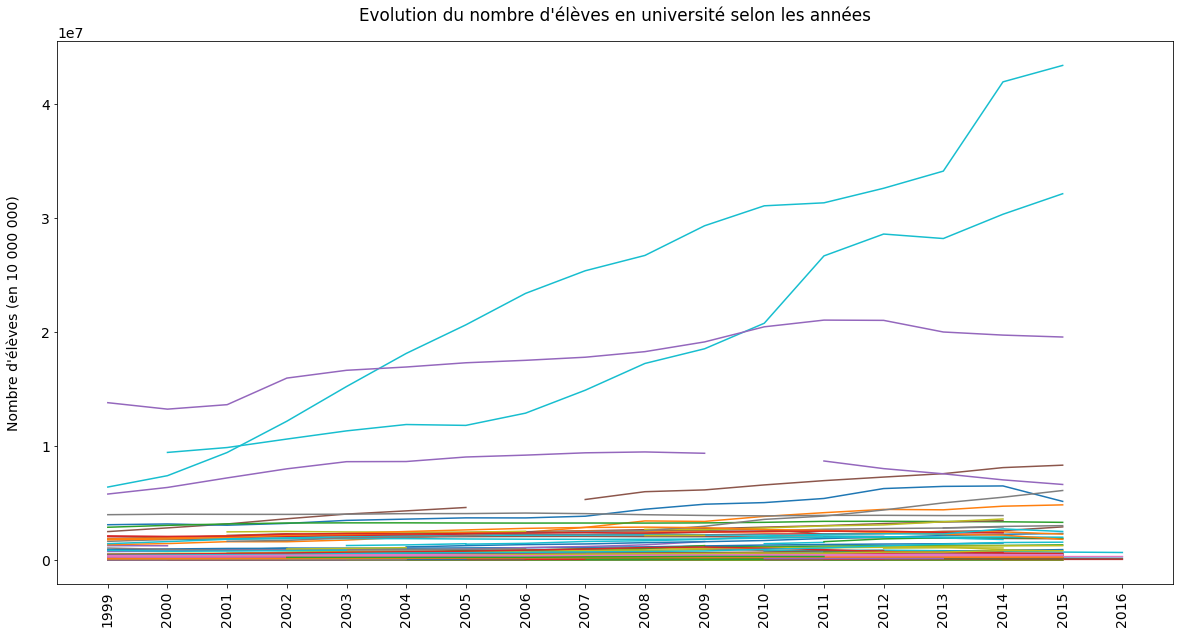

In [227]:
evolutionpaysannées(nombretertiary, nombretertiaryannées, titre = "Evolution du nombre d'élèves en université selon les années", axe_y = "Nombre d'élèves (en 10 000 000)")

In [228]:
# 3 outliers
nombretertiary[nombretertiary['2008']>10000000]

Country Name Country Code  \
243094          China          CHN   
415349          India          IND   
847819  United States          USA   

                                           Indicator Name Indicator Code  \
243094  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
415349  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
847819  Enrolment in tertiary education, all programme...    SE.TER.ENRL   

              1999        2000        2001        2002        2003  \
243094   6365625.0   7364111.0   9398581.0  12143723.0  15186217.0   
415349         NaN   9404460.0   9834046.0  10576653.0  11295041.0   
847819  13769362.0  13202880.0  13595580.0  15927987.0  16611711.0   

              2004  ...        2010        2011        2012        2013  \
243094  18090814.0  ...  31046736.0  31308378.0  32585960.0  34091288.0   
415349  11852936.0  ...  20740740.0  26650952.0  28568408.0  28175136.0   
847819  16900472.0  ...  20427708.0  21016126.0  20994112.0  19972624.0   

              2014        2015  2016  2017  2020  Nombre données  
243094  41924200.0  43367392.0   NaN   NaN   NaN              17  
415349  30305848.0  32107420.0   NaN   NaN   NaN              16  
847819  19700220.0  19531728.0   NaN   NaN   NaN              17  

[3 rows x 25 columns]

In [229]:
derniereannée(nombretertiary,nombretertiaryannées)

In [230]:
nombretertiary.head()

Country Name Country Code  \
92829      Afghanistan          AFG   
96494          Albania          ALB   
100159         Algeria          DZA   
103824  American Samoa          ASM   
107489         Andorra          AND   

                                           Indicator Name Indicator Code  \
92829   Enrolment in tertiary education, all programme...    SE.TER.ENRL   
96494   Enrolment in tertiary education, all programme...    SE.TER.ENRL   
100159  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
103824  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
107489  Enrolment in tertiary education, all programme...    SE.TER.ENRL   

            1999     2000      2001      2002      2003      2004  ...  \
92829        NaN      NaN       NaN       NaN   26211.0   27648.0  ...   
96494    38502.0  40125.0   40859.0   42160.0   43600.0   53014.0  ...   
100159  456358.0      NaN  549009.0  624788.0  682775.0  716452.0  ...   
103824       NaN      NaN       NaN       NaN       NaN       NaN  ...   
107489       NaN      NaN       NaN     267.0     306.0     331.0  ...   

             2011       2012       2013       2014       2015  2016  2017  \
92829     97504.0        NaN        NaN   262874.0        NaN   NaN   NaN   
96494    134877.0   160839.0   173029.0   173819.0   160527.0   NaN   NaN   
100159  1188562.0  1210272.0  1252579.0  1245478.0  1289474.0   NaN   NaN   
103824        NaN        NaN        NaN        NaN        NaN   NaN   NaN   
107489        NaN      491.0      538.0      498.0      501.0   NaN   NaN   

        2020  Nombre données  Année Last Data  
92829    NaN               5             2014  
96494    NaN              17             2015  
100159   NaN              15             2015  
103824   NaN               1             2007  
107489   NaN              10             2015  

[5 rows x 26 columns]

In [231]:
nombretertiarycomplété = nombretertiary.fillna(method='ffill', axis = 1)

In [232]:
nombretertiarycomplété['2020'].astype(float).describe()

count    1.950000e+02
mean     1.087968e+06
std      4.195019e+06
min      1.940000e+02
25%      1.882500e+04
50%      1.679830e+05
75%      4.786620e+05
max      4.336739e+07
Name: 2020, dtype: float64

In [233]:
#Pariel mais sans les outsiders
nombretertiarycomplété[(nombretertiarycomplété['Country Name'] !='China') & (nombretertiarycomplété['Country Name'] !='India') & (nombretertiarycomplété['Country Name'] !='United States')]['2020'].astype(float).describe()

count    1.920000e+02
mean     6.101414e+05
std      1.211381e+06
min      1.940000e+02
25%      1.810250e+04
50%      1.637090e+05
75%      4.435652e+05
max      8.285475e+06
Name: 2020, dtype: float64

In [234]:
#choix de la mediane comme précédent
nombretertiarycomplétéfiltré = nombretertiarycomplété[nombretertiarycomplété['2020']>nombretertiarycomplété['2020'].median()]

In [235]:
nombretertiarycomplétéfiltré = nombretertiarycomplétéfiltré[["Country Name", "Country Code", "Indicator Name", "Indicator Code", "2020", "Année Last Data"]]

In [236]:
nombretertiarycomplétéfiltré = nombretertiarycomplétéfiltré.rename(columns={"2020":"Last Data"})

In [237]:
nombretertiarycomplétéfiltré.head()

Country Name Country Code  \
92829   Afghanistan          AFG   
100159      Algeria          DZA   
111154       Angola          AGO   
118484    Argentina          ARG   
129479    Australia          AUS   

                                           Indicator Name Indicator Code  \
92829   Enrolment in tertiary education, all programme...    SE.TER.ENRL   
100159  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
111154  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
118484  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
129479  Enrolment in tertiary education, all programme...    SE.TER.ENRL   

          Last Data Année Last Data  
92829        262874            2014  
100159  1.28947e+06            2015  
111154       221037            2015  
118484  2.86945e+06            2014  
129479  1.45352e+06            2014

# Liste pays indicateurs selectionnés atm

In [238]:
internetuserspayscomplétéfiltré.head()

Country Name Country Code                   Indicator Name  \
96665               Albania          ALB  Internet users (per 100 people)   
107660              Andorra          AND  Internet users (per 100 people)   
114990  Antigua and Barbuda          ATG  Internet users (per 100 people)   
118655            Argentina          ARG  Internet users (per 100 people)   
122320              Armenia          ARM  Internet users (per 100 people)   

        Indicator Code Last Data Année Last Data  
96665   IT.NET.USER.P2   66.3634            2016  
107660  IT.NET.USER.P2   97.9306            2016  
114990  IT.NET.USER.P2        73            2016  
118655  IT.NET.USER.P2   70.1508            2016  
122320  IT.NET.USER.P2        62            2016

In [239]:
internetuserspayscomplétéfiltré['Country Name'].unique()

array(['Albania', 'Andorra', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas, The', 'Bahrain', 'Barbados', 'Belarus', 'Belgium',
       'Bermuda', 'Bosnia and Herzegovina', 'Brazil', 'Brunei Darussalam',
       'Bulgaria', 'Canada', 'Cayman Islands', 'Chile', 'China',
       'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'Estonia',
       'Faroe Islands', 'Finland', 'France', 'French Polynesia',
       'Georgia', 'Germany', 'Gibraltar', 'Greece', 'Greenland',
       'Grenada', 'Guam', 'Hong Kong SAR, China', 'Hungary', 'Iceland',
       'Iran, Islamic Rep.', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Jordan', 'Kazakhstan', 'Korea, Rep.', 'Kuwait', 'Latvia',
       'Lebanon', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Macao SAR, China', 'Macedonia, FYR', 'Malaysia', 'Maldives',
       'Malta', 'Mauritius', 'Mexico', 'Moldova',

In [240]:
datatertiarycomplétéfiltré.head()

Country Name Country Code  \
96629       Albania          ALB   
118619    Argentina          ARG   
129614    Australia          AUS   
133279      Austria          AUT   
151604     Barbados          BRB   

                                         Indicator Name Indicator Code  \
96629   Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
118619  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
129614  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
133279  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   
151604  Gross enrolment ratio, tertiary, both sexes (%)    SE.TER.ENRR   

       Last Data Année Last Data  
96629      58.11            2015  
118619   82.9174            2014  
129614   90.3065            2014  
133279   81.5405            2015  
151604   65.4322            2011

In [241]:
datatertiarycomplétéfiltré['Country Name'].unique()

array(['Albania', 'Argentina', 'Australia', 'Austria', 'Barbados',
       'Belarus', 'Belgium', 'Bulgaria', 'Canada', 'Chile', 'Colombia',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Grenada',
       'Hong Kong SAR, China', 'Iceland', 'Iran, Islamic Rep.', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Korea, Rep.', 'Latvia', 'Libya',
       'Lithuania', 'Macao SAR, China', 'Mongolia', 'Montenegro',
       'Netherlands', 'New Zealand', 'Norway', 'Palau', 'Poland',
       'Portugal', 'Puerto Rico', 'Russian Federation', 'San Marino',
       'Saudi Arabia', 'Serbia', 'Slovenia', 'Spain',
       'St. Kitts and Nevis', 'Sweden', 'Switzerland', 'Turkey',
       'Ukraine', 'United Kingdom', 'United States', 'Uruguay',
       'Venezuela, RB'], dtype=object)

In [242]:
datasecondarycomplétéfiltré.head()

Country Name Country Code  \
96633               Albania          ALB   
114958  Antigua and Barbuda          ATG   
118623            Argentina          ARG   
122288              Armenia          ARM   
125953                Aruba          ABW   

                                           Indicator Name  Indicator Code  \
96633   Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
114958  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
118623  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
122288  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   
125953  Gross enrolment ratio, upper secondary, both s...  SE.SEC.ENRR.UP   

       Last Data Année Last Data  
96633    89.4603            2015  
114958   82.0246            2015  
118623   85.2326            2014  
122288    89.927            2015  
125953   106.326            2012

In [243]:
datasecondarycomplétéfiltré['Country Name'].unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Bahamas, The', 'Bahrain', 'Barbados',
       'Belarus', 'Belgium', 'Bolivia', 'Brazil', 'Brunei Darussalam',
       'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic',
       'Denmark', 'Dominica', 'Ecuador', 'Estonia', 'Finland', 'France',
       'Georgia', 'Germany', 'Greece', 'Grenada', 'Guyana',
       'Hong Kong SAR, China', 'Hungary', 'Iceland', 'Iran, Islamic Rep.',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan',
       'Korea, Dem. People’s Rep.', 'Korea, Rep.', 'Kuwait',
       'Kyrgyz Republic', 'Latvia', 'Libya', 'Liechtenstein', 'Lithuania',
       'Luxembourg', 'Macao SAR, China', 'Malta', 'Mauritius', 'Moldova',
       'Mongolia', 'Montenegro', 'Nauru', 'Netherlands', 'New Zealand',
       'Norway', 'Oman', 'Palau', 'Peru', 'Poland', 'Portugal', 'Qatar',
       'Romania', 'Russi

In [244]:
datagdpcomplétéfiltré.head()

Country Name Country Code                Indicator Name  \
107530       Andorra          AND  GDP per capita (current US$)   
125855         Aruba          ABW  GDP per capita (current US$)   
129520     Australia          AUS  GDP per capita (current US$)   
133185       Austria          AUT  GDP per capita (current US$)   
140515  Bahamas, The          BHS  GDP per capita (current US$)   

        Indicator Code Last Data Année Last Data  
107530  NY.GDP.PCAP.CD   36988.6            2016  
125855  NY.GDP.PCAP.CD   25324.7            2011  
129520  NY.GDP.PCAP.CD   49927.8            2016  
133185  NY.GDP.PCAP.CD   44676.3            2016  
140515  NY.GDP.PCAP.CD   28785.5            2016

In [245]:
datagdpcomplétéfiltré['Country Name'].unique()

array(['Andorra', 'Aruba', 'Australia', 'Austria', 'Bahamas, The',
       'Bahrain', 'Belgium', 'Bermuda', 'Brunei Darussalam', 'Canada',
       'Cayman Islands', 'Channel Islands', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Faroe Islands', 'Finland', 'France',
       'Germany', 'Greece', 'Greenland', 'Guam', 'Hong Kong SAR, China',
       'Iceland', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Japan',
       'Korea, Rep.', 'Kuwait', 'Liechtenstein', 'Luxembourg',
       'Macao SAR, China', 'Malta', 'Monaco', 'Netherlands',
       'New Zealand', 'Northern Mariana Islands', 'Norway', 'Portugal',
       'Puerto Rico', 'Qatar', 'San Marino', 'Saudi Arabia', 'Singapore',
       'Slovak Republic', 'Slovenia', 'Spain', 'St. Kitts and Nevis',
       'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom',
       'United States', 'Virgin Islands (U.S.)'], dtype=object)

In [246]:
nombresecondarycomplétéfiltré.head()

Country Name Country Code  \
92839   Afghanistan          AFG   
100169      Algeria          DZA   
111164       Angola          AGO   
118494    Argentina          ARG   
129489    Australia          AUS   

                                           Indicator Name Indicator Code  \
92839   Enrolment in upper secondary education, both s...        UIS.E.3   
100169  Enrolment in upper secondary education, both s...        UIS.E.3   
111164  Enrolment in upper secondary education, both s...        UIS.E.3   
118494  Enrolment in upper secondary education, both s...        UIS.E.3   
129489  Enrolment in upper secondary education, both s...        UIS.E.3   

          Last Data Année Last Data  
92839        968769            2014  
100169  1.33258e+06            2011  
111164       303568            2011  
118494   1.7227e+06            2013  
129489  1.10416e+06            2014

In [247]:
nombresecondarycomplétéfiltré['Country Name'].unique()

array(['Afghanistan', 'Algeria', 'Angola', 'Argentina', 'Australia',
       'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium',
       'Benin', 'Bolivia', 'Brazil', 'Bulgaria', 'Cambodia', 'Cameroon',
       'Canada', 'Chile', 'China', 'Colombia', 'Congo, Dem. Rep.',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Czech Republic', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Ethiopia', 'Finland', 'France', 'Germany', 'Ghana', 'Greece',
       'Guatemala', 'Guinea', 'Honduras', 'Hong Kong SAR, China',
       'Hungary', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq',
       'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya',
       'Korea, Dem. People’s Rep.', 'Korea, Rep.', 'Kyrgyz Republic',
       'Lao PDR', 'Libya', 'Madagascar', 'Malaysia', 'Mali', 'Mexico',
       'Morocco', 'Myanmar', 'Nepal', 'Netherlands', 'New Zealand',
       'Nigeria', 'Norway', 'Pakistan', 'Paraguay', 'Peru', 'Philippines',
       'Poland', '

In [248]:
nombretertiarycomplétéfiltré.head()

Country Name Country Code  \
92829   Afghanistan          AFG   
100159      Algeria          DZA   
111154       Angola          AGO   
118484    Argentina          ARG   
129479    Australia          AUS   

                                           Indicator Name Indicator Code  \
92829   Enrolment in tertiary education, all programme...    SE.TER.ENRL   
100159  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
111154  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
118484  Enrolment in tertiary education, all programme...    SE.TER.ENRL   
129479  Enrolment in tertiary education, all programme...    SE.TER.ENRL   

          Last Data Année Last Data  
92829        262874            2014  
100159  1.28947e+06            2015  
111154       221037            2015  
118484  2.86945e+06            2014  
129479  1.45352e+06            2014

In [249]:
nombretertiarycomplétéfiltré['Country Name'].unique()

array(['Afghanistan', 'Algeria', 'Angola', 'Argentina', 'Australia',
       'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium',
       'Bolivia', 'Brazil', 'Bulgaria', 'Cambodia', 'Cameroon', 'Canada',
       'Chile', 'China', 'Colombia', 'Congo, Dem. Rep.', 'Costa Rica',
       "Cote d'Ivoire", 'Cuba', 'Czech Republic', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Ethiopia', 'Finland', 'France', 'Germany', 'Ghana', 'Greece',
       'Guatemala', 'Honduras', 'Hong Kong SAR, China', 'Hungary',
       'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan',
       'Korea, Dem. People’s Rep.', 'Korea, Rep.', 'Kyrgyz Republic',
       'Lebanon', 'Libya', 'Malaysia', 'Mexico', 'Mongolia', 'Morocco',
       'Mozambique', 'Myanmar', 'Nepal', 'Netherlands', 'New Zealand',
       'Nigeria', 'Norway', 'Pakistan', 'Paraguay', 'Peru', 'Philippines',
       'Poland', 'Portugal',

In [250]:
#mise en commun
test = pd.concat([internetuserspayscomplétéfiltré, nombretertiarycomplétéfiltré, nombresecondarycomplétéfiltré, datagdpcomplétéfiltré])

In [251]:
test

Country Name Country Code                   Indicator Name  \
96665                 Albania          ALB  Internet users (per 100 people)   
107660                Andorra          AND  Internet users (per 100 people)   
114990    Antigua and Barbuda          ATG  Internet users (per 100 people)   
118655              Argentina          ARG  Internet users (per 100 people)   
122320                Armenia          ARM  Internet users (per 100 people)   
...                       ...          ...                              ...   
781890            Switzerland          CHE     GDP per capita (current US$)   
840530   United Arab Emirates          ARE     GDP per capita (current US$)   
844195         United Kingdom          GBR     GDP per capita (current US$)   
847860          United States          USA     GDP per capita (current US$)   
869850  Virgin Islands (U.S.)          VIR     GDP per capita (current US$)   

        Indicator Code Last Data Année Last Data  
96665   IT.NET.USER.P2   66.3634            2016  
107660  IT.NET.USER.P2   97.9306            2016  
114990  IT.NET.USER.P2        73            2016  
118655  IT.NET.USER.P2   70.1508            2016  
122320  IT.NET.USER.P2        62            2016  
...                ...       ...             ...  
781890  NY.GDP.PCAP.CD   79890.5            2016  
840530  NY.GDP.PCAP.CD   37622.2            2016  
844195  NY.GDP.PCAP.CD   40341.4            2016  
847860  NY.GDP.PCAP.CD   57638.2            2016  
869850  NY.GDP.PCAP.CD   36350.8            2015  

[363 rows x 6 columns]

In [252]:
#petit point sur les années de dernieres données
test['Année Last Data'].unique()

array(['2016', '2015', '2014', '2007', '2000', '2013', '2005', '2003',
       '2012', '2011', '2010', '2009', '2008', '2006'], dtype=object)

In [253]:
listepays = test.pivot(index = 'Country Name', columns = 'Indicator Code', values = 'Last Data') 
#afficher les dernieres valeurs des indicateurs par pays

In [254]:
listepays

Indicator Code        IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3
Country Name                                                                 
Afghanistan                      NaN            NaN       262874       968769
Albania                      66.3634            NaN          NaN          NaN
Algeria                          NaN            NaN  1.28947e+06  1.33258e+06
Andorra                      97.9306        36988.6          NaN          NaN
Angola                           NaN            NaN       221037       303568
...                              ...            ...          ...          ...
Vietnam                          NaN            NaN  2.46664e+06          NaN
Virgin Islands (U.S.)        59.6083        36350.8          NaN          NaN
West Bank and Gaza           61.1784            NaN       221018          NaN
Yemen, Rep.                      NaN            NaN       267498       701984
Zimbabwe                         NaN            NaN          NaN       490522

[161 rows x 4 columns]

In [255]:
listepaysfinale = listepays.dropna() #pays qui vérifient toutes les conditions

In [256]:
listepaysfinale

Indicator Code       IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3
Country Name                                                                
Australia                   88.2387        49927.8  1.45352e+06  1.10416e+06
Austria                     84.3233        44676.3       425972       363188
Belgium                     86.5165        41236.3       504745       776413
Canada                        89.84        42157.9  1.21216e+06  1.53139e+06
Czech Republic              76.4812        18491.9       395529       414371
Denmark                     96.9678        53549.7       313756       311359
Finland                     87.7036        43402.9       302478       357550
France                      85.6222          36855  2.38888e+06  2.59836e+06
Germany                     89.6471        42069.6  2.97778e+06  2.57995e+06
Greece                      69.0879        17930.2       677429       371024
Hong Kong SAR, China        87.3003        43681.4       298643       225437
Israel                      79.7788        37175.7       374048       369316
Italy                       61.3243        30674.8  1.82648e+06  2.78044e+06
Japan                            92        38900.6  3.86246e+06  3.68292e+06
Korea, Rep.                 92.7165        27538.8   3.2681e+06  1.90386e+06
Netherlands                  90.411        45669.8       842601       746415
New Zealand                 88.4702        39416.4       270074       249314
Norway                      97.2982        70911.8       268231       249882
Portugal                    70.4236        19839.6       337507       385210
Saudi Arabia                73.7509        20028.6  1.52777e+06  1.67861e+06
Slovak Republic             80.4759        16535.9       197854       207550
Spain                       80.5613        26639.7  1.96392e+06  1.66258e+06
Sweden                      91.5068        51949.3       428557       502035
Switzerland                 89.4056        79890.5       294450       350927
United Kingdom              94.7758        40341.4  2.35293e+06  4.19508e+06
United States               76.1767        57638.2  1.95317e+07  1.17363e+07

# Indicateurs statistique des pays selectionnés

In [257]:
listepaysfinale.astype(float).describe()

Indicator Code  IT.NET.USER.P2  NY.GDP.PCAP.CD   SE.TER.ENRL       UIS.E.3
count                26.000000       26.000000  2.600000e+01  2.600000e+01
mean                 84.646318    39889.623547  1.857600e+06  1.589756e+06
std                   9.033842    15643.449427  3.759458e+06  2.364801e+06
min                  61.324253    16535.916864  1.978540e+05  2.075500e+05
25%                  79.953068    28322.813613  3.196938e+05  3.589594e+05
50%                  87.501997    40788.837417  5.910870e+05  6.242250e+05
75%                  90.268219    45421.447560  1.929562e+06  1.847546e+06
max                  97.298204    79890.524005  1.953173e+07  1.173632e+07

In [258]:
#rajouter zone

<AxesSubplot:>

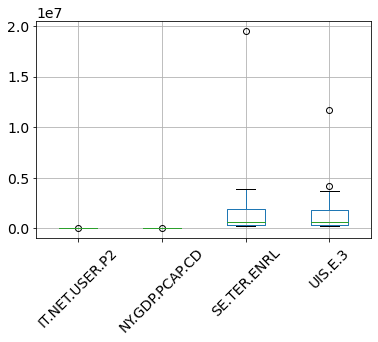

In [259]:
listepaysfinale.astype(float).boxplot(rot = 45)

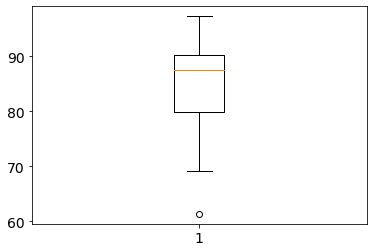

In [260]:
plt.boxplot(listepaysfinale['IT.NET.USER.P2']);

In [261]:
listepaysfinale.head()

Indicator Code IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3
Country Name                                                          
Australia             88.2387        49927.8  1.45352e+06  1.10416e+06
Austria               84.3233        44676.3       425972       363188
Belgium               86.5165        41236.3       504745       776413
Canada                  89.84        42157.9  1.21216e+06  1.53139e+06
Czech Republic        76.4812        18491.9       395529       414371

In [262]:
def tracerboxplot(df):
    
    #tracer la figure
    fig = plt.figure(figsize =(12,8))
    j=1
    
    #boucle sur chaque indicateur pour les subplots
    for i in df.columns:
        fig.add_subplot(2,2,j)
        plt.boxplot(listepaysfinale[i])
        plt.xticks([1],[i]) #modifier le tick d'absice avec l'indicateur code
        j+=1
        
#a ajouter : liste avec indicateurs et conditions sur indicateur pour legender (titre et absice y, voir recup un nom d'indicateur plutot que le code?)

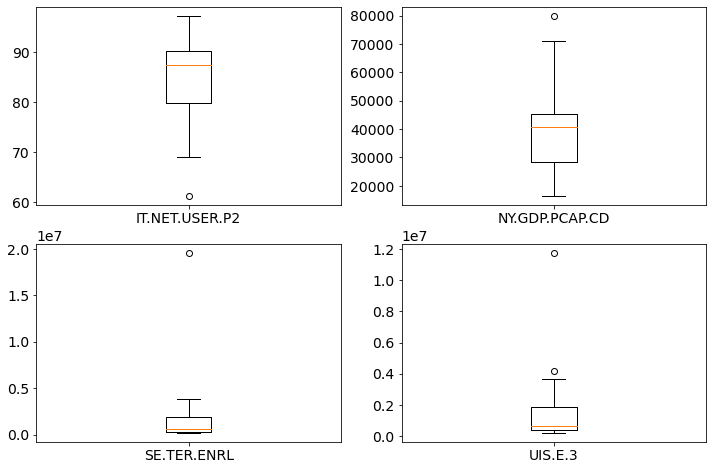

In [263]:
tracerboxplot(listepaysfinale)

In [264]:
# reprendre la table data pour pays selectionnés ci dessus pour historique des valeurs

In [265]:
payschoisis = listepaysfinale.index.values

In [266]:
payschoisis

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Czech Republic',
       'Denmark', 'Finland', 'France', 'Germany', 'Greece',
       'Hong Kong SAR, China', 'Israel', 'Italy', 'Japan', 'Korea, Rep.',
       'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Saudi Arabia',
       'Slovak Republic', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom', 'United States'], dtype=object)

In [267]:
indicateurschoisis = listepaysfinale.columns.values

In [268]:
indicateurschoisis

array(['IT.NET.USER.P2', 'NY.GDP.PCAP.CD', 'SE.TER.ENRL', 'UIS.E.3'],
      dtype=object)

In [269]:
datapresent[(datapresent['Country Name'].isin(payschoisis))&(datapresent['Indicator Code'].isin(indicateurschoisis))]

Country Name Country Code  \
129479       Australia          AUS   
129489       Australia          AUS   
129520       Australia          AUS   
129650       Australia          AUS   
133144         Austria          AUT   
...                ...          ...   
844325  United Kingdom          GBR   
847819   United States          USA   
847829   United States          USA   
847860   United States          USA   
847990   United States          USA   

                                           Indicator Name  Indicator Code  \
129479  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
129489  Enrolment in upper secondary education, both s...         UIS.E.3   
129520                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
129650                    Internet users (per 100 people)  IT.NET.USER.P2   
133144  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
...                                                   ...             ...   
844325                    Internet users (per 100 people)  IT.NET.USER.P2   
847819  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
847829  Enrolment in upper secondary education, both s...         UIS.E.3   
847860                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
847990                    Internet users (per 100 people)  IT.NET.USER.P2   

                 1970          1971          1972          1973          1974  \
129479  179664.000000  1.935320e+05  2.081490e+05  2.238550e+05  2.529720e+05   
129489            NaN           NaN           NaN           NaN           NaN   
129520    3302.529573  3.492549e+03  3.946536e+03  4.766980e+03  6.478643e+03   
129650            NaN           NaN           NaN           NaN           NaN   
133144            NaN  5.977800e+04  6.640100e+04  7.346700e+04  7.878700e+04   
...               ...           ...           ...           ...           ...   
844325            NaN           NaN           NaN           NaN           NaN   
847819            NaN  8.498117e+06  8.948645e+06  9.297787e+06  9.602123e+06   
847829            NaN           NaN           NaN           NaN           NaN   
847860    5246.883717  5.623444e+03  6.109926e+03  6.741332e+03  7.242441e+03   
847990            NaN           NaN           NaN           NaN           NaN   

                1975  ...          2009          2010          2011  \
129479  2.747380e+05  ...  1.199845e+06  1.276488e+06  1.324257e+06   
129489           NaN  ...  9.623800e+05  9.909510e+05  1.040865e+06   
129520  6.998240e+03  ...  4.274300e+04  5.187408e+04  6.224510e+04   
129650           NaN  ...  7.425000e+01  7.600000e+01  7.948770e+01   
133144  8.410100e+04  ...  3.081500e+05  3.501870e+05  3.617970e+05   
...              ...  ...           ...           ...           ...   
844325           NaN  ...  8.356000e+01  8.500000e+01  8.538000e+01   
847819  1.022373e+07  ...  1.910281e+07  2.042771e+07  2.101613e+07   
847829           NaN  ...  1.179106e+07  1.170128e+07  1.180938e+07   
847860  7.820065e+03  ...  4.700156e+04  4.837388e+04  4.979067e+04   
847990           NaN  ...  7.100000e+01  7.169000e+01  6.972946e+01   

                2012          2013          2014          2015          2016  \
129479  1.364203e+06  1.390478e+06  1.453521e+06           NaN           NaN   
129489  1.088366e+06  1.079568e+06  1.104162e+06           NaN           NaN   
129520  6.767763e+04  6.779230e+04  6.221461e+04  5.655404e+04  49927.819509   
129650  7.900000e+01  8.345350e+01  8.400000e+01  8.456052e+01     88.238658   
133144  3.764980e+05  4.227782e+05  4.212248e+05  4.259717e+05           NaN   
...              ...           ...           ...           ...           ...   
844325  8.748000e+01  8.984410e+01  9.161000e+01  9.200030e+01     94.775801   
847819  2.099411e+07  1.997262e+07  1.970022e+07  1.953173e+07           NaN   
847829  1.174826e+07  1.164642e+07  1.173632e+07           NaN        

In [270]:
#ajouter masqueannée

In [271]:
def tracerindicateurspays(pays):
    
    dicindic = {'IT.NET.USER.P2':'Taux internet en %', 'UIS.E.3': "Nombre d'élèves au Lycée", "SE.TER.ENRL": "Nombre d'élèves en Université", "NY.GDP.PCAP.CD": "GDP par habitant (US$)"}
    df = datapresent[(datapresent['Country Name']==pays)&(datapresent['Indicator Code'].isin(indicateurschoisis))]
    df = df.set_index(df['Indicator Code']).drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis = 1)
    df = df.T
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Appercu des indicateurs selctionnés pour le pays ' + pays)
    j=1
    
    for i in df.columns:
        fig.add_subplot(2,2,j)
        df[i].plot()
        plt.ylabel(ylabel=dicindic[i],labelpad=20)
        plt.xticks(rotation =45)
        j+=1

#ajouter legende en fonction indicateur représenté        

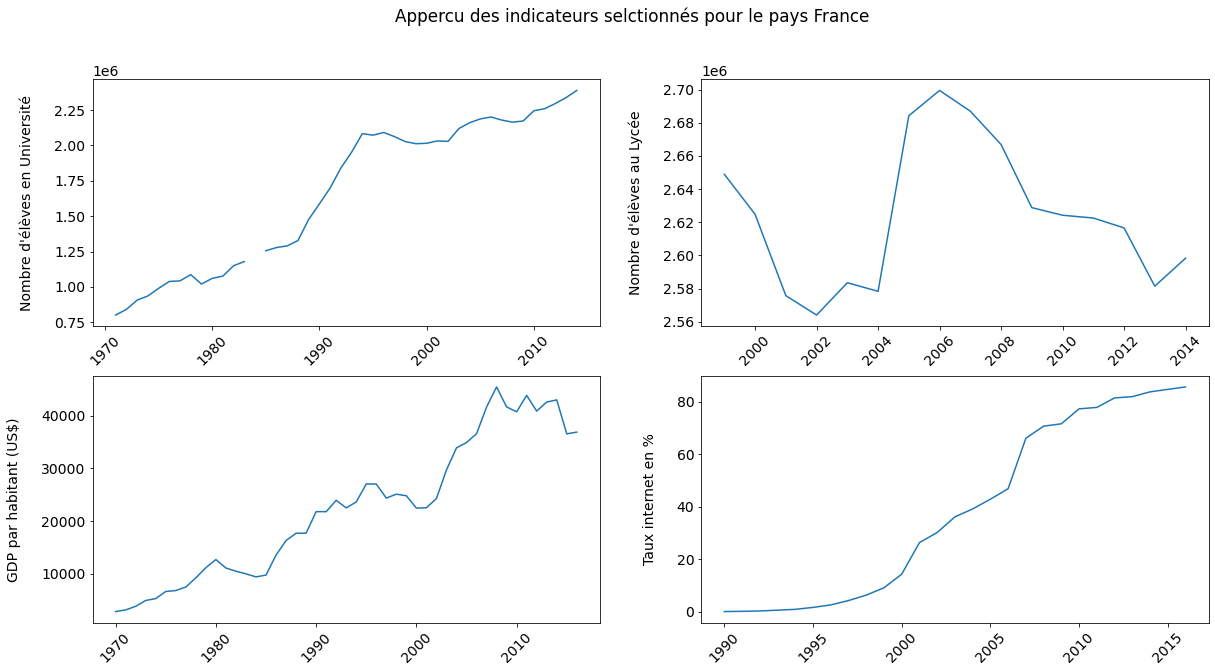

In [272]:
tracerindicateurspays('France')

# Historique pays choisis

In [273]:
payschoisis

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Czech Republic',
       'Denmark', 'Finland', 'France', 'Germany', 'Greece',
       'Hong Kong SAR, China', 'Israel', 'Italy', 'Japan', 'Korea, Rep.',
       'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Saudi Arabia',
       'Slovak Republic', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom', 'United States'], dtype=object)

In [274]:
listepaysfinale

Indicator Code       IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3
Country Name                                                                
Australia                   88.2387        49927.8  1.45352e+06  1.10416e+06
Austria                     84.3233        44676.3       425972       363188
Belgium                     86.5165        41236.3       504745       776413
Canada                        89.84        42157.9  1.21216e+06  1.53139e+06
Czech Republic              76.4812        18491.9       395529       414371
Denmark                     96.9678        53549.7       313756       311359
Finland                     87.7036        43402.9       302478       357550
France                      85.6222          36855  2.38888e+06  2.59836e+06
Germany                     89.6471        42069.6  2.97778e+06  2.57995e+06
Greece                      69.0879        17930.2       677429       371024
Hong Kong SAR, China        87.3003        43681.4       298643       225437
Israel                      79.7788        37175.7       374048       369316
Italy                       61.3243        30674.8  1.82648e+06  2.78044e+06
Japan                            92        38900.6  3.86246e+06  3.68292e+06
Korea, Rep.                 92.7165        27538.8   3.2681e+06  1.90386e+06
Netherlands                  90.411        45669.8       842601       746415
New Zealand                 88.4702        39416.4       270074       249314
Norway                      97.2982        70911.8       268231       249882
Portugal                    70.4236        19839.6       337507       385210
Saudi Arabia                73.7509        20028.6  1.52777e+06  1.67861e+06
Slovak Republic             80.4759        16535.9       197854       207550
Spain                       80.5613        26639.7  1.96392e+06  1.66258e+06
Sweden                      91.5068        51949.3       428557       502035
Switzerland                 89.4056        79890.5       294450       350927
United Kingdom              94.7758        40341.4  2.35293e+06  4.19508e+06
United States               76.1767        57638.2  1.95317e+07  1.17363e+07

In [275]:
indicateurschoisis

array(['IT.NET.USER.P2', 'NY.GDP.PCAP.CD', 'SE.TER.ENRL', 'UIS.E.3'],
      dtype=object)

In [276]:
#partir de datapaysprésent > filtre sur pays et indicateurs
#filtre en fonction des années à étudier -> faire passer dans masque année
#recupérer min/max et quelle année
#récupéréer moyenne sur les années

def historique():
    
    historique = datapayspresent[(datapayspresent['Country Name'].isin(payschoisis)) & (datapayspresent['Indicator Code'].isin(indicateurschoisis))].copy()
    historiqueannées = historique.drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis = 1)
    lignes = np.arange(historique.shape[0])
    colonnes = historiqueannées.columns
    
    minimum = []
    annéemin =[]
    maximum = []
    annéemax = []
    moyenne = []
    
    for i in lignes:
        
        mini = historiqueannées.iloc[i].min()
        minimum.append(mini)
        maxi = historiqueannées.iloc[i].max()
        maximum.append(maxi)
        moyi = historiqueannées.iloc[i].mean()
        moyenne.append(moyi)
        
        for j in colonnes:
            if historiqueannées.iloc[i][j] ==mini:
                annéemin.append(j)
            elif historiqueannées.iloc[i][j] ==maxi:
                annéemax.append(j)
    
    historique = historique[["Country Name","Country Code", "Indicator Name", "Indicator Code"]]
    historique["Minimum"]=minimum
    historique["Année min"]=annéemin
    historique["Maximum"]=maximum
    historique["Année max"]=annéemax
    historique["Moyenne"]=moyenne
    
    return historique
                
    

In [277]:
historique()

Country Name Country Code  \
129479       Australia          AUS   
129489       Australia          AUS   
129520       Australia          AUS   
129650       Australia          AUS   
133144         Austria          AUT   
...                ...          ...   
844325  United Kingdom          GBR   
847819   United States          USA   
847829   United States          USA   
847860   United States          USA   
847990   United States          USA   

                                           Indicator Name  Indicator Code  \
129479  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
129489  Enrolment in upper secondary education, both s...         UIS.E.3   
129520                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
129650                    Internet users (per 100 people)  IT.NET.USER.P2   
133144  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
...                                                   ...             ...   
844325                    Internet users (per 100 people)  IT.NET.USER.P2   
847819  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
847829  Enrolment in upper secondary education, both s...         UIS.E.3   
847860                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
847990                    Internet users (per 100 people)  IT.NET.USER.P2   

             Minimum Année min       Maximum Année max       Moyenne  
129479  1.796640e+05      1970  1.453521e+06      2014  6.986310e+05  
129489  9.046490e+05      2006  1.321502e+06      2000  1.110435e+06  
129520  3.302530e+03      1970  6.779230e+04      2013  2.390510e+04  
129650  5.850947e-01      1990  8.823866e+01      2016  4.667562e+01  
133144  5.977800e+04      1971  4.259717e+05      2015  2.135846e+05  
...              ...       ...           ...       ...           ...  
844325  8.735532e-02      1990  9.477580e+01      2016  4.813368e+01  
847819  8.498117e+06      1971  2.101613e+07      2011  1.429093e+07  
847829  1.021986e+07      1999  1.183802e+07      2008  1.127465e+07  
847860  5.246884e+03      1970  5.763816e+04      2016  2.850338e+04  
847990  7.847285e-01      1990  7.617674e+01      2016  4.702118e+01  

[104 rows x 9 columns]

In [278]:
#afficher les données sur années pour pays choisis/indicateurs choisis

In [279]:
historiqueavecannées = datapayspresent[(datapayspresent['Country Name'].isin(payschoisis)) & (datapayspresent['Indicator Code'].isin(indicateurschoisis))].copy()

In [280]:
historiqueavecannées.head()

Country Name Country Code  \
129479    Australia          AUS   
129489    Australia          AUS   
129520    Australia          AUS   
129650    Australia          AUS   
133144      Austria          AUT   

                                           Indicator Name  Indicator Code  \
129479  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
129489  Enrolment in upper secondary education, both s...         UIS.E.3   
129520                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
129650                    Internet users (per 100 people)  IT.NET.USER.P2   
133144  Enrolment in tertiary education, all programme...     SE.TER.ENRL   

                 1970           1971           1972           1973  \
129479  179664.000000  193532.000000  208149.000000  223855.000000   
129489            NaN            NaN            NaN            NaN   
129520    3302.529573    3492.549371    3946.535985    4766.979888   
129650            NaN            NaN            NaN            NaN   
133144            NaN   59778.000000   66401.000000   73467.000000   

                 1974           1975  ...          2009          2010  \
129479  252972.000000  274738.000000  ...  1.199845e+06  1.276488e+06   
129489            NaN            NaN  ...  9.623800e+05  9.909510e+05   
129520    6478.642513    6998.239869  ...  4.274300e+04  5.187408e+04   
129650            NaN            NaN  ...  7.425000e+01  7.600000e+01   
133144   78787.000000   84101.000000  ...  3.081500e+05  3.501870e+05   

                2011          2012          2013          2014           2015  \
129479  1.324257e+06  1.364203e+06  1.390478e+06  1.453521e+06            NaN   
129489  1.040865e+06  1.088366e+06  1.079568e+06  1.104162e+06            NaN   
129520  6.224510e+04  6.767763e+04  6.779230e+04  6.221461e+04   56554.038761   
129650  7.948770e+01  7.900000e+01  8.345350e+01  8.400000e+01      84.560519   
133144  3.617970e+05  3.764980e+05  4.227782e+05  4.212248e+05  425971.687500   

                2016  2017  2020  
129479           NaN   NaN   NaN  
129489           NaN   NaN   NaN  
129520  49927.819509   NaN   NaN  
129650     88.238658   NaN   NaN  
133144           NaN   NaN   NaN  

[5 rows x 53 columns]

In [281]:
historiqueavecannées.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 129479 to 847990
Data columns (total 53 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    104 non-null    object 
 1   Country Code    104 non-null    object 
 2   Indicator Name  104 non-null    object 
 3   Indicator Code  104 non-null    object 
 4   1970            24 non-null     float64
 5   1971            46 non-null     float64
 6   1972            46 non-null     float64
 7   1973            45 non-null     float64
 8   1974            44 non-null     float64
 9   1975            46 non-null     float64
 10  1976            45 non-null     float64
 11  1977            45 non-null     float64
 12  1978            45 non-null     float64
 13  1979            46 non-null     float64
 14  1980            47 non-null     float64
 15  1981            46 non-null     float64
 16  1982            46 non-null     float64
 17  1983            47 non-null

In [282]:
historiqueavecannéesclean = masque_année(historiqueavecannées,1970,1990)

In [283]:
historiqueavecannéesclean = historiqueavecannéesclean.drop(['2017','2020'], axis = 1)

In [284]:
historiqueavecannéesclean

Country Name Country Code  \
129479       Australia          AUS   
129489       Australia          AUS   
129520       Australia          AUS   
129650       Australia          AUS   
133144         Austria          AUT   
...                ...          ...   
844325  United Kingdom          GBR   
847819   United States          USA   
847829   United States          USA   
847860   United States          USA   
847990   United States          USA   

                                           Indicator Name  Indicator Code  \
129479  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
129489  Enrolment in upper secondary education, both s...         UIS.E.3   
129520                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
129650                    Internet users (per 100 people)  IT.NET.USER.P2   
133144  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
...                                                   ...             ...   
844325                    Internet users (per 100 people)  IT.NET.USER.P2   
847819  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
847829  Enrolment in upper secondary education, both s...         UIS.E.3   
847860                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
847990                    Internet users (per 100 people)  IT.NET.USER.P2   

                1991          1992          1993          1994          1995  \
129479  5.345300e+05  5.593650e+05  9.226990e+05  9.329690e+05  9.649980e+05   
129489           NaN           NaN           NaN           NaN           NaN   
129520  1.886534e+04  1.861632e+04  1.768115e+04  1.810232e+04  2.038467e+04   
129650  1.097204e+00  1.768765e+00  1.974611e+00  2.232101e+00  2.759655e+00   
133144  2.057670e+05  2.165290e+05  2.213890e+05  2.274440e+05  2.339890e+05   
...              ...           ...           ...           ...           ...   
844325  1.742309e-01  2.606152e-01  5.197620e-01  1.036609e+00  1.895168e+00   
847819  1.371015e+07  1.436096e+07  1.448630e+07  1.430535e+07  1.427880e+07   
847829           NaN           NaN           NaN           NaN           NaN   
847860  2.440516e+04  2.549295e+04  2.646485e+04  2.777664e+04  2.878218e+04   
847990  1.163194e+00  1.724203e+00  2.271673e+00  4.862781e+00  9.237088e+00   

                1996  ...          2007          2008          2009  \
129479  1.002476e+06  ...  1.083715e+06  1.117804e+06  1.199845e+06   
129489           NaN  ...  9.120540e+05  9.426090e+05  9.623800e+05   
129520  2.194416e+04  ...  4.099198e+04  4.966469e+04  4.274300e+04   
129650  3.275250e+00  ...  6.945000e+01  7.167000e+01  7.425000e+01   
133144  2.389810e+05  ...  2.609750e+05  2.847910e+05  3.081500e+05   
...              ...  ...           ...           ...           ...   
844325  4.123650e+00  ...  7.509000e+01  7.839000e+01  8.356000e+01   
847819  1.426178e+07  ...  1.775887e+07  1.824812e+07  1.910281e+07   
847829           NaN  ...  1.172960e+07  1.183802e+07  1.179106e+07   
847860  3.006823e+04  ...  4.806154e+04  4.840143e+04  4.700156e+04   
847990  1.641935e+01  ...  7.500000e+01  7.400000e+01  7.100000e+01   

                2010          2011          2012          2013          2014  \
129479  1.276488e+06  1.324257e+06  1.364203e+06  1.390478e+06  1.453521e+06   
129489  9.909510e+05  1.040865e+06  1.088366e+06  1.079568e+06  1.104162e+06   
129520  5.187408e+04  6.224510e+04  6.767763e+04  6.779230e+04  6.221461e+04   
129650  7.600000e+01  7.948770e+01  7.900000e+01  8.345350e+01  8.400000e+01   
133144  3.501870e+05  3.617970e+05  3.764980e+05  4.227782e+05  4.212248e+05   
...              ...           ...           ...           ...           ...   
844325  8.500000e+01  8.538000e+01  8.748000e+01  8.984410e+01  9.161000e+01   
847819  2.042771e+07  2.101613e+07  2.099411e+07  1.997262e+07  1.970022e+07   
847829  1.170128e+07  1.180938e+07  1.174826e+07  1.164642e+07  1.173632e+07   
84

# comparaison pays selectionnés et autres

In [285]:
payschoisis

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Czech Republic',
       'Denmark', 'Finland', 'France', 'Germany', 'Greece',
       'Hong Kong SAR, China', 'Israel', 'Italy', 'Japan', 'Korea, Rep.',
       'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Saudi Arabia',
       'Slovak Republic', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom', 'United States'], dtype=object)

In [286]:
datapayspresent.head()

Country Name Country Code  \
91625  Afghanistan          AFG   
91626  Afghanistan          AFG   
91627  Afghanistan          AFG   
91628  Afghanistan          AFG   
91629  Afghanistan          AFG   

                                          Indicator Name  Indicator Code  \
91625  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   
91626  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   
91627  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   
91628  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.M   
91629  Adjusted net enrolment rate, primary, both sex...     SE.PRM.TENR   

       1970  1971  1972  1973      1974  1975  ...  2009  2010  2011  2012  \
91625   NaN   NaN   NaN   NaN   7.05911   NaN  ...   NaN   NaN   NaN   NaN   
91626   NaN   NaN   NaN   NaN   2.53138   NaN  ...   NaN   NaN   NaN   NaN   
91627   NaN   NaN   NaN   NaN   0.22154   NaN  ...   NaN   NaN   NaN   NaN   
91628   NaN   NaN   NaN   NaN  11.42652   NaN  ...   NaN   NaN   NaN   NaN   
91629   NaN   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   NaN   NaN   

            2013       2014  2015  2016  2017  2020  
91625  47.436790  50.627232   NaN   NaN   NaN   NaN  
91626  34.073261  37.641541   NaN   NaN   NaN   NaN  
91627   0.567060   0.598370   NaN   NaN   NaN   NaN  
91628  60.087059  62.906952   NaN   NaN   NaN   NaN  
91629        NaN        NaN   NaN   NaN   NaN   NaN  

[5 rows x 53 columns]

In [287]:
#utilisation du ~ pour inverser le booleen de la contion, isin>>>notin
paysnonchoisis = (datapayspresent[~datapayspresent['Country Name'].isin(payschoisis)]).copy()

In [288]:
paysnonchoisis

Country Name Country Code  \
91625   Afghanistan          AFG   
91626   Afghanistan          AFG   
91627   Afghanistan          AFG   
91628   Afghanistan          AFG   
91629   Afghanistan          AFG   
...             ...          ...   
886925     Zimbabwe          ZWE   
886926     Zimbabwe          ZWE   
886927     Zimbabwe          ZWE   
886928     Zimbabwe          ZWE   
886929     Zimbabwe          ZWE   

                                           Indicator Name  \
91625   Adjusted net enrolment rate, lower secondary, ...   
91626   Adjusted net enrolment rate, lower secondary, ...   
91627   Adjusted net enrolment rate, lower secondary, ...   
91628   Adjusted net enrolment rate, lower secondary, ...   
91629   Adjusted net enrolment rate, primary, both sex...   
...                                                   ...   
886925  Youth illiterate population, 15-24 years, male...   
886926  Youth literacy rate, population 15-24 years, b...   
886927  Youth literacy rate, population 15-24 years, f...   
886928  Youth literacy rate, population 15-24 years, g...   
886929  Youth literacy rate, population 15-24 years, m...   

              Indicator Code  1970  1971  1972  1973      1974  1975  ...  \
91625             UIS.NERA.2   NaN   NaN   NaN   NaN   7.05911   NaN  ...   
91626           UIS.NERA.2.F   NaN   NaN   NaN   NaN   2.53138   NaN  ...   
91627         UIS.NERA.2.GPI   NaN   NaN   NaN   NaN   0.22154   NaN  ...   
91628           UIS.NERA.2.M   NaN   NaN   NaN   NaN  11.42652   NaN  ...   
91629            SE.PRM.TENR   NaN   NaN   NaN   NaN       NaN   NaN  ...   
...                      ...   ...   ...   ...   ...       ...   ...  ...   
886925      UIS.LP.AG15T24.M   NaN   NaN   NaN   NaN       NaN   NaN  ...   
886926     SE.ADT.1524.LT.ZS   NaN   NaN   NaN   NaN       NaN   NaN  ...   
886927  SE.ADT.1524.LT.FE.ZS   NaN   NaN   NaN   NaN       NaN   NaN  ...   
886928  SE.ADT.1524.LT.FM.ZS   NaN   NaN   NaN   NaN       NaN   NaN  ...   
886929  SE.ADT.1524.LT.MA.ZS   NaN   NaN   NaN   NaN       NaN   NaN  ...   

        2009  2010          2011  2012       2013           2014  2015  2016  \
91625    NaN   NaN           NaN   NaN  47.436790      50.627232   NaN   NaN   
91626    NaN   NaN           NaN   NaN  34.073261      37.641541   NaN   NaN   
91627    NaN   NaN           NaN   NaN   0.567060       0.598370   NaN   NaN   
91628    NaN   NaN           NaN   NaN  60.087059      62.906952   NaN   NaN   
91629    NaN   NaN           NaN   NaN        NaN            NaN   NaN   NaN   
...      ...   ...           ...   ...        ...            ...   ...   ...   
886925   NaN   NaN  166679.00000   NaN        NaN  199464.000000   NaN   NaN   
886926   NaN   NaN      90.93070   NaN        NaN      90.428120   NaN   NaN   
886927   NaN   NaN      92.12456   NaN        NaN      93.188350   NaN   NaN   
886928   NaN   NaN       1.02828   NaN        NaN       1.063890   NaN   NaN   
886929   NaN   NaN      89.59058   NaN        NaN      87.591860   NaN   NaN   

        2017  2020  
91625    NaN   NaN  
91626    NaN   NaN  
91627    NaN   NaN  
91628    NaN   NaN  
91629    NaN   NaN  
...      ...   ...  
886925   NaN   NaN  
886926   NaN   NaN  
886927   NaN   NaN  
886928   NaN   NaN  
886929   NaN   NaN  

[700015 rows x 53 columns]

In [289]:
#vérification du nombre de pays
len(datapayspresent['Country Name'].unique())

217

In [290]:
len(paysnonchoisis['Country Name'].unique())

191

In [291]:
len(listepaysfinale.index)

26

In [292]:
#selection des 4 indicateurs suivis
paysnonchoisis = paysnonchoisis[paysnonchoisis['Indicator Code'].isin(indicateurschoisis)]

In [293]:
paysnonchoisis.head()

Country Name Country Code  \
92829  Afghanistan          AFG   
92839  Afghanistan          AFG   
92870  Afghanistan          AFG   
93000  Afghanistan          AFG   
96494      Albania          ALB   

                                          Indicator Name  Indicator Code  \
92829  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
92839  Enrolment in upper secondary education, both s...         UIS.E.3   
92870                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
93000                    Internet users (per 100 people)  IT.NET.USER.P2   
96494  Enrolment in tertiary education, all programme...     SE.TER.ENRL   

              1970          1971          1972          1973          1974  \
92829  7732.000000   9409.000000   9817.000000  11487.000000  10956.000000   
92839          NaN           NaN           NaN           NaN           NaN   
92870   157.187422    160.372836    136.117014    144.110319    174.942038   
93000          NaN           NaN           NaN           NaN           NaN   
96494          NaN  25469.000000  28668.000000           NaN           NaN   

               1975  ...           2009           2010           2011  \
92829  12256.000000  ...   95185.000000            NaN   97504.000000   
92839           NaN  ...  443002.000000  567344.000000  743405.000000   
92870    187.975604  ...     445.893298     553.300289     603.537023   
93000           NaN  ...       3.550000       4.000000       5.000000   
96494           NaN  ...   93139.000000  122326.000000  134877.000000   

                2012           2013           2014           2015        2016  \
92829            NaN            NaN  262874.000000            NaN         NaN   
92839  881415.000000  969267.000000  968769.000000            NaN         NaN   
92870     669.009051     631.744971     612.069651     569.577923  561.778746   
93000       5.454545       5.900000       7.000000       8.260000   10.595726   
96494  160839.000000  173029.000000  173819.000000  160527.000000         NaN   

       2017  2020  
92829   NaN   NaN  
92839   NaN   NaN  
92870   NaN   NaN  
93000   NaN   NaN  
96494   NaN   NaN  

[5 rows x 53 columns]

In [294]:
paysnonchoisisannées = paysnonchoisis.drop(["Country Name", "Country Code","Indicator Name", "Indicator Code"], axis = 1).copy()

In [295]:
paysnonchoisis['Nombre Données'] = paysnonchoisisannées.notna().sum(axis = 1)
#alerte copy , meme en mettant des .copy ne disparait pas ??

<ipython-input-295-1a14e70731dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paysnonchoisis['Nombre Données'] = paysnonchoisisannées.notna().sum(axis = 1)


In [296]:
paysnonchoisis.head()

Country Name Country Code  \
92829  Afghanistan          AFG   
92839  Afghanistan          AFG   
92870  Afghanistan          AFG   
93000  Afghanistan          AFG   
96494      Albania          ALB   

                                          Indicator Name  Indicator Code  \
92829  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
92839  Enrolment in upper secondary education, both s...         UIS.E.3   
92870                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
93000                    Internet users (per 100 people)  IT.NET.USER.P2   
96494  Enrolment in tertiary education, all programme...     SE.TER.ENRL   

              1970          1971          1972          1973          1974  \
92829  7732.000000   9409.000000   9817.000000  11487.000000  10956.000000   
92839          NaN           NaN           NaN           NaN           NaN   
92870   157.187422    160.372836    136.117014    144.110319    174.942038   
93000          NaN           NaN           NaN           NaN           NaN   
96494          NaN  25469.000000  28668.000000           NaN           NaN   

               1975  ...           2010           2011           2012  \
92829  12256.000000  ...            NaN   97504.000000            NaN   
92839           NaN  ...  567344.000000  743405.000000  881415.000000   
92870    187.975604  ...     553.300289     603.537023     669.009051   
93000           NaN  ...       4.000000       5.000000       5.454545   
96494           NaN  ...  122326.000000  134877.000000  160839.000000   

                2013           2014           2015        2016  2017  2020  \
92829            NaN  262874.000000            NaN         NaN   NaN   NaN   
92839  969267.000000  968769.000000            NaN         NaN   NaN   NaN   
92870     631.744971     612.069651     569.577923  561.778746   NaN   NaN   
93000       5.900000       7.000000       8.260000   10.595726   NaN   NaN   
96494  173029.000000  173819.000000  160527.000000         NaN   NaN   NaN   

       Nombre Données  
92829              19  
92839              13  
92870              28  
93000              17  
96494              37  

[5 rows x 54 columns]

In [297]:
paysnonchoisis = paysnonchoisis[paysnonchoisis['Nombre Données']>0]

In [298]:
derniereannée(paysnonchoisis, paysnonchoisisannées)

In [299]:
paysnonchoisis.head()

Country Name Country Code  \
92829  Afghanistan          AFG   
92839  Afghanistan          AFG   
92870  Afghanistan          AFG   
93000  Afghanistan          AFG   
96494      Albania          ALB   

                                          Indicator Name  Indicator Code  \
92829  Enrolment in tertiary education, all programme...     SE.TER.ENRL   
92839  Enrolment in upper secondary education, both s...         UIS.E.3   
92870                       GDP per capita (current US$)  NY.GDP.PCAP.CD   
93000                    Internet users (per 100 people)  IT.NET.USER.P2   
96494  Enrolment in tertiary education, all programme...     SE.TER.ENRL   

              1970          1971          1972          1973          1974  \
92829  7732.000000   9409.000000   9817.000000  11487.000000  10956.000000   
92839          NaN           NaN           NaN           NaN           NaN   
92870   157.187422    160.372836    136.117014    144.110319    174.942038   
93000          NaN           NaN           NaN           NaN           NaN   
96494          NaN  25469.000000  28668.000000           NaN           NaN   

               1975  ...           2011           2012           2013  \
92829  12256.000000  ...   97504.000000            NaN            NaN   
92839           NaN  ...  743405.000000  881415.000000  969267.000000   
92870    187.975604  ...     603.537023     669.009051     631.744971   
93000           NaN  ...       5.000000       5.454545       5.900000   
96494           NaN  ...  134877.000000  160839.000000  173029.000000   

                2014           2015        2016  2017  2020  Nombre Données  \
92829  262874.000000            NaN         NaN   NaN   NaN              19   
92839  968769.000000            NaN         NaN   NaN   NaN              13   
92870     612.069651     569.577923  561.778746   NaN   NaN              28   
93000       7.000000       8.260000   10.595726   NaN   NaN              17   
96494  173819.000000  160527.000000         NaN   NaN   NaN              37   

       Année Last Data  
92829             2014  
92839             2014  
92870             2016  
93000             2016  
96494             2015  

[5 rows x 55 columns]

In [300]:
paysnonchoisiscomplété = paysnonchoisis.fillna(method='ffill', axis = 1)

In [301]:
paysnonchoisiscomplété = paysnonchoisiscomplété[['Country Name', "Country Code", "Indicator Code", "Indicator Name", "2020", "Année Last Data"]]

In [302]:
paysnonchoisiscomplété.head()

Country Name Country Code  Indicator Code  \
92829  Afghanistan          AFG     SE.TER.ENRL   
92839  Afghanistan          AFG         UIS.E.3   
92870  Afghanistan          AFG  NY.GDP.PCAP.CD   
93000  Afghanistan          AFG  IT.NET.USER.P2   
96494      Albania          ALB     SE.TER.ENRL   

                                          Indicator Name     2020  \
92829  Enrolment in tertiary education, all programme...   262874   
92839  Enrolment in upper secondary education, both s...   968769   
92870                       GDP per capita (current US$)  561.779   
93000                    Internet users (per 100 people)  10.5957   
96494  Enrolment in tertiary education, all programme...   160527   

      Année Last Data  
92829            2014  
92839            2014  
92870            2016  
93000            2016  
96494            2015

In [303]:
paysnonchoisiscomplété = paysnonchoisiscomplété.rename(columns={"2020":"Last Data"})

In [304]:
paysnonchoisiscomplété.head()

Country Name Country Code  Indicator Code  \
92829  Afghanistan          AFG     SE.TER.ENRL   
92839  Afghanistan          AFG         UIS.E.3   
92870  Afghanistan          AFG  NY.GDP.PCAP.CD   
93000  Afghanistan          AFG  IT.NET.USER.P2   
96494      Albania          ALB     SE.TER.ENRL   

                                          Indicator Name Last Data  \
92829  Enrolment in tertiary education, all programme...    262874   
92839  Enrolment in upper secondary education, both s...    968769   
92870                       GDP per capita (current US$)   561.779   
93000                    Internet users (per 100 people)   10.5957   
96494  Enrolment in tertiary education, all programme...    160527   

      Année Last Data  
92829            2014  
92839            2014  
92870            2016  
93000            2016  
96494            2015

In [305]:
listepaysnonchoisis = paysnonchoisiscomplété.pivot(index = "Country Name", columns = 'Indicator Code', values = "Last Data")

In [306]:
listepaysnonchoisis.head()

Indicator Code IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3
Country Name                                                          
Afghanistan           10.5957        561.779       262874       968769
Albania               66.3634        4124.98       160527       151937
Algeria               42.9455        3916.88  1.28947e+06  1.33258e+06
American Samoa              0        11834.7         1607          NaN
Andorra               97.9306        36988.6          501         1288

In [307]:
listepaysfinale.head()

Indicator Code IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3
Country Name                                                          
Australia             88.2387        49927.8  1.45352e+06  1.10416e+06
Austria               84.3233        44676.3       425972       363188
Belgium               86.5165        41236.3       504745       776413
Canada                  89.84        42157.9  1.21216e+06  1.53139e+06
Czech Republic        76.4812        18491.9       395529       414371

In [308]:
listepaysfinale["Pays Selectionnés"]='oui'
listepaysnonchoisis['Pays Selectionnés']='non'

<ipython-input-308-772956ecb7c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listepaysfinale["Pays Selectionnés"]='oui'


In [309]:
donnéesfinales = pd.concat([listepaysfinale,listepaysnonchoisis])

In [310]:
donnéesfinales.head()

Indicator Code IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3  \
Country Name                                                             
Australia             88.2387        49927.8  1.45352e+06  1.10416e+06   
Austria               84.3233        44676.3       425972       363188   
Belgium               86.5165        41236.3       504745       776413   
Canada                  89.84        42157.9  1.21216e+06  1.53139e+06   
Czech Republic        76.4812        18491.9       395529       414371   

Indicator Code Pays Selectionnés  
Country Name                      
Australia                    oui  
Austria                      oui  
Belgium                      oui  
Canada                       oui  
Czech Republic               oui

In [311]:
series[series['Series Code'].isin(indicateurschoisis)]

Series Code                                              Topic  \
611   IT.NET.USER.P2                     Infrastructure: Communications   
1662  NY.GDP.PCAP.CD  Economic Policy & Debt: National accounts: US$...   
2332     SE.TER.ENRL                                           Tertiary   
2825         UIS.E.3                                          Secondary   

                                         Indicator Name Short definition  \
611                     Internet users (per 100 people)              NaN   
1662                       GDP per capita (current US$)              NaN   
2332  Enrolment in tertiary education, all programme...              NaN   
2825  Enrolment in upper secondary education, both s...              NaN   

                                        Long definition Periodicity  \
611   Internet users are individuals who have used t...      Annual   
1662  GDP per capita is gross domestic product divid...      Annual   
2332  The total number of students enrolled at publi...         NaN   
2825  Total number of students enrolled in public an...         NaN   

     Base Period Other notes Aggregation method  \
611          NaN         NaN   Weighted average   
1662         NaN         NaN   Weighted average   
2332         NaN         NaN                NaN   
2825         NaN         NaN                NaN   

                             Limitations and exceptions  \
611   Operators have traditionally been the main sou...   
1662                                                NaN   
2332                                                NaN   
2825                                                NaN   

                                       General comments  \
611   Please cite the International Telecommunicatio...   
1662                                                NaN   
2332                                                NaN   
2825                                                NaN   

                                                 Source  \
611   International Telecommunication Union, World T...   
1662  World Bank national accounts data, and OECD Na...   
2332                    UNESCO Institute for Statistics   
2825                    UNESCO Institute for Statistics   

     Statistical concept and methodology Development relevance  \
611                                  NaN                   NaN   
1662                                 NaN                   NaN   
2332                                 NaN                   NaN   
2825                                 NaN                   NaN   

     Related source links  
611                   NaN  
1662                  NaN  
2332                  NaN  
2825                  NaN

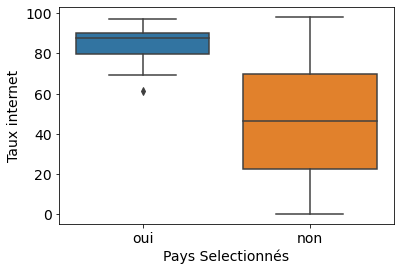

In [312]:
ax = sns.boxplot(data = donnéesfinales, x = 'Pays Selectionnés', y = 'IT.NET.USER.P2')
plt.ylabel("Taux internet");

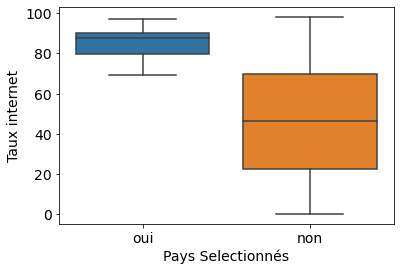

In [313]:
ax = sns.boxplot(data = donnéesfinales, x = 'Pays Selectionnés', y = 'IT.NET.USER.P2', showfliers = False)
plt.ylabel("Taux internet");

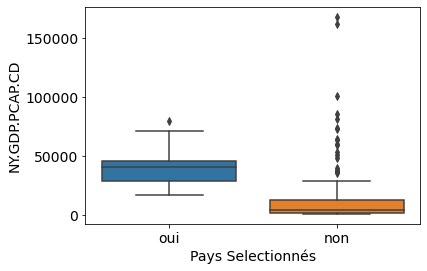

In [314]:
ax = sns.boxplot(data = donnéesfinales, x = 'Pays Selectionnés', y = 'NY.GDP.PCAP.CD')

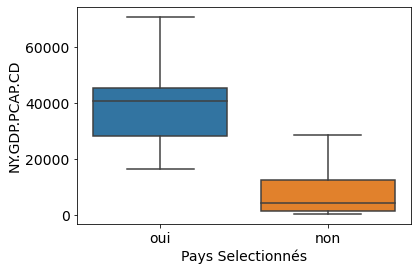

In [315]:
ax = sns.boxplot(data = donnéesfinales, x = 'Pays Selectionnés', y = 'NY.GDP.PCAP.CD', showfliers = False)

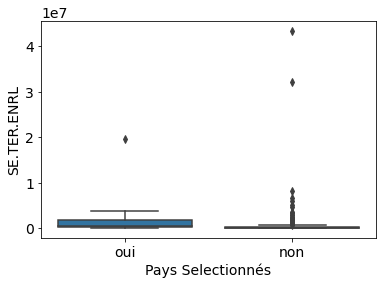

In [316]:
ax = sns.boxplot(data = donnéesfinales, x = 'Pays Selectionnés', y = 'SE.TER.ENRL')

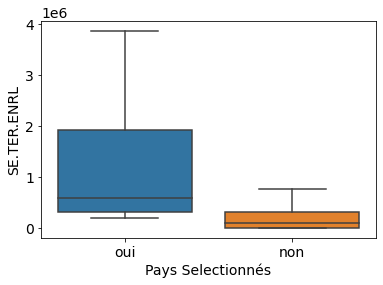

In [317]:
ax = sns.boxplot(data = donnéesfinales, x = 'Pays Selectionnés', y = 'SE.TER.ENRL', showfliers = False)

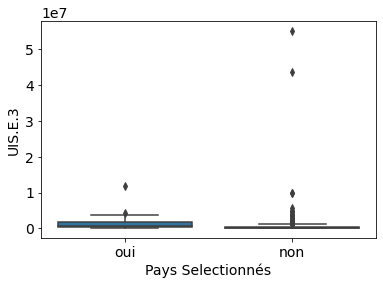

In [318]:
ax = sns.boxplot(data = donnéesfinales, x = 'Pays Selectionnés', y = 'UIS.E.3')

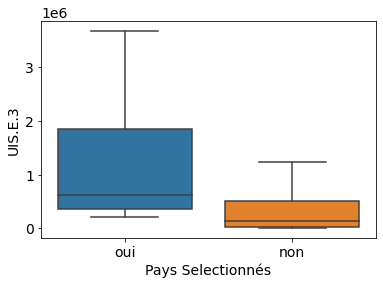

In [319]:
ax = sns.boxplot(data = donnéesfinales, x = 'Pays Selectionnés', y = 'UIS.E.3', showfliers = False)

In [320]:
def comparaisonboxplot(df,outliers = False):
    
    if type(outliers) != bool: #vérifier que outliers soit bool, emme si du coup on peut mettre n'importe quel truc qui renvoit un bool
        raise ValueError("outliers must be set to True or False")
    
    #dictionner pour label auto en fonction de l'indicateur étudié
    dicindic = {'IT.NET.USER.P2':'Taux internet en %',
                'UIS.E.3': "Nombre d'élèves au Lycée",
                "SE.TER.ENRL": "Nombre d'élèves en Université",
                "NY.GDP.PCAP.CD": "GDP par habitant (US$)"}
        
    fig = plt.figure(figsize =(12,10))
    fig.suptitle('Comparaison des Pays selectionnés ou non')
    plt.subplots_adjust(wspace=0.5, hspace=0.5) #modifier espacement des subplots
    j=1
    
    if outliers == False:
        for i in indicateurschoisis:
            fig.add_subplot(2,2,j)
            ax = sns.boxplot(data = df, x = 'Pays Selectionnés', y = i, showfliers = False)
            ax.set(ylabel=dicindic[i])
            ax.yaxis.labelpad = 20
            ax.xaxis.labelpad = 20
            j+=1
    else:
        for i in indicateurschoisis:
            fig.add_subplot(2,2,j)
            ax = sns.boxplot(data = df, x = 'Pays Selectionnés', y = i)
            ax.set(ylabel=dicindic[i])
            ax.yaxis.labelpad = 20
            ax.xaxis.labelpad = 20
            j+=1
            
#ajouetr moyen de legender axe y en fonction de l'indicateur label = f(indicateur)

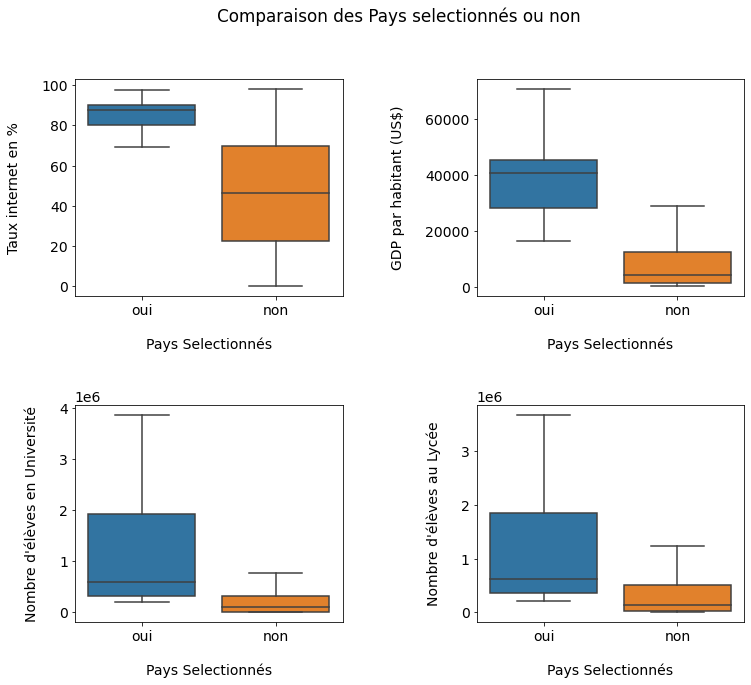

In [321]:
comparaisonboxplot(donnéesfinales)

In [322]:
#histogramme par indica

In [323]:
#boucle sur indicateur > historgramme
#abscisse = valeurs prises par indicateur ( découpé en tranches ?)
#ordonné = nombre de pays qui sont dans cette tranche

In [324]:
donnéesfinales

Indicator Code        IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3  \
Country Name                                                                    
Australia                    88.2387        49927.8  1.45352e+06  1.10416e+06   
Austria                      84.3233        44676.3       425972       363188   
Belgium                      86.5165        41236.3       504745       776413   
Canada                         89.84        42157.9  1.21216e+06  1.53139e+06   
Czech Republic               76.4812        18491.9       395529       414371   
...                              ...            ...          ...          ...   
Virgin Islands (U.S.)        59.6083        36350.8         2488          NaN   
West Bank and Gaza           61.1784         2943.4       221018       142063   
Yemen, Rep.                  24.5792        990.335       267498       701984   
Zambia                       25.5066        1269.57        56680          NaN   
Zimbabwe                       23.12        1029.08       135575       490522   

Indicator Code        Pays Selectionnés  
Country Name                             
Australia                           oui  
Austria                             oui  
Belgium                             oui  
Canada                              oui  
Czech Republic                      oui  
...                                 ...  
Virgin Islands (U.S.)               non  
West Bank and Gaza                  non  
Yemen, Rep.                         non  
Zambia                              non  
Zimbabwe                            non  

[216 rows x 5 columns]

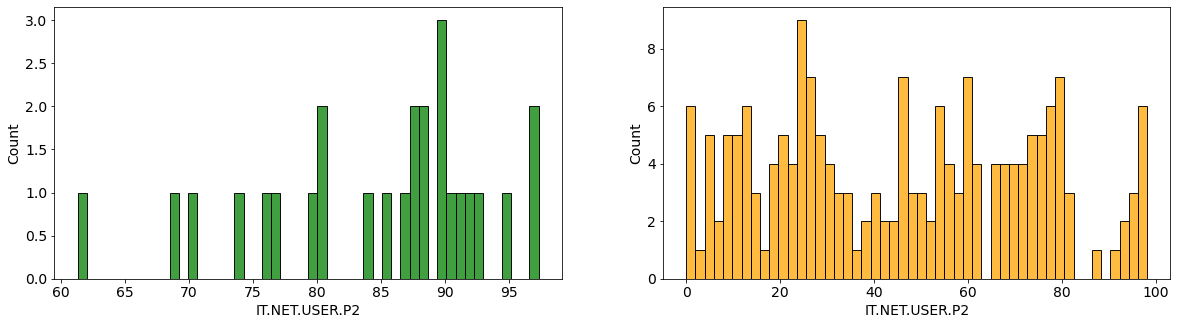

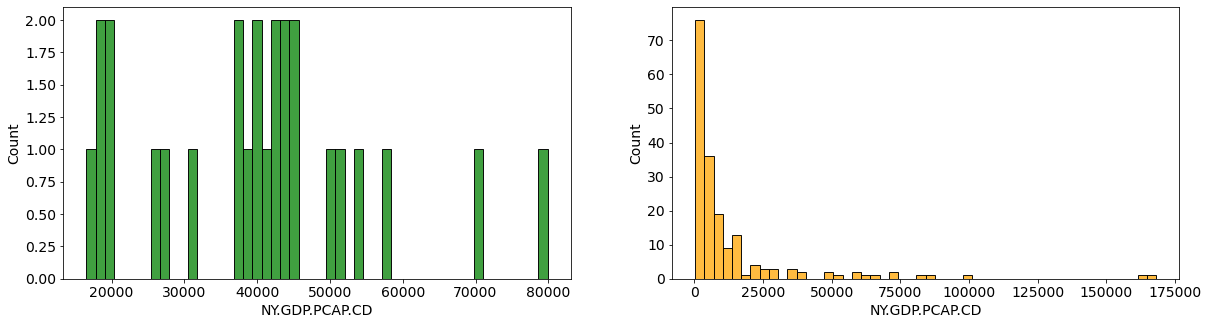

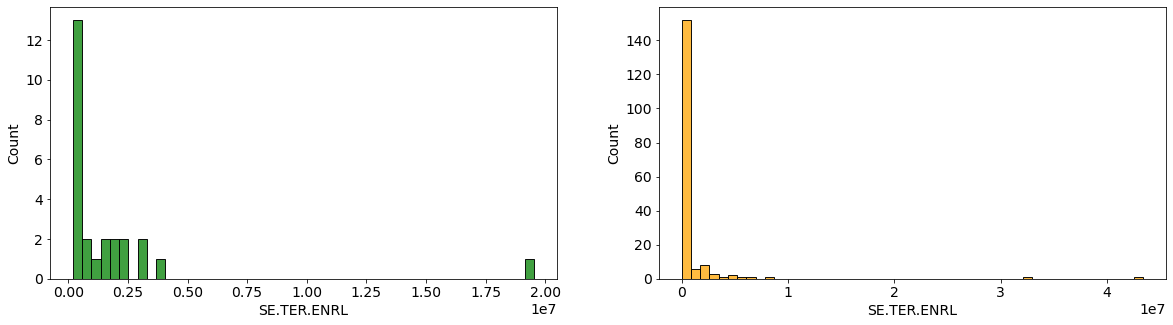

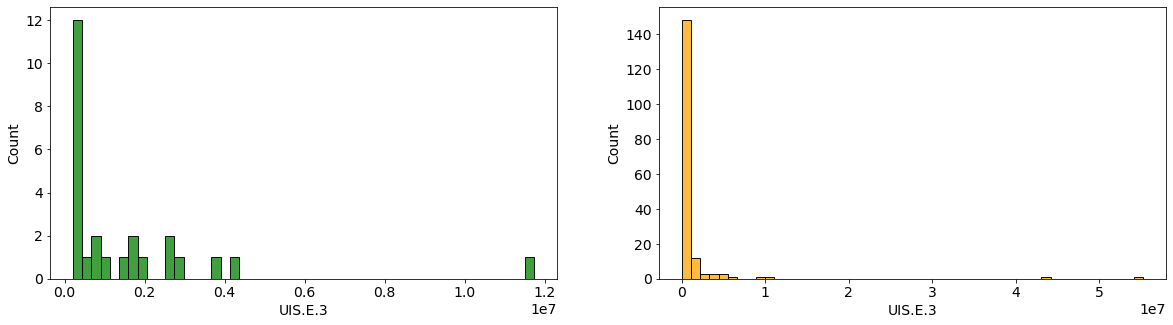

In [325]:
for indic in indicateurschoisis:
    fig = plt.figure(figsize = (20,5))
    fig.add_subplot(1,2,1)
    sns.histplot(donnéesfinales[donnéesfinales['Pays Selectionnés']=='oui'], x= indic, bins=50, color = 'green')
    fig.add_subplot(1,2,2)
    sns.histplot(donnéesfinales[donnéesfinales['Pays Selectionnés']=='non'], x= indic, bins=50, color = 'orange')

    #comparaison en face a face, mais pas meme echelles du coup bof bof

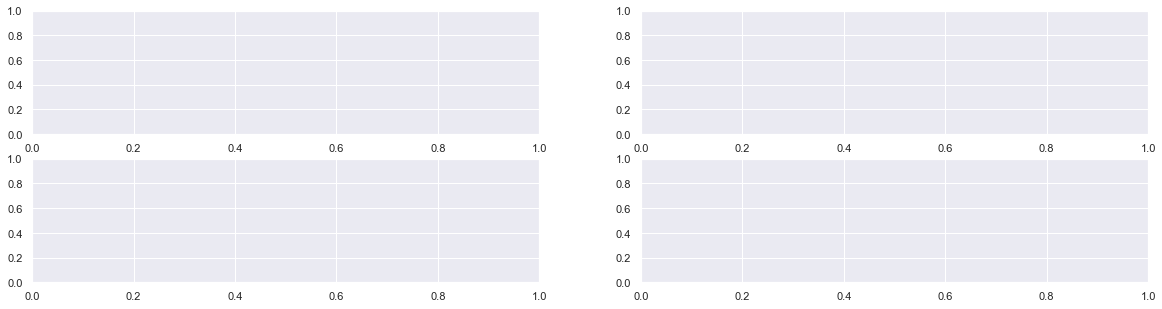

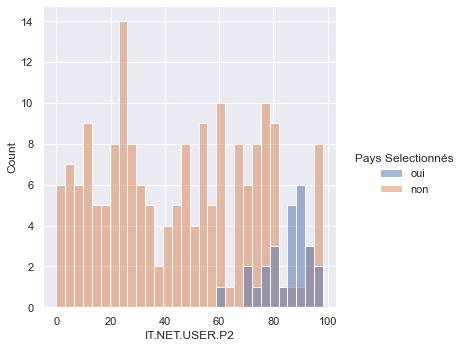

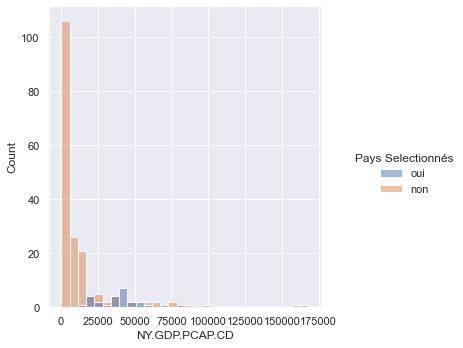

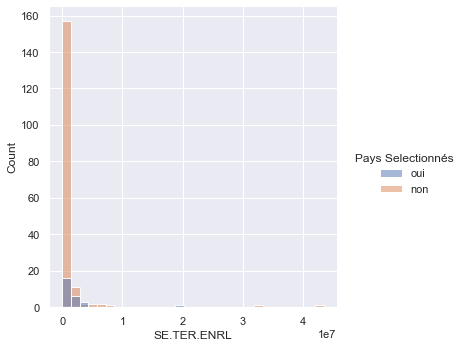

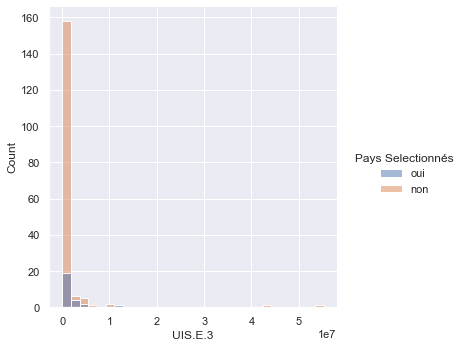

In [326]:
sns.set()
fig = plt.figure(figsize = (20,5))


for i, indic in enumerate(indicateurschoisis): #enumerate pour recup l'indice et la valeur, plus elegant que le coup du j
    fig.add_subplot(2,2,i+1)
    sns.displot(donnéesfinales, x= donnéesfinales[indic], bins = 30, hue = 'Pays Selectionnés')
    
#uytilisation figure pas au point pour displot ? (fonction avec dist qui va disparaitre)



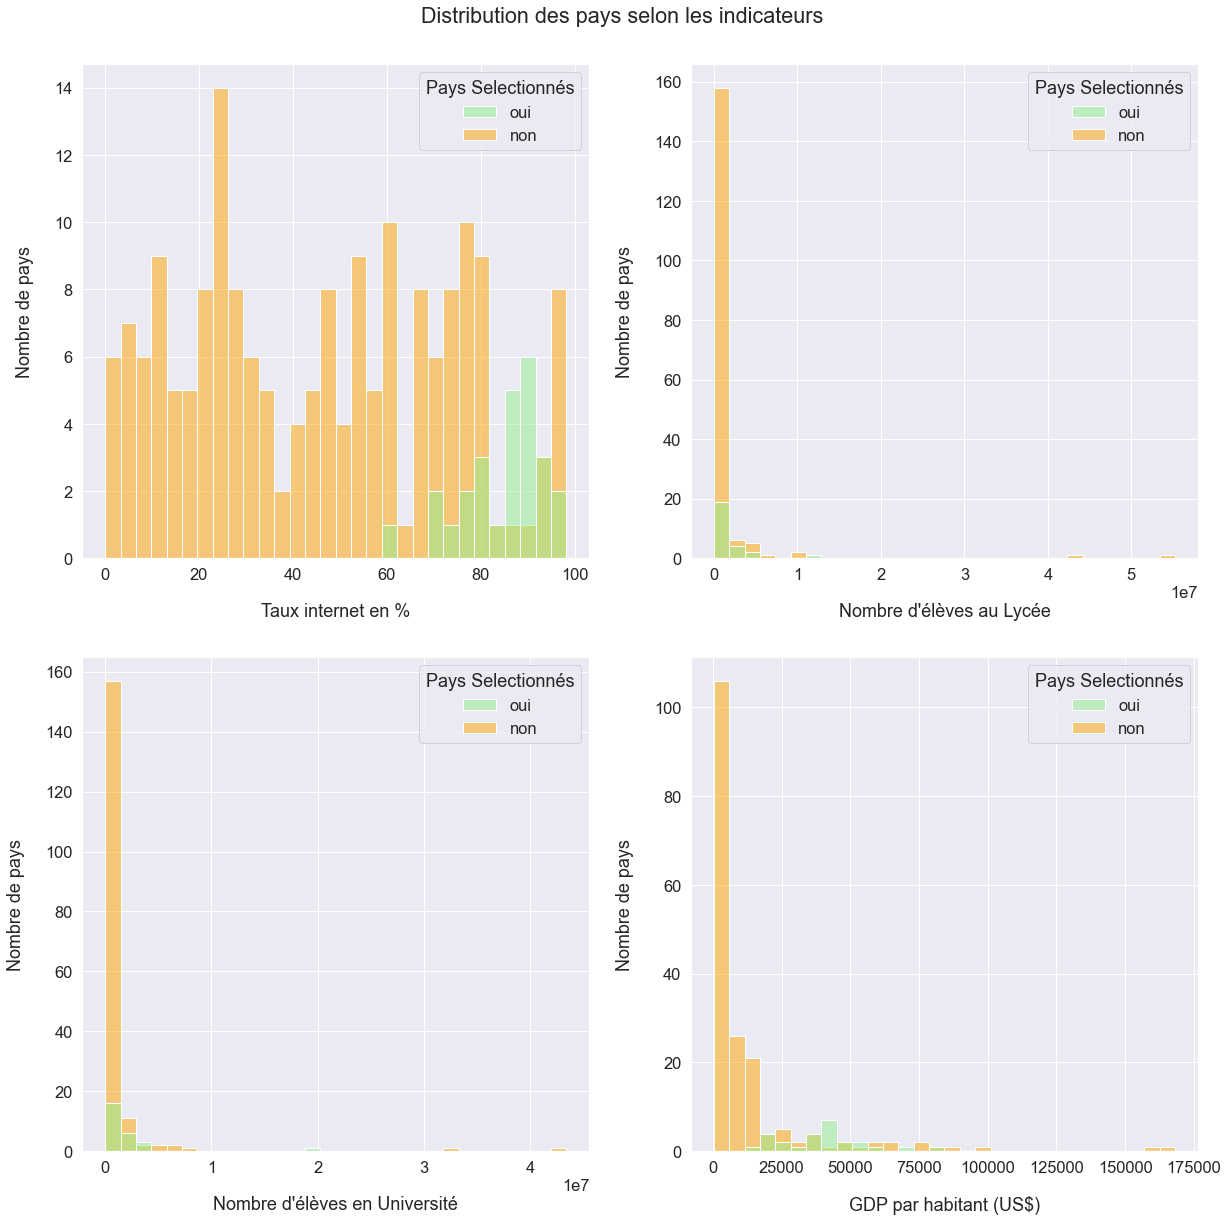

In [327]:
sns.set(font_scale = 1.5)
fig = plt.figure(figsize = (20,20))
fig.suptitle("Distribution des pays selon les indicateurs", y = 0.92)

dicindic = {'IT.NET.USER.P2':'Taux internet en %',
                'UIS.E.3': "Nombre d'élèves au Lycée",
                "SE.TER.ENRL": "Nombre d'élèves en Université",
                "NY.GDP.PCAP.CD": "GDP par habitant (US$)"}

for i,indic in enumerate(dicindic.keys()):

    fig.add_subplot(2,2,i+1)
    ax = sns.histplot(donnéesfinales, x= indic, hue = 'Pays Selectionnés', bins=30, multiple = 'layer', palette = ["lightgreen", "orange"])
    ax.set(ylabel = 'Nombre de pays')
    ax.yaxis.labelpad = 20
    ax.set(xlabel = dicindic[indic])
    ax.xaxis.labelpad = 20

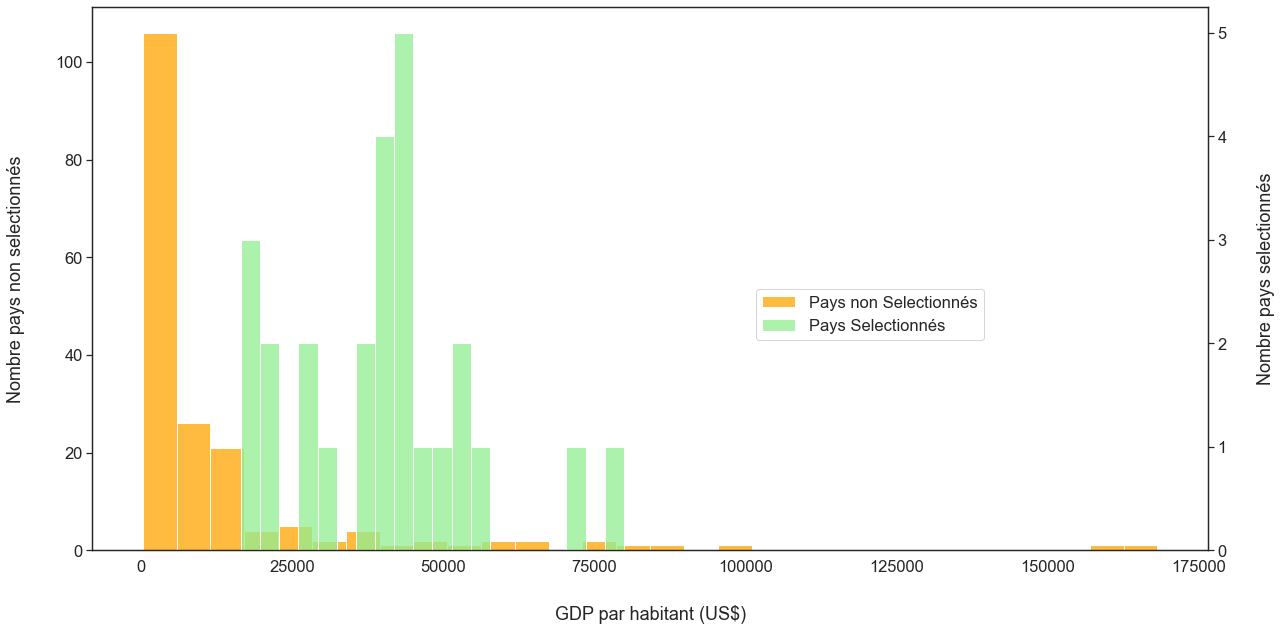

In [328]:
sns.set(style = "white", font_scale = 1.5)
fig=plt.figure(figsize=(20,10))

#utiliser deux axes differents sur meme graphique (twinx) pour difference d'echelle
ax = sns.histplot(donnéesfinales, x= donnéesfinales[donnéesfinales["Pays Selectionnés"]=='non']['NY.GDP.PCAP.CD'], bins=30, color = "orange")
ax2 = sns.histplot(donnéesfinales, x= donnéesfinales[donnéesfinales["Pays Selectionnés"]=='oui']['NY.GDP.PCAP.CD'], bins=20, color = "lightgreen", ax = ax.twinx())
ax.set(ylabel='Nombre pays non selectionnés')
ax.set(xlabel = 'GDP par habitant (US$)')
ax.yaxis.labelpad = 30
ax2.set(ylabel='Nombre pays selectionnés')
ax2.yaxis.labelpad = 30
ax.xaxis.labelpad=30

fig.legend(["Pays non Selectionnés","Pays Selectionnés"], bbox_to_anchor=(0.75, 0.5));

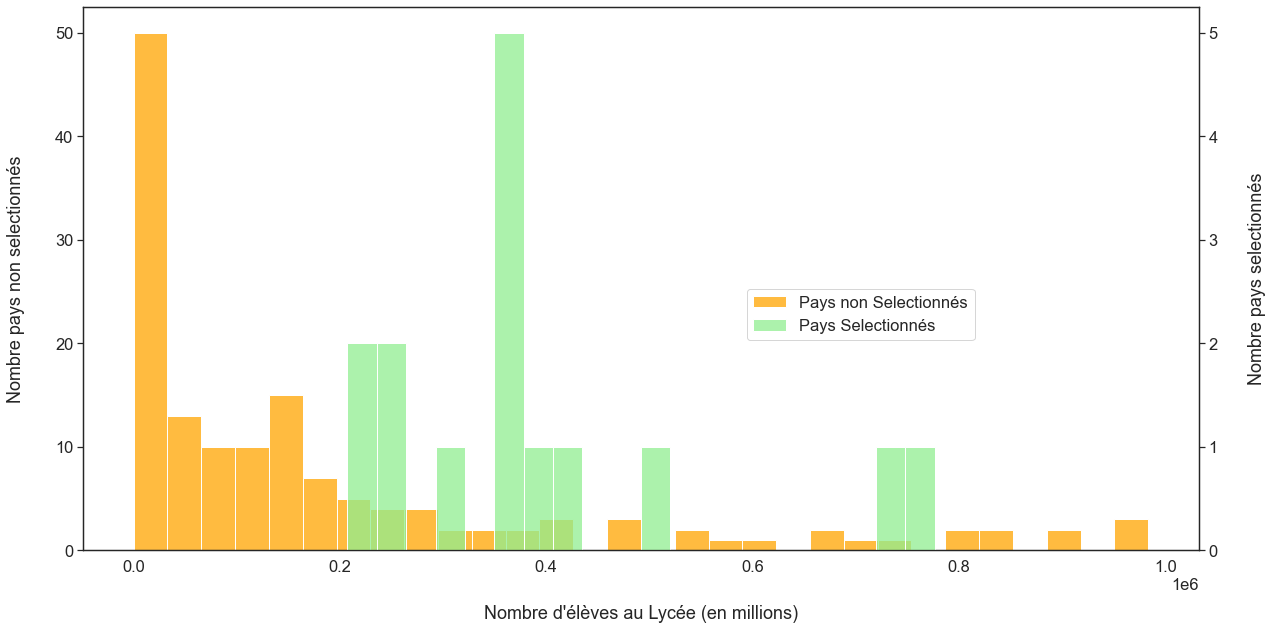

In [329]:
sns.set(style="white", font_scale = 1.5)
fig=plt.figure(figsize=(20,10))

#filtre sur données pour voir mieux
ax = sns.histplot(donnéesfinales, x= donnéesfinales[(donnéesfinales["Pays Selectionnés"]=='non') & (donnéesfinales['UIS.E.3']<1000000)]['UIS.E.3'], bins=30, color = "orange")
ax2 = sns.histplot(donnéesfinales, x= donnéesfinales[(donnéesfinales["Pays Selectionnés"]=='oui') & (donnéesfinales['UIS.E.3']<1000000)]['UIS.E.3'], bins=20, color = "lightgreen", ax = ax.twinx())
ax.set(ylabel='Nombre pays non selectionnés')
ax.set(xlabel = "Nombre d'élèves au Lycée (en millions)")
ax.yaxis.labelpad = 30
ax2.set(ylabel='Nombre pays selectionnés')
ax2.yaxis.labelpad = 30
ax.xaxis.labelpad=30
fig.legend(["Pays non Selectionnés","Pays Selectionnés"], bbox_to_anchor=(0.75, 0.5));

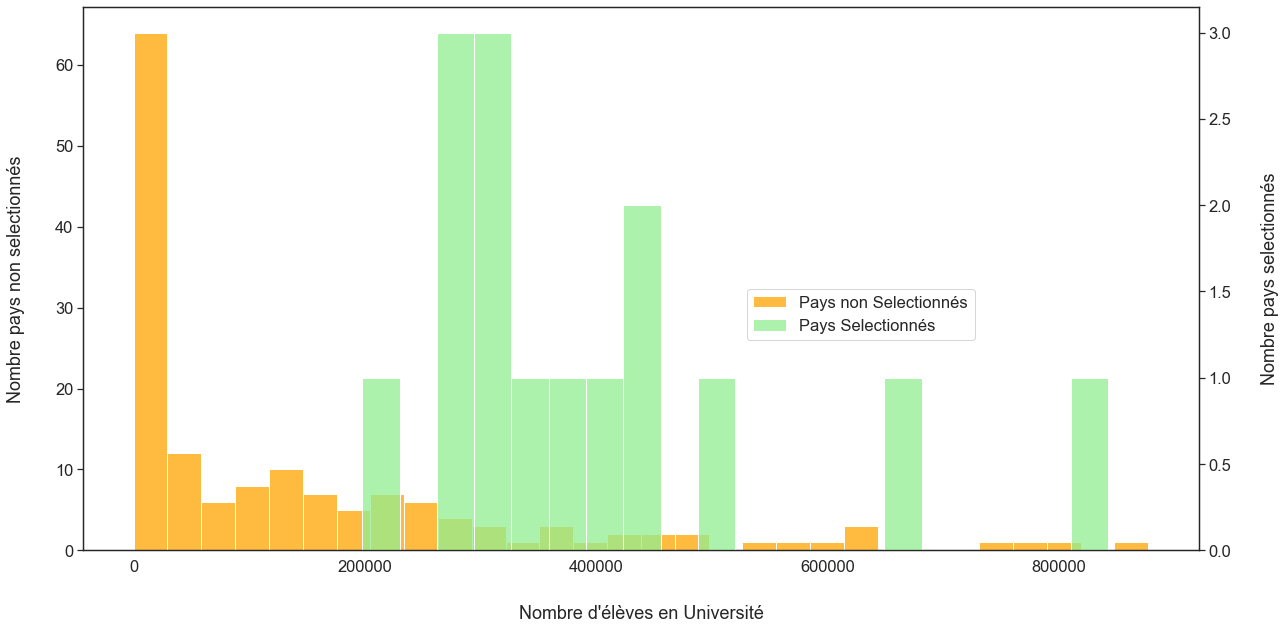

In [330]:
sns.set(style="white", font_scale = 1.5)
fig=plt.figure(figsize=(20,10))

ax = sns.histplot(donnéesfinales, x= donnéesfinales[(donnéesfinales["Pays Selectionnés"]=='non') & (donnéesfinales['SE.TER.ENRL']<1000000)]['SE.TER.ENRL'], bins=30, color = "orange")
ax2 = sns.histplot(donnéesfinales, x= donnéesfinales[(donnéesfinales["Pays Selectionnés"]=='oui') & (donnéesfinales['SE.TER.ENRL']<1000000)]['SE.TER.ENRL'], bins=20, color = "lightgreen", ax = ax.twinx())
ax.set(ylabel='Nombre pays non selectionnés')
ax.set(xlabel = "Nombre d'élèves en Université")
ax.yaxis.labelpad = 30
ax2.set(ylabel='Nombre pays selectionnés')
ax2.yaxis.labelpad = 30
ax.xaxis.labelpad=30
fig.legend(["Pays non Selectionnés","Pays Selectionnés"], bbox_to_anchor=(0.75, 0.5));

In [331]:
#fonction pour filtrer en fonction de seuils choisis

def filtreseuil (seuilinternet, seuilsecondary, seuiltertiary, seuilgdp):
    
    
    internetuserspayscomplétéfiltré = internetuserspayscomplété[internetuserspayscomplété['2020']>seuilinternet]
    internetuserspayscomplétéfiltré = internetuserspayscomplétéfiltré[["Country Name","Country Code", "Indicator Name", "Indicator Code", "2020", "Année Last Data"]]
    internetuserspayscomplétéfiltré = internetuserspayscomplétéfiltré.rename(columns={'2020':'Last Data'})
    
    nombresecondarycomplétéfiltré = nombresecondarycomplété[nombresecondarycomplété['2020']>seuilsecondary]
    nombresecondarycomplétéfiltré = nombresecondarycomplétéfiltré[["Country Name", "Country Code", "Indicator Name", "Indicator Code","2020", "Année Last Data"]]
    nombresecondarycomplétéfiltré = nombresecondarycomplétéfiltré.rename(columns={'2020':'Last Data'})

    nombretertiarycomplétéfiltré = nombretertiarycomplété[nombretertiarycomplété['2020']>seuiltertiary]
    nombretertiarycomplétéfiltré = nombretertiarycomplétéfiltré[["Country Name", "Country Code", "Indicator Name", "Indicator Code","2020", "Année Last Data"]]
    nombretertiarycomplétéfiltré = nombretertiarycomplétéfiltré.rename(columns={'2020':'Last Data'})
    
    datagdpcomplétéfiltré = datagdpcomplété[datagdpcomplété['2020']>seuilgdp]
    datagdpcomplétéfiltré = datagdpcomplétéfiltré[["Country Name", "Country Code", "Indicator Name", "Indicator Code","2020", "Année Last Data"]]
    datagdpcomplétéfiltré = datagdpcomplétéfiltré.rename(columns={'2020':'Last Data'})
    
    listepaysfinale = pd.concat([internetuserspayscomplétéfiltré, nombretertiarycomplétéfiltré, nombresecondarycomplétéfiltré, datagdpcomplétéfiltré])
    listepaysfinale = listepaysfinale.pivot(index = 'Country Name', columns = 'Indicator Code', values = 'Last Data')
    listepaysfinale = listepaysfinale.dropna()
    
    payschoisis = listepaysfinale.index.values
    
    paysnonchoisis = (datapayspresent[~datapayspresent['Country Name'].isin(payschoisis)]).copy()
    paysnonchoisisannées = paysnonchoisis.drop(["Country Name", "Country Code","Indicator Name", "Indicator Code"], axis = 1).copy()
    paysnonchoisis['Nombre Données'] = paysnonchoisisannées.notna().sum(axis = 1)
    paysnonchoisis = paysnonchoisis[paysnonchoisis['Nombre Données']>0]
    derniereannée(paysnonchoisis)
    paysnonchoisiscomplété = paysnonchoisis.fillna(method='ffill', axis = 1)
    paysnonchoisiscomplété = paysnonchoisiscomplété[['Country Name', "Country Code", "Indicator Code", "Indicator Name", "2020", "Année Last Data"]]
    paysnonchoisiscomplété = paysnonchoisiscomplété.rename(columns={"2020":"Last Data"})
    listepaysnonchoisis = paysnonchoisiscomplété.pivot(index = "Country Name", columns = 'Indicator Code', values = "Last Data")
    
    listepaysfinale["Pays Selectionnés"]='oui'
    listepaysnonchoisis['Pays Selectionnés']='non'
    
    donnéesfinales = pd.concat([listepaysfinale,listepaysnonchoisis])
    
    #fonction pour faire le travail des filtres en "maniere brute"
    #faire une boucle sur dictionnaire (pour gerer les noms) de df ??

# Scoring des pays choisis ?

In [332]:
listepaysfinale

Indicator Code       IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3  \
Country Name                                                                   
Australia                   88.2387        49927.8  1.45352e+06  1.10416e+06   
Austria                     84.3233        44676.3       425972       363188   
Belgium                     86.5165        41236.3       504745       776413   
Canada                        89.84        42157.9  1.21216e+06  1.53139e+06   
Czech Republic              76.4812        18491.9       395529       414371   
Denmark                     96.9678        53549.7       313756       311359   
Finland                     87.7036        43402.9       302478       357550   
France                      85.6222          36855  2.38888e+06  2.59836e+06   
Germany                     89.6471        42069.6  2.97778e+06  2.57995e+06   
Greece                      69.0879        17930.2       677429       371024   
Hong Kong SAR, China        87.3003        43681.4       298643       225437   
Israel                      79.7788        37175.7       374048       369316   
Italy                       61.3243        30674.8  1.82648e+06  2.78044e+06   
Japan                            92        38900.6  3.86246e+06  3.68292e+06   
Korea, Rep.                 92.7165        27538.8   3.2681e+06  1.90386e+06   
Netherlands                  90.411        45669.8       842601       746415   
New Zealand                 88.4702        39416.4       270074       249314   
Norway                      97.2982        70911.8       268231       249882   
Portugal                    70.4236        19839.6       337507       385210   
Saudi Arabia                73.7509        20028.6  1.52777e+06  1.67861e+06   
Slovak Republic             80.4759        16535.9       197854       207550   
Spain                       80.5613        26639.7  1.96392e+06  1.66258e+06   
Sweden                      91.5068        51949.3       428557       502035   
Switzerland                 89.4056        79890.5       294450       350927   
United Kingdom              94.7758        40341.4  2.35293e+06  4.19508e+06   
United States               76.1767        57638.2  1.95317e+07  1.17363e+07   

Indicator Code       Pays Selectionnés  
Country Name                            
Australia                          oui  
Austria                            oui  
Belgium                            oui  
Canada                             oui  
Czech Republic                     oui  
Denmark                            oui  
Finland                            oui  
France                             oui  
Germany                            oui  
Greece                             oui  
Hong Kong SAR, China               oui  
Israel                             oui  
Italy                              oui  
Japan                              oui  
Korea, Rep.                        oui  
Netherlands                        oui  
New Zealand                        oui  
Norway                             oui  
Portugal                           oui  
Saudi Arabia                       oui  
Slovak Republic                    oui  
Spain                              oui  
Sweden                             oui  
Switzerland                        oui  
United Kingdom                     oui  
United States                      oui

In [333]:
#maxparindicateur = 5 
#minparindicateur = 1
#attribuer score selon ce critere 
#faire une moyenne pondérée selon poids des indicateurs // somme sur 20 ? > classer selon scoring ?

def scoring (poidsinternet=1, poidslycée=1, poidsuniversité = 1, poidsgdp = 1):
    
    score = listepaysfinale.drop("Pays Selectionnés", axis = 1).copy()
    lignes = np.arange(score.shape[0])
    dicindic = {"IT.NET.USER.P2":"Internet", "NY.GDP.PCAP.CD": "GDP","SE.TER.ENRL":"Université","UIS.E.3":"Lycée" }
    dicpoids = {"Internet":poidsinternet, "GDP": poidsgdp,"Université":poidsuniversité,"Lycée":poidslycée }
    
    for indic in indicateurschoisis:        
        maxindic = score[indic].max()
        minindic = score[indic].min()
        score["Score "+ dicindic[indic]] = [5-4*((maxindic-score.iloc[i][indic])/(maxindic-minindic)) for i in lignes] 
        #new = newmax -(newmax-newmin)*(oldmax - old)/(oldmax-oldmin) en dfonnant 5 au plus gros et 1 au plus petit
        
    score["Score final"] = (sum((score["Score "+indic]*poidsindic) for indic,poidsindic in dicpoids.items()))/(sum(poid for poid in dicpoids.values()))
    score = score.sort_values(by = "Score final", ascending = False)
    return score
        

In [334]:
scoring = scoring()

In [335]:
scoring

Indicator Code       IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3  \
Country Name                                                                   
United States               76.1767        57638.2  1.95317e+07  1.17363e+07   
Norway                      97.2982        70911.8       268231       249882   
Switzerland                 89.4056        79890.5       294450       350927   
United Kingdom              94.7758        40341.4  2.35293e+06  4.19508e+06   
Japan                            92        38900.6  3.86246e+06  3.68292e+06   
Denmark                     96.9678        53549.7       313756       311359   
Germany                     89.6471        42069.6  2.97778e+06  2.57995e+06   
Sweden                      91.5068        51949.3       428557       502035   
Australia                   88.2387        49927.8  1.45352e+06  1.10416e+06   
Canada                        89.84        42157.9  1.21216e+06  1.53139e+06   
Korea, Rep.                 92.7165        27538.8   3.2681e+06  1.90386e+06   
Netherlands                  90.411        45669.8       842601       746415   
France                      85.6222          36855  2.38888e+06  2.59836e+06   
Finland                     87.7036        43402.9       302478       357550   
Hong Kong SAR, China        87.3003        43681.4       298643       225437   
Belgium                     86.5165        41236.3       504745       776413   
New Zealand                 88.4702        39416.4       270074       249314   
Austria                     84.3233        44676.3       425972       363188   
Spain                       80.5613        26639.7  1.96392e+06  1.66258e+06   
Israel                      79.7788        37175.7       374048       369316   
Saudi Arabia                73.7509        20028.6  1.52777e+06  1.67861e+06   
Slovak Republic             80.4759        16535.9       197854       207550   
Italy                       61.3243        30674.8  1.82648e+06  2.78044e+06   
Czech Republic              76.4812        18491.9       395529       414371   
Portugal                    70.4236        19839.6       337507       385210   
Greece                      69.0879        17930.2       677429       371024   

Indicator Code        Score Internet  Score GDP  Score Université  \
Country Name                                                        
United States               2.651471   3.595059          5.000000   
Norway                      5.000000   4.433110          1.014560   
Switzerland                 4.122405   5.000000          1.019985   
United Kingdom              4.719530   2.503000          1.445866   
Japan                       4.410884   2.412030          1.758173   
Denmark                     4.963260   3.336928          1.023979   
Germany                     4.149262   2.612112          1.575141   
Sweden                      4.356048   3.235882          1.047730   
Australia                   3.992655   3.108254          1.259786   
Canada                      4.170711   2.617689          1.209851   
Korea, Rep.                 4.490558   1.694686          1.635205   
Netherlands                 4.234196   2.839418          1.133392   
France                      3.701727   2.282878          1.453303   
Finland                     3.933167   2.696290          1.021646   
Hong Kong SAR, China        3.888322   2.713877          1.020852   
Belgium                     3.801165   2.559498          1.063493   
New Zealand                 4.018399   2.444595          1.014942   
Austria                     3.557304   2.776693          1.047195   
Spain                       3.139001   1.637922          1.365384   
Israel                      3.051989   2.303130          1.036453   
Saudi Arabia                2.381739   1.220519          1.275147   
Slovak Republic             3.129502   1.000000          1.000000   
Italy                       1.000000   1.892685          1.336947   
Czech Republic              2.6853

In [336]:
#score US elevé comparé aux autre car rgande population > autre pondération de critere ? 

# Etude par zone géographique des pays chosiis

In [337]:
listepaysfinale

Indicator Code       IT.NET.USER.P2 NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3  \
Country Name                                                                   
Australia                   88.2387        49927.8  1.45352e+06  1.10416e+06   
Austria                     84.3233        44676.3       425972       363188   
Belgium                     86.5165        41236.3       504745       776413   
Canada                        89.84        42157.9  1.21216e+06  1.53139e+06   
Czech Republic              76.4812        18491.9       395529       414371   
Denmark                     96.9678        53549.7       313756       311359   
Finland                     87.7036        43402.9       302478       357550   
France                      85.6222          36855  2.38888e+06  2.59836e+06   
Germany                     89.6471        42069.6  2.97778e+06  2.57995e+06   
Greece                      69.0879        17930.2       677429       371024   
Hong Kong SAR, China        87.3003        43681.4       298643       225437   
Israel                      79.7788        37175.7       374048       369316   
Italy                       61.3243        30674.8  1.82648e+06  2.78044e+06   
Japan                            92        38900.6  3.86246e+06  3.68292e+06   
Korea, Rep.                 92.7165        27538.8   3.2681e+06  1.90386e+06   
Netherlands                  90.411        45669.8       842601       746415   
New Zealand                 88.4702        39416.4       270074       249314   
Norway                      97.2982        70911.8       268231       249882   
Portugal                    70.4236        19839.6       337507       385210   
Saudi Arabia                73.7509        20028.6  1.52777e+06  1.67861e+06   
Slovak Republic             80.4759        16535.9       197854       207550   
Spain                       80.5613        26639.7  1.96392e+06  1.66258e+06   
Sweden                      91.5068        51949.3       428557       502035   
Switzerland                 89.4056        79890.5       294450       350927   
United Kingdom              94.7758        40341.4  2.35293e+06  4.19508e+06   
United States               76.1767        57638.2  1.95317e+07  1.17363e+07   

Indicator Code       Pays Selectionnés  
Country Name                            
Australia                          oui  
Austria                            oui  
Belgium                            oui  
Canada                             oui  
Czech Republic                     oui  
Denmark                            oui  
Finland                            oui  
France                             oui  
Germany                            oui  
Greece                             oui  
Hong Kong SAR, China               oui  
Israel                             oui  
Italy                              oui  
Japan                              oui  
Korea, Rep.                        oui  
Netherlands                        oui  
New Zealand                        oui  
Norway                             oui  
Portugal                           oui  
Saudi Arabia                       oui  
Slovak Republic                    oui  
Spain                              oui  
Sweden                             oui  
Switzerland                        oui  
United Kingdom                     oui  
United States                      oui

In [338]:
paysregion = country[['Table Name', 'Region']]
paysregion = paysregion.rename(columns={"Table Name":"Country Name"})

In [339]:
paysregion

Country Name                      Region
0           Aruba   Latin America & Caribbean
1     Afghanistan                  South Asia
2          Angola          Sub-Saharan Africa
3         Albania       Europe & Central Asia
4         Andorra       Europe & Central Asia
..            ...                         ...
236        Kosovo       Europe & Central Asia
237   Yemen, Rep.  Middle East & North Africa
238  South Africa          Sub-Saharan Africa
239        Zambia          Sub-Saharan Africa
240      Zimbabwe          Sub-Saharan Africa

[241 rows x 2 columns]

In [340]:
listepaysfinaleregion = pd.merge(paysregion, listepaysfinale, on="Country Name", how='right')

In [341]:
listepaysfinaleregion

Country Name                      Region IT.NET.USER.P2  \
0              Australia         East Asia & Pacific        88.2387   
1                Austria       Europe & Central Asia        84.3233   
2                Belgium       Europe & Central Asia        86.5165   
3                 Canada               North America          89.84   
4         Czech Republic       Europe & Central Asia        76.4812   
5                Denmark       Europe & Central Asia        96.9678   
6                Finland       Europe & Central Asia        87.7036   
7                 France       Europe & Central Asia        85.6222   
8                Germany       Europe & Central Asia        89.6471   
9                 Greece       Europe & Central Asia        69.0879   
10  Hong Kong SAR, China         East Asia & Pacific        87.3003   
11                Israel  Middle East & North Africa        79.7788   
12                 Italy       Europe & Central Asia        61.3243   
13                 Japan         East Asia & Pacific             92   
14           Korea, Rep.         East Asia & Pacific        92.7165   
15           Netherlands       Europe & Central Asia         90.411   
16           New Zealand         East Asia & Pacific        88.4702   
17                Norway       Europe & Central Asia        97.2982   
18              Portugal       Europe & Central Asia        70.4236   
19          Saudi Arabia  Middle East & North Africa        73.7509   
20       Slovak Republic       Europe & Central Asia        80.4759   
21                 Spain       Europe & Central Asia        80.5613   
22                Sweden       Europe & Central Asia        91.5068   
23           Switzerland       Europe & Central Asia        89.4056   
24        United Kingdom       Europe & Central Asia        94.7758   
25         United States               North America        76.1767   

   NY.GDP.PCAP.CD  SE.TER.ENRL      UIS.E.3 Pays Selectionnés  
0         49927.8  1.45352e+06  1.10416e+06               oui  
1         44676.3       425972       363188               oui  
2         41236.3       504745       776413               oui  
3         42157.9  1.21216e+06  1.53139e+06               oui  
4         18491.9       395529       414371               oui  
5         53549.7       313756       311359               oui  
6         43402.9       302478       357550               oui  
7           36855  2.38888e+06  2.59836e+06               oui  
8         42069.6  2.97778e+06  2.57995e+06               oui  
9         17930.2       677429       371024               oui  
10        43681.4       298643       225437               oui  
11        37175.7       374048       369316               oui  
12        30674.8  1.82648e+06  2.78044e+06               oui  
13        38900.6  3.86246e+06  3.68292e+06               oui  
14        27538.8   3.2681e+06  1.90386e+06               oui  
15        45669.8       842601       746415               oui  
16        39416.4       270074       249314               oui  
17        70911.8       268231       249882               oui  
18        19839.6       337507       385210               oui  
19        20028.6  1.52777e+06  1.67861e+06               oui  
20        16535.9       197854       207550               oui  
21        26639.7  1.96392e+06  1.66258e+06               oui  
22        51949.3       428557       502035               oui  
23        79890.5       294450       350927               oui  
24        40341.4  2.35293e+06  4.19508e+06               oui  
25        57638.2  1.95317e+07  1.17363e+07               oui

In [342]:
listepaysfinaleregion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Country Name       26 non-null     object
 1   Region             26 non-null     object
 2   IT.NET.USER.P2     26 non-null     object
 3   NY.GDP.PCAP.CD     26 non-null     object
 4   SE.TER.ENRL        26 non-null     object
 5   UIS.E.3            26 non-null     object
 6   Pays Selectionnés  26 non-null     object
dtypes: object(7)
memory usage: 1.6+ KB


In [343]:
#convertir en float car object
for indic in indicateurschoisis:
    listepaysfinaleregion[indic] = pd.to_numeric(listepaysfinaleregion[indic])

In [344]:
listepaysfinaleregion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Name       26 non-null     object 
 1   Region             26 non-null     object 
 2   IT.NET.USER.P2     26 non-null     float64
 3   NY.GDP.PCAP.CD     26 non-null     float64
 4   SE.TER.ENRL        26 non-null     float64
 5   UIS.E.3            26 non-null     float64
 6   Pays Selectionnés  26 non-null     object 
dtypes: float64(4), object(3)
memory usage: 1.6+ KB


In [345]:
#compter nombre pays selectionnés par region
listepaysfinaleregion.groupby(["Region"]).count()

Country Name  IT.NET.USER.P2  NY.GDP.PCAP.CD  \
Region                                                                     
East Asia & Pacific                    5               5               5   
Europe & Central Asia                 17              17              17   
Middle East & North Africa             2               2               2   
North America                          2               2               2   

                            SE.TER.ENRL  UIS.E.3  Pays Selectionnés  
Region                                                               
East Asia & Pacific                   5        5                  5  
Europe & Central Asia                17       17                 17  
Middle East & North Africa            2        2                  2  
North America                         2        2                  2

In [346]:
#indicateurs stats
etuderegion = listepaysfinaleregion.groupby(['Region']).describe()

In [347]:
etuderegion

IT.NET.USER.P2                                   \
                                    count       mean        std        min   
Region                                                                       
East Asia & Pacific                   5.0  89.745147   2.438528  87.300343   
Europe & Central Asia                17.0  84.266594  10.133235  61.324253   
Middle East & North Africa            2.0  76.764847   4.262360  73.750904   
North America                         2.0  83.008368   9.661386  76.176737   

                                                                        \
                                  25%        50%        75%        max   
Region                                                                   
East Asia & Pacific         88.238658  88.470186  92.000000  92.716545   
Europe & Central Asia       80.475900  86.516500  90.410959  97.298204   
Middle East & North Africa  75.257876  76.764847  78.271819  79.778791   
North America               79.592553  83.008368  86.424184  89.840000   

                           NY.GDP.PCAP.CD                ...  SE.TER.ENRL  \
                                    count          mean  ...          75%   
Region                                                   ...                
East Asia & Pacific                   5.0  39892.995125  ...   3268099.00   
Europe & Central Asia                17.0  40039.103487  ...   1826477.00   
Middle East & North Africa            2.0  28602.195118  ...   1239338.75   
North America                         2.0  49898.043540  ...  14951836.25   

                                       UIS.E.3                              \
                                   max   count          mean           std   
Region                                                                       
East Asia & Pacific          3862460.0     5.0  1.433138e+06  1.436254e+06   
Europe & Central Asia        2977781.0    17.0  1.108961e+06  1.200259e+06   
Middle East & North Africa   1527769.0     2.0  1.023964e+06  9.258128e+05   
North America               19531728.0     2.0  6.633854e+06  7.215970e+06   

                                                                            \
                                  min           25%        50%         75%   
Region                                                                       
East Asia & Pacific          225437.0  2.493140e+05  1104162.0  1903857.00   
Europe & Central Asia        207550.0  3.575500e+05   414371.0  1662580.00   
Middle East & North Africa   369316.0  6.966402e+05  1023964.5  1351288.75   
North America               1531393.0  4.082624e+06  6633854.0  9185084.50   

                                        
                                   max  
Region                                  
East Asia & Pacific          3682920.0  
Europe & Central Asia        4195081.5  
Middle East & North Africa   1678613.0  
North America               11736315.0  

[4 rows x 32 columns]

In [348]:
etuderegioninternet = etuderegion['IT.NET.USER.P2']
etuderegiongdp = etuderegion['NY.GDP.PCAP.CD']
etuderegionlycée = etuderegion['UIS.E.3']
etuderegionuniversité = etuderegion['SE.TER.ENRL']

In [349]:
etuderegioninternet

count       mean        std        min        25%  \
Region                                                                          
East Asia & Pacific           5.0  89.745147   2.438528  87.300343  88.238658   
Europe & Central Asia        17.0  84.266594  10.133235  61.324253  80.475900   
Middle East & North Africa    2.0  76.764847   4.262360  73.750904  75.257876   
North America                 2.0  83.008368   9.661386  76.176737  79.592553   

                                  50%        75%        max  
Region                                                       
East Asia & Pacific         88.470186  92.000000  92.716545  
Europe & Central Asia       86.516500  90.410959  97.298204  
Middle East & North Africa  76.764847  78.271819  79.778791  
North America               83.008368  86.424184  89.840000

In [350]:
etuderegiongdp

count          mean           std           min  \
Region                                                                        
East Asia & Pacific           5.0  39892.995125   8198.901684  27538.806128   
Europe & Central Asia        17.0  40039.103487  17900.228127  16535.916864   
Middle East & North Africa    2.0  28602.195118  12124.826319  20028.648207   
North America                 2.0  49898.043540  10946.176383  42157.927991   

                                     25%           50%           75%  \
Region                                                                 
East Asia & Pacific         38900.569306  39416.358733  43681.421951   
Europe & Central Asia       26639.740588  41236.266589  45669.814802   
Middle East & North Africa  24315.421662  28602.195118  32888.968573   
North America               46027.985765  49898.043540  53768.101314   

                                     max  
Region                                    
East Asia & Pacific         49927.819509  
Europe & Central Asia       79890.524005  
Middle East & North Africa  37175.742029  
North America               57638.159088

In [351]:
etuderegionlycée

count          mean           std        min  \
Region                                                                     
East Asia & Pacific           5.0  1.433138e+06  1.436254e+06   225437.0   
Europe & Central Asia        17.0  1.108961e+06  1.200259e+06   207550.0   
Middle East & North Africa    2.0  1.023964e+06  9.258128e+05   369316.0   
North America                 2.0  6.633854e+06  7.215970e+06  1531393.0   

                                     25%        50%         75%         max  
Region                                                                       
East Asia & Pacific         2.493140e+05  1104162.0  1903857.00   3682920.0  
Europe & Central Asia       3.575500e+05   414371.0  1662580.00   4195081.5  
Middle East & North Africa  6.966402e+05  1023964.5  1351288.75   1678613.0  
North America               4.082624e+06  6633854.0  9185084.50  11736315.0

In [352]:
etuderegionuniversité

count          mean           std           min  \
Region                                                                        
East Asia & Pacific           5.0  1.830559e+06  1.667272e+06  2.700742e+05   
Europe & Central Asia        17.0  9.705355e+05  9.265906e+05  1.978540e+05   
Middle East & North Africa    2.0  9.509085e+05  8.158039e+05  3.740480e+05   
North America                 2.0  1.037194e+07  1.295389e+07  1.212161e+06   

                                     25%         50%          75%         max  
Region                                                                         
East Asia & Pacific         2.986427e+05   1453521.0   3268099.00   3862460.0  
Europe & Central Asia       3.137560e+05    428557.0   1826477.00   2977781.0  
Middle East & North Africa  6.624782e+05    950908.5   1239338.75   1527769.0  
North America               5.792053e+06  10371944.5  14951836.25  19531728.0

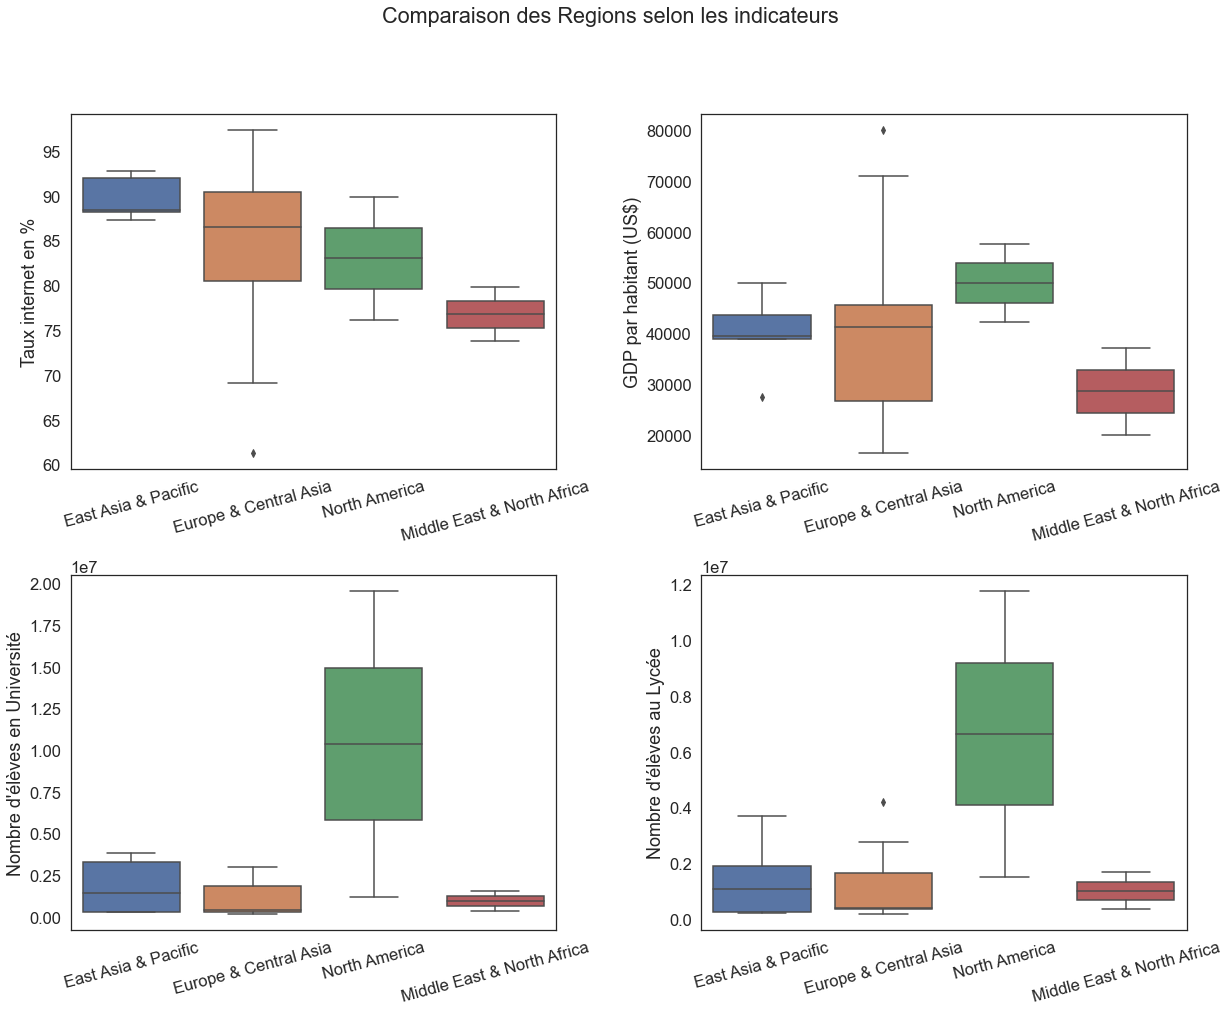

In [353]:
dicindic = {'IT.NET.USER.P2':'Taux internet en %',
                'UIS.E.3': "Nombre d'élèves au Lycée",
                "SE.TER.ENRL": "Nombre d'élèves en Université",
                "NY.GDP.PCAP.CD": "GDP par habitant (US$)"}

fig = plt.figure(figsize=(20,15))
fig.suptitle('Comparaison des Regions selon les indicateurs')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
j=1

for indic in indicateurschoisis:
    fig.add_subplot(2,2,j)
    ax=sns.boxplot(data = listepaysfinaleregion, y=indic, x='Region')
    ax.set(ylabel=dicindic[indic])
    ax.set(xlabel='')
    plt.xticks(rotation=15)
    j+=1

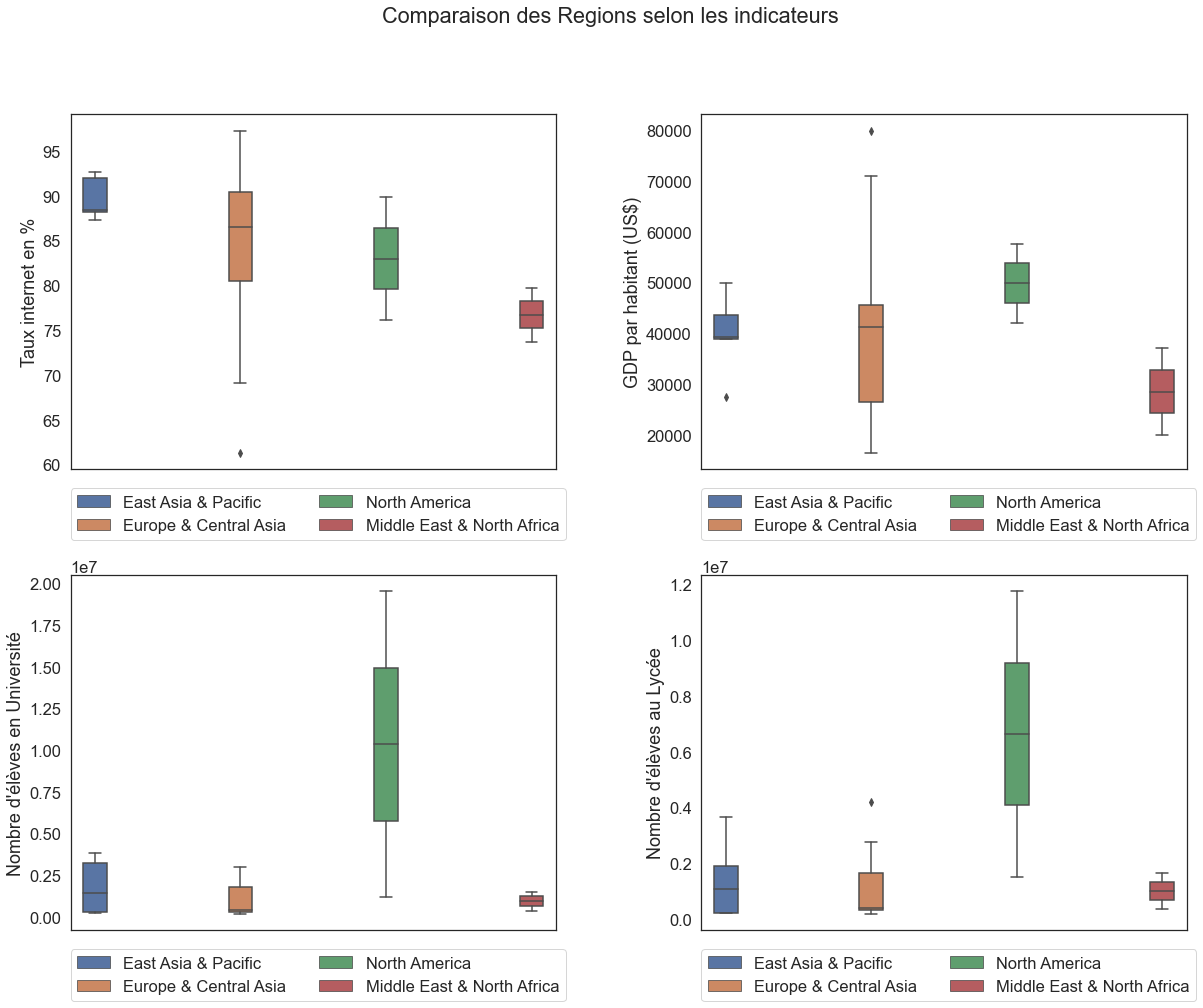

In [354]:
dicindic = {'IT.NET.USER.P2':'Taux internet en %',
                'UIS.E.3': "Nombre d'élèves au Lycée",
                "SE.TER.ENRL": "Nombre d'élèves en Université",
                "NY.GDP.PCAP.CD": "GDP par habitant (US$)"}

fig = plt.figure(figsize=(20,15))
fig.suptitle('Comparaison des Regions selon les indicateurs')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
j=1

for indic in indicateurschoisis:
    fig.add_subplot(2,2,j)
    ax=sns.boxplot(data = listepaysfinaleregion, y=indic, x='Region' , hue='Region')
    ax.axes.xaxis.set_visible(False)    
    ax.set(ylabel=dicindic[indic])
    plt.legend(loc =(0,-0.2), ncol=2)
    j+=1